# **Data Loading and Pre-Processing**

## **Import Libraries**
Import required librarires for data loading and pre-processing.

In [ ]:
import os
import cv2
import numpy as np
import pandas as pd
import seaborn as sn
from skimage import color, io
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

## **Define Parameters**

Define required parameters for the implementation. This includes,


1.   `BASE_PATH:` google drive base path to the project. 
2.   `DATASET_PATH:` path in google drive to the dataset (Both small and large datasets: https://drive.google.com/drive/folders/1ew5AMnyhpRP9OcLRH49Wd1Y3h3btNW_Q?usp=sharing).


> Make sure you replace the dataset with the images in the given link (naming format is important => Deforestation_(image number).jpg. *Labeled dataset is not required.



3. `SHAPE`: shape of the images required for the CNN architecture (299,299,3).

Folder structure: Drive => Colab Notebooks => FYP - Anomaly Detection in Image Streams => datasets =>
  1. Large_Dataset
  2. Small_Dataset
  => Unabeled
  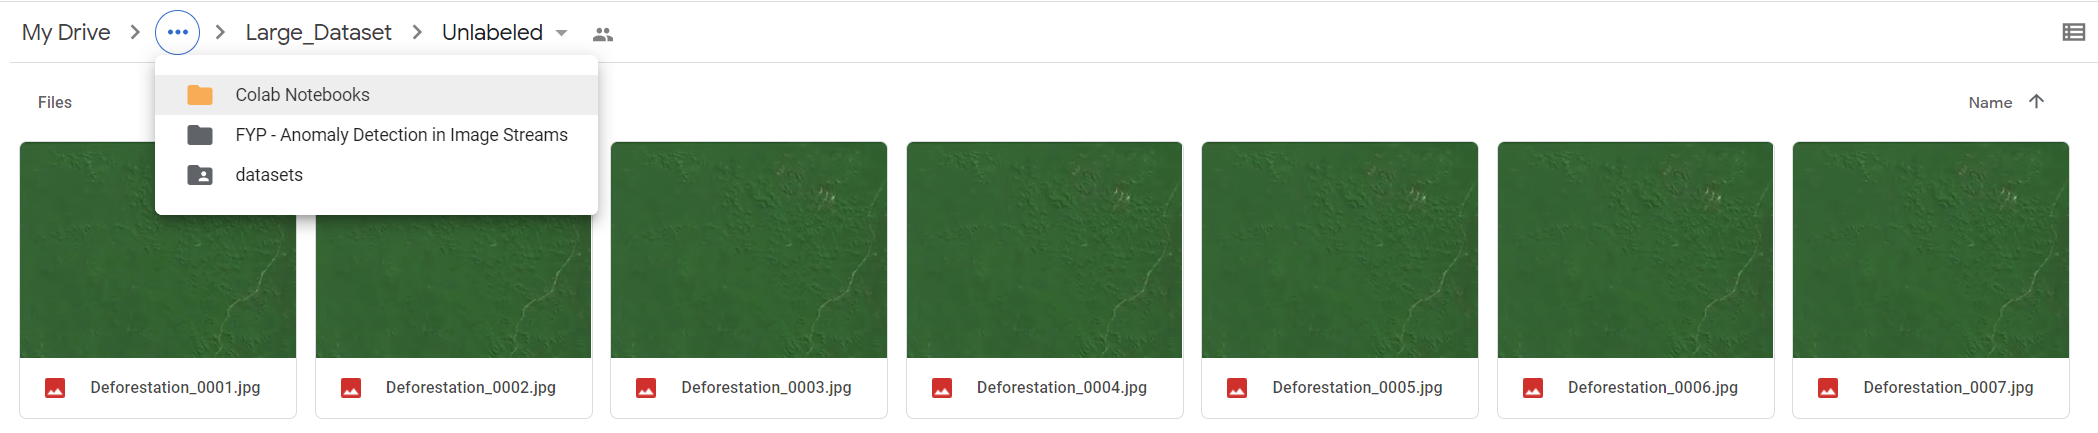




In [ ]:
BASE_PATH = "/content/drive/MyDrive/Colab Notebooks/FYP - Anomaly Detection in Image Streams"
DATASET_PATH = BASE_PATH + "/datasets/Volcano_Eruption "

#Initialize the path to the original input directory of images
ORIG_LARGE_INPUT_DATASET = DATASET_PATH + "/Large_Dataset"
ORIG_SMALL_INPUT_DATASET = DATASET_PATH + "/Small_Dataset"

#Initialize paths to save extracted features
RESNET_FEATURES = BASE_PATH + "/InceptionV3Features"

#Define names of the training, testing and validation directories
TRAIN = "training"
VAL = "validation"
TEST = "evaluation"

#Define shape
img_width = 299
img_height = 299
SHAPE = (img_width, img_height, 3)

## **Load Images**
Function written to load and return image files in time-series order from a given `path` parameter.

In [ ]:
'''function to load folder into an array and then it returns that same array'''
def loadImages(path):
  # Put files into lists and return them as one list of size 4
  image_files = sorted([os.path.join(path, 'Unlabeled', file)
    for file in os.listdir(path + "/Unlabeled") 
      if file.endswith('.jpg')
    ])
 
  return image_files

## **Quick Look at the Data**


Passed `path of the large dataset: ORIG_LARGE_INPUT_DATASET` as an argument to the loadImages function and save the returned image files in the `imgPath_arr`.

In [ ]:
#Save paths of all the images to an array
path = ORIG_LARGE_INPUT_DATASET

imgPath_arr = loadImages(path)
print("The length of the image dataset: ", len(imgPath_arr))
print(imgPath_arr)

The length of the image dataset:  2500
['/content/drive/MyDrive/Colab Notebooks/FYP - Anomaly Detection in Image Streams/datasets/Volcano_Eruption /Large_Dataset/Unlabeled/VolcanoEruption_0001.jpg', '/content/drive/MyDrive/Colab Notebooks/FYP - Anomaly Detection in Image Streams/datasets/Volcano_Eruption /Large_Dataset/Unlabeled/VolcanoEruption_0002.jpg', '/content/drive/MyDrive/Colab Notebooks/FYP - Anomaly Detection in Image Streams/datasets/Volcano_Eruption /Large_Dataset/Unlabeled/VolcanoEruption_0003.jpg', '/content/drive/MyDrive/Colab Notebooks/FYP - Anomaly Detection in Image Streams/datasets/Volcano_Eruption /Large_Dataset/Unlabeled/VolcanoEruption_0004.jpg', '/content/drive/MyDrive/Colab Notebooks/FYP - Anomaly Detection in Image Streams/datasets/Volcano_Eruption /Large_Dataset/Unlabeled/VolcanoEruption_0005.jpg', '/content/drive/MyDrive/Colab Notebooks/FYP - Anomaly Detection in Image Streams/datasets/Volcano_Eruption /Large_Dataset/Unlabeled/VolcanoEruption_0006.jpg', '/cont

Read the image in each path of the `imgPath_arr` and save them in an array named `img_arr`.

In [ ]:
#Read images and save to an array
img_arr = []

for path in imgPath_arr:
  img = io.imread(path)
  img_arr.append(img)  

Save image data into a dataframe (This is used to visualise images in the next step).


```
Note: Here timestamp is equals to the image number.
```



In [ ]:
#Create dataframe of images
imagePaths = list(imgPath_arr)
df = pd.DataFrame(columns=['Time-Stamp', 'Image_Name', 'Image_Frame', 'Image_Path'])

for imagePath in imagePaths:
  #Get the file name
  filename = imagePath.split(os.path.sep)[-1]
  #Get the time stamp of image
  new_filename = filename.split("_")[1]
  time_stamp = int(new_filename.split(".")[0])

  #Perform data pre-processing
  img = io.imread(imagePath)

  #Save data in a dataframe
  dict = {'Time-Stamp': time_stamp, 'Image_Name': filename, 'Image_Frame': img, 'Image_Path': imagePath}
  df = df.append(dict, ignore_index=True)
  df

### **Plot Some Images form the Dataset**

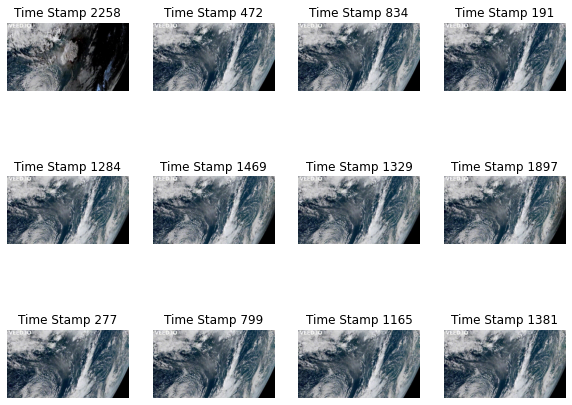

In [ ]:
#Construct a figure on which we will visualize the images.
fig, axes = plt.subplots(3, 4, figsize=(10, 8))

data_choice = np.random.choice(range(1, 2500), size=12)
for idx, ax in enumerate(axes.flat):
  ax.imshow(df.iloc[data_choice[idx], 2])
  ax.set_title("Time Stamp " + str(df.iloc[data_choice[idx], 0]))
  ax.axis("off")
plt.show()

Few functions written in order to display images for future use.


1.  `displayOne:` to visualise one image.
2.  `displayTwo:` two visualise two images in a row.

In [ ]:
#Function to display one image
def displayOne(a, title1 = "Original Image"):
  plt.imshow(a), plt.title(title1)
  plt.show()

#Function to display two images
def displayTwo(a, b, title1 = "Original Image", title2 = "Edited"):
  plt.subplot(121), plt.imshow(a), plt.title(title1)
  plt.subplot(122), plt.imshow(b), plt.title(title2)
  plt.gcf().set_facecolor("#e8eae6")
  plt.show()

#Function to plot the histogram for a given image
def createHistogram(img, bins, range):
  hist = plt.hist(img.ravel(), bins, [range[0], range[1]])
  return hist

## **Data Preprocessing**

Define images picked for visualization purposes.

In [ ]:
#Pick some images for visualization purpose
original_img = img_arr[1900]
original_imgs = [img_arr[50], img_arr[2300]]

### **Contrast Images**
Function written to enhance the contrast of a given image. 

In [ ]:
def contrastImage(img):
  xp = [0, 64, 128, 192, 255]
  fp = [0, 16, 128, 240, 255]
  x = np.arange(256)
  table = np.interp(x, xp, fp).astype('uint8')
  contrastImg = cv2.LUT(img, table)
  return contrastImg

Contrasted Image


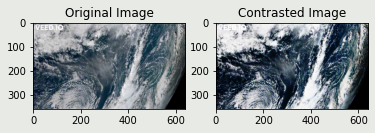

In [ ]:
# Enhance the contrast and visualize an image in the dataset
print("Contrasted Image")
open_img = contrastImage(original_img)
displayTwo(original_img, open_img, "Original Image", "Contrasted Image")

### **Dilation of Images**
Function written to dilate a given image. 


*   Increases the object area
* Used to accentuate features



In [ ]:
kernel = np.ones((5,5), np.uint8)

In [ ]:
def dilateImage(img):
  # Use a disk of radius 3
  img_erosion = cv2.dilate(img, kernel, iterations=1)
  return img_erosion

Dilated Image


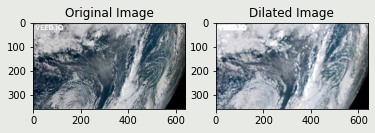

In [ ]:
# Dilate and visualize an image in the dataset
print("Dilated Image")
open_img = dilateImage(original_img)
displayTwo(original_img, open_img, "Original Image", "Dilated Image")


### **Resize Images**
Function written to resize a given image. Parameters required: `img, img width and img height.`

In [ ]:
def resizeImage(img, height, width):
  #Load the image
  print('Original Image Size: ', img.shape)

  #Set dims of the resized image
  height = height
  width = width
  dim = (width, height)
  res_img = cv2.resize(img, dim, interpolation=cv2.INTER_AREA)

  #Check the size of resized image
  print("Resized Image Size: ", res_img.shape)
  return res_img

Visualization of a selected resized image for the CNN model (Image height: 224 and image width 224).

Resized Image
Original Image Size:  (360, 640, 3)
Resized Image Size:  (299, 299, 3)


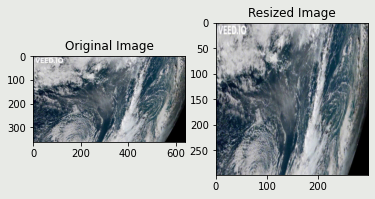

In [ ]:
#Resize and visualize an image in the dataset
print("Resized Image")
res_img = resizeImage(original_img, img_height, img_width)
displayTwo(original_img, res_img, "Original Image", "Resized Image")
print(" ")

### **Normalization**
Function written to normalize the pixel value of a given image between 0-255. 

In [ ]:
def normalizeImage(img):
  normalizedImg = cv2.normalize(img, None, alpha = 0, beta = 255, norm_type = cv2.NORM_MINMAX)
  return normalizedImg

Visualization of a selected normalized image for the Cnn model.

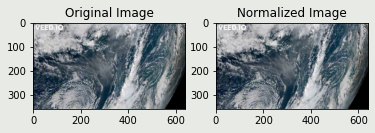

In [ ]:
#Apply Normalization to an image in the dataset
res_img = normalizeImage(original_img)
displayTwo(original_img, res_img, "Original Image", "Normalized Image")

### **Crop Images**
Function written to crop image from the bottom to remove an unnecessary text part.

In [ ]:
def cropImage(img):
  x=0
  y=0
  h=640
  w=325
  crop_img = img[x:w, y:h]

  #Check the size of cropped image
  print("Cropped Image Size: ", crop_img.shape)
  return crop_img

Cropped Image
Cropped Image Size:  (325, 640, 3)


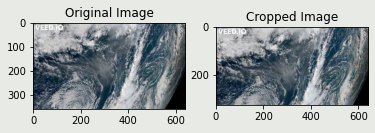

In [ ]:
# Resize and visualize an image in the dataset
print("Cropped Image")
crop_img = cropImage(original_img)
displayTwo(original_img, crop_img, "Original Image", "Cropped Image")
print(" ")

### **Apply Pre-Processing**
Function written to apply pre-processing for the images in the `img_arr`. Image will be resized and normalised. Required parameters: `model_type.`



In [ ]:
processed_imgs = []

def preprocessImg():
  for img in img_arr:
    normalized_img = normalizeImage(img)
    #dilated_img = dilateImage(normalized_img)
    contrasted_img = contrastImage(normalized_img)
    cropped_img = cropImage(contrasted_img)
    resized_img = resizeImage(cropped_img, img_height, img_width)
    processed_imgs.append(resized_img)

  return processed_imgs

# **CNN based Feature Extraction**

## **Prepare data for the CNN model**

### **Import Libraries**
Import required libraries for feature extarction (which are not previously imported).

In [ ]:
import tensorflow as tf
from keras_preprocessing import image
from keras_preprocessing.image import img_to_array
from keras import Sequential
from keras.layers import Flatten, GlobalMaxPooling2D
from keras.models import Model
from tensorflow.keras import utils 
import time
from tqdm import tqdm 
from sklearn.preprocessing import MinMaxScaler

### **Prepare Images for the Model**
Function to prepare images to match the requirements of a given model. Required parameters: `image, model_name`.
1. Convert the image instance into a numpy array.
2. Use `model_name.preprocess_input` to preprocess the image. This will converts the images from RGB to BGR, then each color channel is zero-centered with respect to the ImageNet dataset, without scaling.
3. Reshape the images from (img_width,img_height,3) shape into (1,img_width,img_height,3).

In [ ]:
def prepareImageForModel(img):
  #Converts the image instance into a numpy array
  img = image.img_to_array(img)
  #Prepare the image for the CNN model
  img = tf.keras.applications.inception_v3.preprocess_input(img)
  #Reshape data for the model
  img = img.reshape((1, img.shape[0], img.shape[1], img.shape[2]))
  return img

## **Feature Extraction using InceptionV3 Architecture**

### **Define Parameters**

In [ ]:
timeSpent = []
model = []

### **CNN Model Building**

Function written to build and return the `FeatureExtractionModel`.

In [ ]:
def getFeatureExtractionModel():
  cnn = tf.keras.applications.inception_v3.InceptionV3(include_top=False, #to remove the classification layers
                                                       weights='imagenet', #trains the model using imagenet weights
                                                       input_shape=SHAPE #define the input shape of the model
                                                      )
  #Convert the model into a sequential model
  model = Sequential()(cnn.layers[-1].output)
  #Add GlobalMaxPooling2D layer for dimension reduction
  model = GlobalMaxPooling2D()(model)
  model = Model(inputs=cnn.inputs, outputs=model)
  return model

Save the model output returned from the `getFeatureExtractionModel()` to the `cnn_model`.

In [ ]:
cnn_model = getFeatureExtractionModel()
cnn_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 299, 299, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 149, 149, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 149, 149, 32  96         ['conv2d[0][0]']                 
 alization)                     )                                                             

**Plot a summary of the model architecture**

In [ ]:
utils.plot_model(cnn_model, show_shapes=True, show_layer_names=True)

### **Perform Feature Extraction**

Preprocess the image dataset using the `preprocessImg()` function. 
1. Images are reseized.
2. Images are normalized.

In [ ]:
cnn_imgs = preprocessImg()

Streaming output truncated to the last 5000 lines.
Original Image Size:  (325, 640, 3)
Resized Image Size:  (299, 299, 3)
Cropped Image Size:  (325, 640, 3)
Original Image Size:  (325, 640, 3)
Resized Image Size:  (299, 299, 3)
Cropped Image Size:  (325, 640, 3)
Original Image Size:  (325, 640, 3)
Resized Image Size:  (299, 299, 3)
Cropped Image Size:  (325, 640, 3)
Original Image Size:  (325, 640, 3)
Resized Image Size:  (299, 299, 3)
Cropped Image Size:  (325, 640, 3)
Original Image Size:  (325, 640, 3)
Resized Image Size:  (299, 299, 3)
Cropped Image Size:  (325, 640, 3)
Original Image Size:  (325, 640, 3)
Resized Image Size:  (299, 299, 3)
Cropped Image Size:  (325, 640, 3)
Original Image Size:  (325, 640, 3)
Resized Image Size:  (299, 299, 3)
Cropped Image Size:  (325, 640, 3)
Original Image Size:  (325, 640, 3)
Resized Image Size:  (299, 299, 3)
Cropped Image Size:  (325, 640, 3)
Original Image Size:  (325, 640, 3)
Resized Image Size:  (299, 299, 3)
Cropped Image Size:  (325, 640

**Extract features using the CNN feature extraction model.** 
1. Open a file to save the extracted features.
2. Prepare image to match the requirements of the model using the `prepareImageForModel()` function.
3. Extract features for each image.
4. Get the average of the extracted features to get a single feature value for each image. 
5. Append each images' feature value into the `cnn_feature_arr` to get the final feature vector.
6. Time to extract features of all images will be calculated => `cnn_time`


In [ ]:
#Feature vector to save single feature value of all images
cnn_feature_arr = []
cnn_start = time.time()
i = 0

for img in  tqdm(cnn_imgs):
  #To save features  
  cnn_features_file = open('inceptionv3_features' + str(i) + '.txt', 'w+')
  #Prepare image to match the requirements of the model
  img = prepareImageForModel(img)
  #Get extracted features for each image => feature vector
  cnn_features = cnn_model.predict(img) 
  #Get the average feature => feature vector into a single feature
  cnn_avg_feature = np.average(cnn_features)
  #Append the single feature into the feature array
  cnn_feature_arr.append(cnn_avg_feature)
  #Save to file
  cnn_features_file.write(' '.join(str(img) for img in cnn_features) + '\n')

cnn_end = time.time()
#Calculate the total time taken to extract features
cnn_time = (cnn_end - cnn_start)/60
timeSpent.append(cnn_time)
print('\n\nTime Spent for Feature Extraction: ' , cnn_time , ' minutes \n\n')

  0%|          | 0/2500 [00:00<?, ?it/s]

1/1 [==============================] - 2s 2s/step


  0%|          | 1/2500 [00:02<1:24:46,  2.04s/it]

1/1 [==============================] - 0s 260ms/step


  0%|          | 2/2500 [00:02<44:05,  1.06s/it]  

1/1 [==============================] - 0s 253ms/step


  0%|          | 3/2500 [00:02<29:45,  1.40it/s]

1/1 [==============================] - 0s 258ms/step


  0%|          | 4/2500 [00:03<24:11,  1.72it/s]

1/1 [==============================] - 0s 259ms/step


  0%|          | 5/2500 [00:03<21:01,  1.98it/s]

1/1 [==============================] - 0s 279ms/step


  0%|          | 6/2500 [00:03<18:59,  2.19it/s]

1/1 [==============================] - 0s 263ms/step


  0%|          | 7/2500 [00:04<16:59,  2.45it/s]

1/1 [==============================] - 0s 255ms/step


  0%|          | 8/2500 [00:04<16:20,  2.54it/s]

1/1 [==============================] - 0s 252ms/step


  0%|          | 9/2500 [00:04<15:06,  2.75it/s]

1/1 [==============================] - 0s 253ms/step


  0%|          | 10/2500 [00:05<14:23,  2.88it/s]

1/1 [==============================] - 0s 257ms/step


  0%|          | 11/2500 [00:05<14:03,  2.95it/s]

1/1 [==============================] - 0s 253ms/step


  0%|          | 12/2500 [00:05<13:39,  3.04it/s]

1/1 [==============================] - 0s 255ms/step


  1%|          | 13/2500 [00:06<13:20,  3.11it/s]

1/1 [==============================] - 0s 268ms/step


  1%|          | 14/2500 [00:06<13:52,  2.99it/s]

1/1 [==============================] - 0s 253ms/step


  1%|          | 15/2500 [00:06<13:31,  3.06it/s]

1/1 [==============================] - 0s 274ms/step


  1%|          | 16/2500 [00:07<13:59,  2.96it/s]

1/1 [==============================] - 0s 266ms/step


  1%|          | 17/2500 [00:07<13:43,  3.01it/s]

1/1 [==============================] - 0s 258ms/step


  1%|          | 18/2500 [00:07<13:25,  3.08it/s]

1/1 [==============================] - 0s 258ms/step


  1%|          | 19/2500 [00:08<13:52,  2.98it/s]

1/1 [==============================] - 0s 266ms/step


  1%|          | 20/2500 [00:08<14:16,  2.90it/s]

1/1 [==============================] - 0s 253ms/step


  1%|          | 21/2500 [00:08<13:45,  3.00it/s]

1/1 [==============================] - 0s 260ms/step


  1%|          | 22/2500 [00:09<13:26,  3.07it/s]

1/1 [==============================] - 0s 262ms/step


  1%|          | 23/2500 [00:09<13:53,  2.97it/s]

1/1 [==============================] - 0s 254ms/step


  1%|          | 24/2500 [00:09<13:27,  3.06it/s]

1/1 [==============================] - 0s 250ms/step


  1%|          | 25/2500 [00:10<13:53,  2.97it/s]

1/1 [==============================] - 0s 282ms/step


  1%|          | 26/2500 [00:10<14:13,  2.90it/s]

1/1 [==============================] - 0s 255ms/step


  1%|          | 27/2500 [00:10<13:45,  2.99it/s]

1/1 [==============================] - 0s 252ms/step


  1%|          | 28/2500 [00:11<14:05,  2.92it/s]

1/1 [==============================] - 0s 274ms/step


  1%|          | 29/2500 [00:11<13:54,  2.96it/s]

1/1 [==============================] - 0s 257ms/step


  1%|          | 30/2500 [00:11<13:35,  3.03it/s]

1/1 [==============================] - 0s 258ms/step


  1%|          | 31/2500 [00:12<13:59,  2.94it/s]

1/1 [==============================] - 0s 278ms/step


  1%|▏         | 32/2500 [00:12<13:57,  2.95it/s]

1/1 [==============================] - 0s 254ms/step


  1%|▏         | 33/2500 [00:12<14:12,  2.89it/s]

1/1 [==============================] - 0s 247ms/step


  1%|▏         | 34/2500 [00:13<13:37,  3.02it/s]

1/1 [==============================] - 0s 265ms/step


  1%|▏         | 35/2500 [00:13<13:57,  2.94it/s]

1/1 [==============================] - 0s 252ms/step


  1%|▏         | 36/2500 [00:13<14:13,  2.89it/s]

1/1 [==============================] - 0s 249ms/step


  1%|▏         | 37/2500 [00:14<13:37,  3.01it/s]

1/1 [==============================] - 0s 260ms/step


  2%|▏         | 38/2500 [00:14<13:18,  3.08it/s]

1/1 [==============================] - 0s 257ms/step


  2%|▏         | 39/2500 [00:14<13:48,  2.97it/s]

1/1 [==============================] - 0s 256ms/step


  2%|▏         | 40/2500 [00:15<13:25,  3.05it/s]

1/1 [==============================] - 0s 251ms/step


  2%|▏         | 41/2500 [00:15<13:56,  2.94it/s]

1/1 [==============================] - 0s 254ms/step


  2%|▏         | 42/2500 [00:15<14:12,  2.88it/s]

1/1 [==============================] - 0s 251ms/step


  2%|▏         | 43/2500 [00:16<13:37,  3.01it/s]

1/1 [==============================] - 0s 253ms/step


  2%|▏         | 44/2500 [00:16<13:58,  2.93it/s]

1/1 [==============================] - 0s 263ms/step


  2%|▏         | 45/2500 [00:16<14:14,  2.87it/s]

1/1 [==============================] - 0s 250ms/step


  2%|▏         | 46/2500 [00:17<14:25,  2.84it/s]

1/1 [==============================] - 0s 263ms/step


  2%|▏         | 47/2500 [00:17<14:30,  2.82it/s]

1/1 [==============================] - 0s 256ms/step


  2%|▏         | 48/2500 [00:17<13:56,  2.93it/s]

1/1 [==============================] - 0s 250ms/step


  2%|▏         | 49/2500 [00:18<14:10,  2.88it/s]

1/1 [==============================] - 0s 268ms/step


  2%|▏         | 50/2500 [00:18<14:19,  2.85it/s]

1/1 [==============================] - 0s 250ms/step


  2%|▏         | 51/2500 [00:18<13:44,  2.97it/s]

1/1 [==============================] - 0s 253ms/step


  2%|▏         | 52/2500 [00:19<13:21,  3.05it/s]

1/1 [==============================] - 0s 251ms/step


  2%|▏         | 53/2500 [00:19<13:00,  3.13it/s]

1/1 [==============================] - 0s 257ms/step


  2%|▏         | 54/2500 [00:19<13:36,  2.99it/s]

1/1 [==============================] - 0s 250ms/step


  2%|▏         | 55/2500 [00:20<13:14,  3.08it/s]

1/1 [==============================] - 0s 268ms/step


  2%|▏         | 56/2500 [00:20<13:40,  2.98it/s]

1/1 [==============================] - 0s 251ms/step


  2%|▏         | 57/2500 [00:20<14:07,  2.88it/s]

1/1 [==============================] - 0s 255ms/step


  2%|▏         | 58/2500 [00:21<13:35,  2.99it/s]

1/1 [==============================] - 0s 256ms/step


  2%|▏         | 59/2500 [00:21<14:00,  2.90it/s]

1/1 [==============================] - 0s 254ms/step


  2%|▏         | 60/2500 [00:21<14:15,  2.85it/s]

1/1 [==============================] - 0s 254ms/step


  2%|▏         | 61/2500 [00:22<13:45,  2.96it/s]

1/1 [==============================] - 0s 257ms/step


  2%|▏         | 62/2500 [00:22<14:02,  2.89it/s]

1/1 [==============================] - 0s 256ms/step


  3%|▎         | 63/2500 [00:22<13:35,  2.99it/s]

1/1 [==============================] - 0s 250ms/step


  3%|▎         | 64/2500 [00:23<13:54,  2.92it/s]

1/1 [==============================] - 0s 254ms/step


  3%|▎         | 65/2500 [00:23<13:24,  3.03it/s]

1/1 [==============================] - 0s 249ms/step


  3%|▎         | 66/2500 [00:23<13:08,  3.09it/s]

1/1 [==============================] - 0s 252ms/step


  3%|▎         | 67/2500 [00:24<12:54,  3.14it/s]

1/1 [==============================] - 0s 253ms/step


  3%|▎         | 68/2500 [00:24<13:26,  3.02it/s]

1/1 [==============================] - 0s 265ms/step


  3%|▎         | 69/2500 [00:24<13:47,  2.94it/s]

1/1 [==============================] - 0s 254ms/step


  3%|▎         | 70/2500 [00:25<13:23,  3.03it/s]

1/1 [==============================] - 0s 252ms/step


  3%|▎         | 71/2500 [00:25<13:47,  2.93it/s]

1/1 [==============================] - 0s 261ms/step


  3%|▎         | 72/2500 [00:25<13:27,  3.01it/s]

1/1 [==============================] - 0s 249ms/step


  3%|▎         | 73/2500 [00:26<13:05,  3.09it/s]

1/1 [==============================] - 0s 254ms/step


  3%|▎         | 74/2500 [00:26<12:51,  3.14it/s]

1/1 [==============================] - 0s 274ms/step


  3%|▎         | 75/2500 [00:26<12:57,  3.12it/s]

1/1 [==============================] - 0s 248ms/step


  3%|▎         | 76/2500 [00:27<12:42,  3.18it/s]

1/1 [==============================] - 0s 257ms/step


  3%|▎         | 77/2500 [00:27<13:15,  3.04it/s]

1/1 [==============================] - 0s 265ms/step


  3%|▎         | 78/2500 [00:27<13:05,  3.08it/s]

1/1 [==============================] - 0s 259ms/step


  3%|▎         | 79/2500 [00:28<12:56,  3.12it/s]

1/1 [==============================] - 0s 252ms/step


  3%|▎         | 80/2500 [00:28<13:33,  2.97it/s]

1/1 [==============================] - 0s 271ms/step


  3%|▎         | 81/2500 [00:28<13:55,  2.90it/s]

1/1 [==============================] - 0s 251ms/step


  3%|▎         | 82/2500 [00:29<13:27,  2.99it/s]

1/1 [==============================] - 0s 249ms/step


  3%|▎         | 83/2500 [00:29<13:02,  3.09it/s]

1/1 [==============================] - 0s 261ms/step


  3%|▎         | 84/2500 [00:29<12:51,  3.13it/s]

1/1 [==============================] - 0s 253ms/step


  3%|▎         | 85/2500 [00:30<12:53,  3.12it/s]

1/1 [==============================] - 0s 261ms/step


  3%|▎         | 86/2500 [00:30<12:46,  3.15it/s]

1/1 [==============================] - 0s 253ms/step


  3%|▎         | 87/2500 [00:30<13:18,  3.02it/s]

1/1 [==============================] - 0s 256ms/step


  4%|▎         | 88/2500 [00:31<13:46,  2.92it/s]

1/1 [==============================] - 0s 249ms/step


  4%|▎         | 89/2500 [00:31<13:23,  3.00it/s]

1/1 [==============================] - 0s 252ms/step


  4%|▎         | 90/2500 [00:31<13:03,  3.08it/s]

1/1 [==============================] - 0s 265ms/step


  4%|▎         | 91/2500 [00:32<13:30,  2.97it/s]

1/1 [==============================] - 0s 254ms/step


  4%|▎         | 92/2500 [00:32<13:13,  3.04it/s]

1/1 [==============================] - 0s 256ms/step


  4%|▎         | 93/2500 [00:32<12:57,  3.10it/s]

1/1 [==============================] - 0s 263ms/step


  4%|▍         | 94/2500 [00:33<12:53,  3.11it/s]

1/1 [==============================] - 0s 252ms/step


  4%|▍         | 95/2500 [00:33<12:42,  3.15it/s]

1/1 [==============================] - 0s 251ms/step


  4%|▍         | 96/2500 [00:33<12:31,  3.20it/s]

1/1 [==============================] - 0s 263ms/step


  4%|▍         | 97/2500 [00:34<12:35,  3.18it/s]

1/1 [==============================] - 0s 255ms/step


  4%|▍         | 98/2500 [00:34<12:31,  3.20it/s]

1/1 [==============================] - 0s 257ms/step


  4%|▍         | 99/2500 [00:34<12:28,  3.21it/s]

1/1 [==============================] - 0s 252ms/step


  4%|▍         | 100/2500 [00:34<13:01,  3.07it/s]

1/1 [==============================] - 0s 253ms/step


  4%|▍         | 101/2500 [00:35<12:47,  3.13it/s]

1/1 [==============================] - 0s 255ms/step


  4%|▍         | 102/2500 [00:35<13:22,  2.99it/s]

1/1 [==============================] - 0s 263ms/step


  4%|▍         | 103/2500 [00:36<16:04,  2.49it/s]

1/1 [==============================] - 0s 250ms/step


  4%|▍         | 104/2500 [00:36<14:47,  2.70it/s]

1/1 [==============================] - 0s 258ms/step


  4%|▍         | 105/2500 [00:36<14:42,  2.71it/s]

1/1 [==============================] - 0s 269ms/step


  4%|▍         | 106/2500 [00:37<14:07,  2.82it/s]

1/1 [==============================] - 0s 253ms/step


  4%|▍         | 107/2500 [00:37<14:10,  2.81it/s]

1/1 [==============================] - 0s 248ms/step


  4%|▍         | 108/2500 [00:37<14:15,  2.80it/s]

1/1 [==============================] - 0s 261ms/step


  4%|▍         | 109/2500 [00:38<14:18,  2.79it/s]

1/1 [==============================] - 0s 251ms/step


  4%|▍         | 110/2500 [00:38<13:48,  2.88it/s]

1/1 [==============================] - 0s 248ms/step


  4%|▍         | 111/2500 [00:38<13:58,  2.85it/s]

1/1 [==============================] - 0s 273ms/step


  4%|▍         | 112/2500 [00:39<13:38,  2.92it/s]

1/1 [==============================] - 0s 253ms/step


  5%|▍         | 113/2500 [00:39<13:09,  3.02it/s]

1/1 [==============================] - 0s 253ms/step


  5%|▍         | 114/2500 [00:39<13:31,  2.94it/s]

1/1 [==============================] - 0s 267ms/step


  5%|▍         | 115/2500 [00:40<13:46,  2.88it/s]

1/1 [==============================] - 0s 256ms/step


  5%|▍         | 116/2500 [00:40<13:20,  2.98it/s]

1/1 [==============================] - 0s 257ms/step


  5%|▍         | 117/2500 [00:40<13:36,  2.92it/s]

1/1 [==============================] - 0s 265ms/step


  5%|▍         | 118/2500 [00:41<13:49,  2.87it/s]

1/1 [==============================] - 0s 270ms/step


  5%|▍         | 119/2500 [00:41<13:29,  2.94it/s]

1/1 [==============================] - 0s 252ms/step


  5%|▍         | 120/2500 [00:42<13:43,  2.89it/s]

1/1 [==============================] - 0s 269ms/step


  5%|▍         | 121/2500 [00:42<13:24,  2.96it/s]

1/1 [==============================] - 0s 257ms/step


  5%|▍         | 122/2500 [00:42<13:44,  2.88it/s]

1/1 [==============================] - 0s 253ms/step


  5%|▍         | 123/2500 [00:43<13:52,  2.85it/s]

1/1 [==============================] - 0s 261ms/step


  5%|▍         | 124/2500 [00:43<13:57,  2.84it/s]

1/1 [==============================] - 0s 251ms/step


  5%|▌         | 125/2500 [00:43<13:22,  2.96it/s]

1/1 [==============================] - 0s 261ms/step


  5%|▌         | 126/2500 [00:44<13:38,  2.90it/s]

1/1 [==============================] - 0s 263ms/step


  5%|▌         | 127/2500 [00:44<13:53,  2.85it/s]

1/1 [==============================] - 0s 252ms/step


  5%|▌         | 128/2500 [00:44<13:19,  2.97it/s]

1/1 [==============================] - 0s 249ms/step


  5%|▌         | 129/2500 [00:45<12:51,  3.07it/s]

1/1 [==============================] - 0s 265ms/step


  5%|▌         | 130/2500 [00:45<12:44,  3.10it/s]

1/1 [==============================] - 0s 261ms/step


  5%|▌         | 131/2500 [00:45<13:09,  3.00it/s]

1/1 [==============================] - 0s 251ms/step


  5%|▌         | 132/2500 [00:46<12:51,  3.07it/s]

1/1 [==============================] - 0s 263ms/step


  5%|▌         | 133/2500 [00:46<13:20,  2.96it/s]

1/1 [==============================] - 0s 252ms/step


  5%|▌         | 134/2500 [00:46<13:35,  2.90it/s]

1/1 [==============================] - 0s 249ms/step


  5%|▌         | 135/2500 [00:47<13:06,  3.01it/s]

1/1 [==============================] - 0s 262ms/step


  5%|▌         | 136/2500 [00:47<12:50,  3.07it/s]

1/1 [==============================] - 0s 250ms/step


  5%|▌         | 137/2500 [00:47<13:15,  2.97it/s]

1/1 [==============================] - 0s 263ms/step


  6%|▌         | 138/2500 [00:48<13:34,  2.90it/s]

1/1 [==============================] - 0s 267ms/step


  6%|▌         | 139/2500 [00:48<13:14,  2.97it/s]

1/1 [==============================] - 0s 258ms/step


  6%|▌         | 140/2500 [00:48<13:31,  2.91it/s]

1/1 [==============================] - 0s 251ms/step


  6%|▌         | 141/2500 [00:49<13:43,  2.87it/s]

1/1 [==============================] - 0s 262ms/step


  6%|▌         | 142/2500 [00:49<13:59,  2.81it/s]

1/1 [==============================] - 0s 253ms/step


  6%|▌         | 143/2500 [00:49<13:23,  2.93it/s]

1/1 [==============================] - 0s 251ms/step


  6%|▌         | 144/2500 [00:50<13:36,  2.88it/s]

1/1 [==============================] - 0s 266ms/step


  6%|▌         | 145/2500 [00:50<13:18,  2.95it/s]

1/1 [==============================] - 0s 255ms/step


  6%|▌         | 146/2500 [00:50<12:53,  3.04it/s]

1/1 [==============================] - 0s 261ms/step


  6%|▌         | 147/2500 [00:51<13:20,  2.94it/s]

1/1 [==============================] - 0s 266ms/step


  6%|▌         | 148/2500 [00:51<13:05,  2.99it/s]

1/1 [==============================] - 0s 256ms/step


  6%|▌         | 149/2500 [00:51<13:26,  2.91it/s]

1/1 [==============================] - 0s 254ms/step


  6%|▌         | 150/2500 [00:52<12:58,  3.02it/s]

1/1 [==============================] - 0s 264ms/step


  6%|▌         | 151/2500 [00:52<13:23,  2.93it/s]

1/1 [==============================] - 0s 255ms/step


  6%|▌         | 152/2500 [00:52<13:03,  3.00it/s]

1/1 [==============================] - 0s 250ms/step


  6%|▌         | 153/2500 [00:53<12:43,  3.08it/s]

1/1 [==============================] - 0s 255ms/step


  6%|▌         | 154/2500 [00:53<13:10,  2.97it/s]

1/1 [==============================] - 0s 253ms/step


  6%|▌         | 155/2500 [00:53<13:27,  2.90it/s]

1/1 [==============================] - 0s 253ms/step


  6%|▌         | 156/2500 [00:54<13:00,  3.00it/s]

1/1 [==============================] - 0s 252ms/step


  6%|▋         | 157/2500 [00:54<12:47,  3.05it/s]

1/1 [==============================] - 0s 257ms/step


  6%|▋         | 158/2500 [00:54<12:40,  3.08it/s]

1/1 [==============================] - 0s 254ms/step


  6%|▋         | 159/2500 [00:55<12:27,  3.13it/s]

1/1 [==============================] - 0s 256ms/step


  6%|▋         | 160/2500 [00:55<12:21,  3.16it/s]

1/1 [==============================] - 0s 262ms/step


  6%|▋         | 161/2500 [00:55<12:50,  3.04it/s]

1/1 [==============================] - 0s 252ms/step


  6%|▋         | 162/2500 [00:56<12:29,  3.12it/s]

1/1 [==============================] - 0s 248ms/step


  7%|▋         | 163/2500 [00:56<13:04,  2.98it/s]

1/1 [==============================] - 0s 263ms/step


  7%|▋         | 164/2500 [00:56<13:22,  2.91it/s]

1/1 [==============================] - 0s 260ms/step


  7%|▋         | 165/2500 [00:57<13:35,  2.86it/s]

1/1 [==============================] - 0s 251ms/step


  7%|▋         | 166/2500 [00:57<13:02,  2.98it/s]

1/1 [==============================] - 0s 263ms/step


  7%|▋         | 167/2500 [00:57<13:22,  2.91it/s]

1/1 [==============================] - 0s 249ms/step


  7%|▋         | 168/2500 [00:58<12:52,  3.02it/s]

1/1 [==============================] - 0s 252ms/step


  7%|▋         | 169/2500 [00:58<12:40,  3.06it/s]

1/1 [==============================] - 0s 264ms/step


  7%|▋         | 170/2500 [00:58<12:33,  3.09it/s]

1/1 [==============================] - 0s 257ms/step


  7%|▋         | 171/2500 [00:59<12:24,  3.13it/s]

1/1 [==============================] - 0s 266ms/step


  7%|▋         | 172/2500 [00:59<12:30,  3.10it/s]

1/1 [==============================] - 0s 264ms/step


  7%|▋         | 173/2500 [00:59<13:01,  2.98it/s]

1/1 [==============================] - 0s 262ms/step


  7%|▋         | 174/2500 [01:00<13:18,  2.91it/s]

1/1 [==============================] - 0s 256ms/step


  7%|▋         | 175/2500 [01:00<13:32,  2.86it/s]

1/1 [==============================] - 0s 267ms/step


  7%|▋         | 176/2500 [01:00<13:45,  2.81it/s]

1/1 [==============================] - 0s 249ms/step


  7%|▋         | 177/2500 [01:01<13:09,  2.94it/s]

1/1 [==============================] - 0s 256ms/step


  7%|▋         | 178/2500 [01:01<13:29,  2.87it/s]

1/1 [==============================] - 0s 262ms/step


  7%|▋         | 179/2500 [01:01<13:40,  2.83it/s]

1/1 [==============================] - 0s 259ms/step


  7%|▋         | 180/2500 [01:02<13:43,  2.82it/s]

1/1 [==============================] - 0s 254ms/step


  7%|▋         | 181/2500 [01:02<13:08,  2.94it/s]

1/1 [==============================] - 0s 279ms/step


  7%|▋         | 182/2500 [01:02<13:08,  2.94it/s]

1/1 [==============================] - 0s 248ms/step


  7%|▋         | 183/2500 [01:03<12:41,  3.04it/s]

1/1 [==============================] - 0s 251ms/step


  7%|▋         | 184/2500 [01:03<13:03,  2.96it/s]

1/1 [==============================] - 0s 268ms/step


  7%|▋         | 185/2500 [01:03<12:54,  2.99it/s]

1/1 [==============================] - 0s 250ms/step


  7%|▋         | 186/2500 [01:04<12:32,  3.07it/s]

1/1 [==============================] - 0s 256ms/step


  7%|▋         | 187/2500 [01:04<12:23,  3.11it/s]

1/1 [==============================] - 0s 268ms/step


  8%|▊         | 188/2500 [01:04<12:23,  3.11it/s]

1/1 [==============================] - 0s 251ms/step


  8%|▊         | 189/2500 [01:05<12:51,  2.99it/s]

1/1 [==============================] - 0s 250ms/step


  8%|▊         | 190/2500 [01:05<12:29,  3.08it/s]

1/1 [==============================] - 0s 262ms/step


  8%|▊         | 191/2500 [01:05<12:55,  2.98it/s]

1/1 [==============================] - 0s 255ms/step


  8%|▊         | 192/2500 [01:06<12:36,  3.05it/s]

1/1 [==============================] - 0s 253ms/step


  8%|▊         | 193/2500 [01:06<13:02,  2.95it/s]

1/1 [==============================] - 0s 265ms/step


  8%|▊         | 194/2500 [01:06<12:48,  3.00it/s]

1/1 [==============================] - 0s 262ms/step


  8%|▊         | 195/2500 [01:07<12:39,  3.04it/s]

1/1 [==============================] - 0s 253ms/step


  8%|▊         | 196/2500 [01:07<13:01,  2.95it/s]

1/1 [==============================] - 0s 252ms/step


  8%|▊         | 197/2500 [01:07<12:42,  3.02it/s]

1/1 [==============================] - 0s 248ms/step


  8%|▊         | 198/2500 [01:08<13:07,  2.92it/s]

1/1 [==============================] - 0s 252ms/step


  8%|▊         | 199/2500 [01:08<13:18,  2.88it/s]

1/1 [==============================] - 0s 255ms/step


  8%|▊         | 200/2500 [01:08<12:49,  2.99it/s]

1/1 [==============================] - 0s 258ms/step


  8%|▊         | 201/2500 [01:09<12:35,  3.04it/s]

1/1 [==============================] - 0s 256ms/step


  8%|▊         | 202/2500 [01:09<12:57,  2.96it/s]

1/1 [==============================] - 0s 250ms/step


  8%|▊         | 203/2500 [01:09<13:14,  2.89it/s]

1/1 [==============================] - 0s 249ms/step


  8%|▊         | 204/2500 [01:10<13:32,  2.82it/s]

1/1 [==============================] - 0s 260ms/step


  8%|▊         | 205/2500 [01:10<13:04,  2.92it/s]

1/1 [==============================] - 0s 253ms/step


  8%|▊         | 206/2500 [01:10<12:42,  3.01it/s]

1/1 [==============================] - 0s 253ms/step


  8%|▊         | 207/2500 [01:11<12:30,  3.05it/s]

1/1 [==============================] - 0s 260ms/step


  8%|▊         | 208/2500 [01:11<12:19,  3.10it/s]

1/1 [==============================] - 0s 258ms/step


  8%|▊         | 209/2500 [01:11<12:48,  2.98it/s]

1/1 [==============================] - 0s 261ms/step


  8%|▊         | 210/2500 [01:12<13:04,  2.92it/s]

1/1 [==============================] - 0s 264ms/step


  8%|▊         | 211/2500 [01:12<12:45,  2.99it/s]

1/1 [==============================] - 0s 254ms/step


  8%|▊         | 212/2500 [01:12<12:26,  3.06it/s]

1/1 [==============================] - 0s 266ms/step


  9%|▊         | 213/2500 [01:13<12:49,  2.97it/s]

1/1 [==============================] - 0s 251ms/step


  9%|▊         | 214/2500 [01:13<12:33,  3.03it/s]

1/1 [==============================] - 0s 249ms/step


  9%|▊         | 215/2500 [01:13<12:17,  3.10it/s]

1/1 [==============================] - 0s 264ms/step


  9%|▊         | 216/2500 [01:14<12:14,  3.11it/s]

1/1 [==============================] - 0s 251ms/step


  9%|▊         | 217/2500 [01:14<12:42,  3.00it/s]

1/1 [==============================] - 0s 252ms/step


  9%|▊         | 218/2500 [01:14<12:23,  3.07it/s]

1/1 [==============================] - 0s 269ms/step


  9%|▉         | 219/2500 [01:15<12:47,  2.97it/s]

1/1 [==============================] - 0s 248ms/step


  9%|▉         | 220/2500 [01:15<12:21,  3.08it/s]

1/1 [==============================] - 0s 252ms/step


  9%|▉         | 221/2500 [01:15<12:06,  3.14it/s]

1/1 [==============================] - 0s 257ms/step


  9%|▉         | 222/2500 [01:16<12:01,  3.16it/s]

1/1 [==============================] - 0s 258ms/step


  9%|▉         | 223/2500 [01:16<11:57,  3.17it/s]

1/1 [==============================] - 0s 257ms/step


  9%|▉         | 224/2500 [01:16<11:59,  3.16it/s]

1/1 [==============================] - 0s 258ms/step


  9%|▉         | 225/2500 [01:17<12:28,  3.04it/s]

1/1 [==============================] - 0s 260ms/step


  9%|▉         | 226/2500 [01:17<12:57,  2.92it/s]

1/1 [==============================] - 0s 262ms/step


  9%|▉         | 227/2500 [01:17<13:08,  2.88it/s]

1/1 [==============================] - 0s 255ms/step


  9%|▉         | 228/2500 [01:18<12:41,  2.99it/s]

1/1 [==============================] - 0s 251ms/step


  9%|▉         | 229/2500 [01:18<12:26,  3.04it/s]

1/1 [==============================] - 0s 256ms/step


  9%|▉         | 230/2500 [01:18<12:14,  3.09it/s]

1/1 [==============================] - 0s 253ms/step


  9%|▉         | 231/2500 [01:19<12:02,  3.14it/s]

1/1 [==============================] - 0s 264ms/step


  9%|▉         | 232/2500 [01:19<12:00,  3.15it/s]

1/1 [==============================] - 0s 253ms/step


  9%|▉         | 233/2500 [01:19<12:27,  3.03it/s]

1/1 [==============================] - 0s 252ms/step


  9%|▉         | 234/2500 [01:20<12:46,  2.96it/s]

1/1 [==============================] - 0s 264ms/step


  9%|▉         | 235/2500 [01:20<13:05,  2.88it/s]

1/1 [==============================] - 0s 261ms/step


  9%|▉         | 236/2500 [01:20<12:42,  2.97it/s]

1/1 [==============================] - 0s 263ms/step


  9%|▉         | 237/2500 [01:21<12:59,  2.90it/s]

1/1 [==============================] - 1s 723ms/step


 10%|▉         | 238/2500 [01:21<17:48,  2.12it/s]

1/1 [==============================] - 1s 586ms/step


 10%|▉         | 239/2500 [01:22<20:40,  1.82it/s]

1/1 [==============================] - 0s 442ms/step


 10%|▉         | 240/2500 [01:23<22:09,  1.70it/s]

1/1 [==============================] - 1s 594ms/step


 10%|▉         | 241/2500 [01:24<24:14,  1.55it/s]

1/1 [==============================] - 0s 266ms/step


 10%|▉         | 242/2500 [01:24<20:33,  1.83it/s]

1/1 [==============================] - 0s 256ms/step


 10%|▉         | 243/2500 [01:24<17:50,  2.11it/s]

1/1 [==============================] - 0s 256ms/step


 10%|▉         | 244/2500 [01:25<16:36,  2.26it/s]

1/1 [==============================] - 0s 280ms/step


 10%|▉         | 245/2500 [01:25<15:25,  2.44it/s]

1/1 [==============================] - 0s 260ms/step


 10%|▉         | 246/2500 [01:25<14:51,  2.53it/s]

1/1 [==============================] - 0s 254ms/step


 10%|▉         | 247/2500 [01:26<13:52,  2.70it/s]

1/1 [==============================] - 0s 274ms/step


 10%|▉         | 248/2500 [01:26<13:19,  2.82it/s]

1/1 [==============================] - 0s 258ms/step


 10%|▉         | 249/2500 [01:26<12:51,  2.92it/s]

1/1 [==============================] - 0s 253ms/step


 10%|█         | 250/2500 [01:27<13:05,  2.86it/s]

1/1 [==============================] - 0s 252ms/step


 10%|█         | 251/2500 [01:27<12:38,  2.96it/s]

1/1 [==============================] - 0s 253ms/step


 10%|█         | 252/2500 [01:27<12:58,  2.89it/s]

1/1 [==============================] - 0s 261ms/step


 10%|█         | 253/2500 [01:28<12:33,  2.98it/s]

1/1 [==============================] - 0s 261ms/step


 10%|█         | 254/2500 [01:28<12:18,  3.04it/s]

1/1 [==============================] - 0s 264ms/step


 10%|█         | 255/2500 [01:28<12:50,  2.91it/s]

1/1 [==============================] - 0s 253ms/step


 10%|█         | 256/2500 [01:29<13:06,  2.85it/s]

1/1 [==============================] - 0s 255ms/step


 10%|█         | 257/2500 [01:29<12:39,  2.95it/s]

1/1 [==============================] - 0s 259ms/step


 10%|█         | 258/2500 [01:29<12:58,  2.88it/s]

1/1 [==============================] - 0s 263ms/step


 10%|█         | 259/2500 [01:30<12:42,  2.94it/s]

1/1 [==============================] - 0s 251ms/step


 10%|█         | 260/2500 [01:30<12:20,  3.02it/s]

1/1 [==============================] - 0s 260ms/step


 10%|█         | 261/2500 [01:30<12:48,  2.92it/s]

1/1 [==============================] - 0s 251ms/step


 10%|█         | 262/2500 [01:31<13:00,  2.87it/s]

1/1 [==============================] - 0s 254ms/step


 11%|█         | 263/2500 [01:31<12:34,  2.97it/s]

1/1 [==============================] - 0s 261ms/step


 11%|█         | 264/2500 [01:31<12:27,  2.99it/s]

1/1 [==============================] - 0s 259ms/step


 11%|█         | 265/2500 [01:32<12:12,  3.05it/s]

1/1 [==============================] - 0s 254ms/step


 11%|█         | 266/2500 [01:32<12:03,  3.09it/s]

1/1 [==============================] - 0s 272ms/step


 11%|█         | 267/2500 [01:32<12:31,  2.97it/s]

1/1 [==============================] - 0s 250ms/step


 11%|█         | 268/2500 [01:33<12:09,  3.06it/s]

1/1 [==============================] - 0s 251ms/step


 11%|█         | 269/2500 [01:33<11:55,  3.12it/s]

1/1 [==============================] - 0s 267ms/step


 11%|█         | 270/2500 [01:33<11:57,  3.11it/s]

1/1 [==============================] - 0s 255ms/step


 11%|█         | 271/2500 [01:34<12:24,  2.99it/s]

1/1 [==============================] - 0s 253ms/step


 11%|█         | 272/2500 [01:34<12:43,  2.92it/s]

1/1 [==============================] - 0s 270ms/step


 11%|█         | 273/2500 [01:34<12:54,  2.88it/s]

1/1 [==============================] - 0s 251ms/step


 11%|█         | 274/2500 [01:35<12:29,  2.97it/s]

1/1 [==============================] - 0s 255ms/step


 11%|█         | 275/2500 [01:35<12:08,  3.06it/s]

1/1 [==============================] - 0s 270ms/step


 11%|█         | 276/2500 [01:35<12:35,  2.94it/s]

1/1 [==============================] - 0s 248ms/step


 11%|█         | 277/2500 [01:36<12:50,  2.89it/s]

1/1 [==============================] - 0s 245ms/step


 11%|█         | 278/2500 [01:36<12:19,  3.00it/s]

1/1 [==============================] - 0s 266ms/step


 11%|█         | 279/2500 [01:36<12:38,  2.93it/s]

1/1 [==============================] - 0s 252ms/step


 11%|█         | 280/2500 [01:37<12:13,  3.03it/s]

1/1 [==============================] - 0s 250ms/step


 11%|█         | 281/2500 [01:37<11:58,  3.09it/s]

1/1 [==============================] - 0s 274ms/step


 11%|█▏        | 282/2500 [01:37<11:59,  3.08it/s]

1/1 [==============================] - 0s 253ms/step


 11%|█▏        | 283/2500 [01:38<11:46,  3.14it/s]

1/1 [==============================] - 0s 256ms/step


 11%|█▏        | 284/2500 [01:38<12:14,  3.02it/s]

1/1 [==============================] - 0s 270ms/step


 11%|█▏        | 285/2500 [01:38<12:36,  2.93it/s]

1/1 [==============================] - 0s 249ms/step


 11%|█▏        | 286/2500 [01:39<12:15,  3.01it/s]

1/1 [==============================] - 0s 256ms/step


 11%|█▏        | 287/2500 [01:39<12:35,  2.93it/s]

1/1 [==============================] - 0s 266ms/step


 12%|█▏        | 288/2500 [01:39<12:48,  2.88it/s]

1/1 [==============================] - 0s 255ms/step


 12%|█▏        | 289/2500 [01:40<12:56,  2.85it/s]

1/1 [==============================] - 0s 249ms/step


 12%|█▏        | 290/2500 [01:40<13:03,  2.82it/s]

1/1 [==============================] - 0s 264ms/step


 12%|█▏        | 291/2500 [01:40<13:08,  2.80it/s]

1/1 [==============================] - 0s 247ms/step


 12%|█▏        | 292/2500 [01:41<12:32,  2.93it/s]

1/1 [==============================] - 0s 254ms/step


 12%|█▏        | 293/2500 [01:41<12:12,  3.02it/s]

1/1 [==============================] - 0s 268ms/step


 12%|█▏        | 294/2500 [01:41<12:34,  2.92it/s]

1/1 [==============================] - 0s 256ms/step


 12%|█▏        | 295/2500 [01:42<12:13,  3.01it/s]

1/1 [==============================] - 0s 256ms/step


 12%|█▏        | 296/2500 [01:42<11:59,  3.06it/s]

1/1 [==============================] - 0s 255ms/step


 12%|█▏        | 297/2500 [01:42<12:32,  2.93it/s]

1/1 [==============================] - 0s 257ms/step


 12%|█▏        | 298/2500 [01:43<12:11,  3.01it/s]

1/1 [==============================] - 0s 249ms/step


 12%|█▏        | 299/2500 [01:43<11:47,  3.11it/s]

1/1 [==============================] - 0s 251ms/step


 12%|█▏        | 300/2500 [01:43<12:17,  2.98it/s]

1/1 [==============================] - 0s 251ms/step


 12%|█▏        | 301/2500 [01:44<12:35,  2.91it/s]

1/1 [==============================] - 0s 256ms/step


 12%|█▏        | 302/2500 [01:44<12:15,  2.99it/s]

1/1 [==============================] - 0s 260ms/step


 12%|█▏        | 303/2500 [01:44<12:31,  2.92it/s]

1/1 [==============================] - 0s 250ms/step


 12%|█▏        | 304/2500 [01:45<12:02,  3.04it/s]

1/1 [==============================] - 0s 251ms/step


 12%|█▏        | 305/2500 [01:45<11:47,  3.10it/s]

1/1 [==============================] - 0s 254ms/step


 12%|█▏        | 306/2500 [01:45<11:39,  3.14it/s]

1/1 [==============================] - 0s 265ms/step


 12%|█▏        | 307/2500 [01:46<12:15,  2.98it/s]

1/1 [==============================] - 0s 250ms/step


 12%|█▏        | 308/2500 [01:46<12:30,  2.92it/s]

1/1 [==============================] - 0s 258ms/step


 12%|█▏        | 309/2500 [01:46<12:41,  2.88it/s]

1/1 [==============================] - 0s 250ms/step


 12%|█▏        | 310/2500 [01:47<12:53,  2.83it/s]

1/1 [==============================] - 0s 262ms/step


 12%|█▏        | 311/2500 [01:47<13:02,  2.80it/s]

1/1 [==============================] - 0s 259ms/step


 12%|█▏        | 312/2500 [01:48<13:03,  2.79it/s]

1/1 [==============================] - 0s 254ms/step


 13%|█▎        | 313/2500 [01:48<12:28,  2.92it/s]

1/1 [==============================] - 0s 257ms/step


 13%|█▎        | 314/2500 [01:48<12:40,  2.87it/s]

1/1 [==============================] - 0s 265ms/step


 13%|█▎        | 315/2500 [01:49<12:50,  2.83it/s]

1/1 [==============================] - 0s 261ms/step


 13%|█▎        | 316/2500 [01:49<12:59,  2.80it/s]

1/1 [==============================] - 0s 259ms/step


 13%|█▎        | 317/2500 [01:49<12:33,  2.90it/s]

1/1 [==============================] - 0s 269ms/step


 13%|█▎        | 318/2500 [01:50<12:44,  2.85it/s]

1/1 [==============================] - 0s 260ms/step


 13%|█▎        | 319/2500 [01:50<12:52,  2.82it/s]

1/1 [==============================] - 0s 255ms/step


 13%|█▎        | 320/2500 [01:50<12:59,  2.80it/s]

1/1 [==============================] - 0s 263ms/step


 13%|█▎        | 321/2500 [01:51<12:34,  2.89it/s]

1/1 [==============================] - 0s 251ms/step


 13%|█▎        | 322/2500 [01:51<12:43,  2.85it/s]

1/1 [==============================] - 0s 255ms/step


 13%|█▎        | 323/2500 [01:51<12:16,  2.96it/s]

1/1 [==============================] - 0s 277ms/step


 13%|█▎        | 324/2500 [01:52<12:09,  2.98it/s]

1/1 [==============================] - 0s 254ms/step


 13%|█▎        | 325/2500 [01:52<12:29,  2.90it/s]

1/1 [==============================] - 0s 254ms/step


 13%|█▎        | 326/2500 [01:52<12:04,  3.00it/s]

1/1 [==============================] - 0s 261ms/step


 13%|█▎        | 327/2500 [01:53<12:33,  2.88it/s]

1/1 [==============================] - 0s 254ms/step


 13%|█▎        | 328/2500 [01:53<12:42,  2.85it/s]

1/1 [==============================] - 0s 259ms/step


 13%|█▎        | 329/2500 [01:53<12:50,  2.82it/s]

1/1 [==============================] - 0s 264ms/step


 13%|█▎        | 330/2500 [01:54<12:27,  2.90it/s]

1/1 [==============================] - 0s 264ms/step


 13%|█▎        | 331/2500 [01:54<12:41,  2.85it/s]

1/1 [==============================] - 0s 253ms/step


 13%|█▎        | 332/2500 [01:54<12:09,  2.97it/s]

1/1 [==============================] - 0s 269ms/step


 13%|█▎        | 333/2500 [01:55<12:02,  3.00it/s]

1/1 [==============================] - 0s 254ms/step


 13%|█▎        | 334/2500 [01:55<11:48,  3.06it/s]

1/1 [==============================] - 0s 257ms/step


 13%|█▎        | 335/2500 [01:55<12:12,  2.96it/s]

1/1 [==============================] - 0s 254ms/step


 13%|█▎        | 336/2500 [01:56<11:49,  3.05it/s]

1/1 [==============================] - 0s 261ms/step


 13%|█▎        | 337/2500 [01:56<12:20,  2.92it/s]

1/1 [==============================] - 0s 254ms/step


 14%|█▎        | 338/2500 [01:57<12:37,  2.85it/s]

1/1 [==============================] - 0s 250ms/step


 14%|█▎        | 339/2500 [01:57<12:44,  2.83it/s]

1/1 [==============================] - 0s 257ms/step


 14%|█▎        | 340/2500 [01:57<12:14,  2.94it/s]

1/1 [==============================] - 0s 255ms/step


 14%|█▎        | 341/2500 [01:58<12:30,  2.88it/s]

1/1 [==============================] - 0s 257ms/step


 14%|█▎        | 342/2500 [01:58<12:41,  2.84it/s]

1/1 [==============================] - 0s 258ms/step


 14%|█▎        | 343/2500 [01:58<12:45,  2.82it/s]

1/1 [==============================] - 0s 252ms/step


 14%|█▍        | 344/2500 [01:59<12:16,  2.93it/s]

1/1 [==============================] - 0s 261ms/step


 14%|█▍        | 345/2500 [01:59<12:36,  2.85it/s]

1/1 [==============================] - 0s 258ms/step


 14%|█▍        | 346/2500 [01:59<12:44,  2.82it/s]

1/1 [==============================] - 0s 255ms/step


 14%|█▍        | 347/2500 [02:00<12:11,  2.94it/s]

1/1 [==============================] - 0s 280ms/step


 14%|█▍        | 348/2500 [02:00<12:35,  2.85it/s]

1/1 [==============================] - 0s 256ms/step


 14%|█▍        | 349/2500 [02:00<12:08,  2.95it/s]

1/1 [==============================] - 0s 255ms/step


 14%|█▍        | 350/2500 [02:01<12:22,  2.90it/s]

1/1 [==============================] - 0s 268ms/step


 14%|█▍        | 351/2500 [02:01<12:36,  2.84it/s]

1/1 [==============================] - 0s 257ms/step


 14%|█▍        | 352/2500 [02:01<12:44,  2.81it/s]

1/1 [==============================] - 0s 261ms/step


 14%|█▍        | 353/2500 [02:02<12:15,  2.92it/s]

1/1 [==============================] - 0s 267ms/step


 14%|█▍        | 354/2500 [02:02<12:02,  2.97it/s]

1/1 [==============================] - 0s 274ms/step


 14%|█▍        | 355/2500 [02:02<12:22,  2.89it/s]

1/1 [==============================] - 0s 251ms/step


 14%|█▍        | 356/2500 [02:03<12:34,  2.84it/s]

1/1 [==============================] - 0s 273ms/step


 14%|█▍        | 357/2500 [02:03<12:16,  2.91it/s]

1/1 [==============================] - 0s 254ms/step


 14%|█▍        | 358/2500 [02:03<12:36,  2.83it/s]

1/1 [==============================] - 0s 256ms/step


 14%|█▍        | 359/2500 [02:04<12:40,  2.82it/s]

1/1 [==============================] - 0s 266ms/step


 14%|█▍        | 360/2500 [02:04<12:42,  2.80it/s]

1/1 [==============================] - 0s 252ms/step


 14%|█▍        | 361/2500 [02:05<12:10,  2.93it/s]

1/1 [==============================] - 0s 254ms/step


 14%|█▍        | 362/2500 [02:05<11:48,  3.02it/s]

1/1 [==============================] - 0s 264ms/step


 15%|█▍        | 363/2500 [02:05<12:07,  2.94it/s]

1/1 [==============================] - 0s 258ms/step


 15%|█▍        | 364/2500 [02:06<12:20,  2.88it/s]

1/1 [==============================] - 0s 253ms/step


 15%|█▍        | 365/2500 [02:06<11:52,  3.00it/s]

1/1 [==============================] - 0s 265ms/step


 15%|█▍        | 366/2500 [02:06<11:44,  3.03it/s]

1/1 [==============================] - 0s 255ms/step


 15%|█▍        | 367/2500 [02:07<12:08,  2.93it/s]

1/1 [==============================] - 0s 255ms/step


 15%|█▍        | 368/2500 [02:07<11:48,  3.01it/s]

1/1 [==============================] - 0s 264ms/step


 15%|█▍        | 369/2500 [02:07<11:43,  3.03it/s]

1/1 [==============================] - 0s 253ms/step


 15%|█▍        | 370/2500 [02:08<12:03,  2.94it/s]

1/1 [==============================] - 0s 255ms/step


 15%|█▍        | 371/2500 [02:08<11:42,  3.03it/s]

1/1 [==============================] - 0s 258ms/step


 15%|█▍        | 372/2500 [02:08<12:03,  2.94it/s]

1/1 [==============================] - 0s 253ms/step


 15%|█▍        | 373/2500 [02:09<12:15,  2.89it/s]

1/1 [==============================] - 0s 252ms/step


 15%|█▍        | 374/2500 [02:09<12:24,  2.85it/s]

1/1 [==============================] - 0s 267ms/step


 15%|█▌        | 375/2500 [02:09<12:31,  2.83it/s]

1/1 [==============================] - 0s 256ms/step


 15%|█▌        | 376/2500 [02:10<12:03,  2.94it/s]

1/1 [==============================] - 0s 263ms/step


 15%|█▌        | 377/2500 [02:10<12:17,  2.88it/s]

1/1 [==============================] - 0s 269ms/step


 15%|█▌        | 378/2500 [02:10<11:59,  2.95it/s]

1/1 [==============================] - 0s 255ms/step


 15%|█▌        | 379/2500 [02:11<11:47,  3.00it/s]

1/1 [==============================] - 0s 255ms/step


 15%|█▌        | 380/2500 [02:11<12:05,  2.92it/s]

1/1 [==============================] - 0s 270ms/step


 15%|█▌        | 381/2500 [02:11<11:54,  2.97it/s]

1/1 [==============================] - 0s 253ms/step


 15%|█▌        | 382/2500 [02:12<12:12,  2.89it/s]

1/1 [==============================] - 0s 253ms/step


 15%|█▌        | 383/2500 [02:12<11:51,  2.97it/s]

1/1 [==============================] - 0s 281ms/step


 15%|█▌        | 384/2500 [02:12<12:15,  2.88it/s]

1/1 [==============================] - 0s 267ms/step


 15%|█▌        | 385/2500 [02:13<11:58,  2.94it/s]

1/1 [==============================] - 0s 256ms/step


 15%|█▌        | 386/2500 [02:13<11:42,  3.01it/s]

1/1 [==============================] - 0s 255ms/step


 15%|█▌        | 387/2500 [02:13<11:27,  3.07it/s]

1/1 [==============================] - 0s 258ms/step


 16%|█▌        | 388/2500 [02:14<11:30,  3.06it/s]

1/1 [==============================] - 0s 258ms/step


 16%|█▌        | 389/2500 [02:14<11:58,  2.94it/s]

1/1 [==============================] - 0s 260ms/step


 16%|█▌        | 390/2500 [02:14<11:41,  3.01it/s]

1/1 [==============================] - 0s 261ms/step


 16%|█▌        | 391/2500 [02:15<12:07,  2.90it/s]

1/1 [==============================] - 0s 254ms/step


 16%|█▌        | 392/2500 [02:15<12:18,  2.86it/s]

1/1 [==============================] - 0s 255ms/step


 16%|█▌        | 393/2500 [02:15<12:25,  2.83it/s]

1/1 [==============================] - 0s 251ms/step


 16%|█▌        | 394/2500 [02:16<11:52,  2.95it/s]

1/1 [==============================] - 0s 257ms/step


 16%|█▌        | 395/2500 [02:16<12:08,  2.89it/s]

1/1 [==============================] - 0s 270ms/step


 16%|█▌        | 396/2500 [02:16<11:57,  2.93it/s]

1/1 [==============================] - 0s 253ms/step


 16%|█▌        | 397/2500 [02:17<12:11,  2.87it/s]

1/1 [==============================] - 0s 252ms/step


 16%|█▌        | 398/2500 [02:17<11:44,  2.98it/s]

1/1 [==============================] - 0s 255ms/step


 16%|█▌        | 399/2500 [02:17<11:38,  3.01it/s]

1/1 [==============================] - 0s 257ms/step


 16%|█▌        | 400/2500 [02:18<11:32,  3.03it/s]

1/1 [==============================] - 0s 252ms/step


 16%|█▌        | 401/2500 [02:18<11:53,  2.94it/s]

1/1 [==============================] - 0s 252ms/step


 16%|█▌        | 402/2500 [02:18<12:08,  2.88it/s]

1/1 [==============================] - 0s 250ms/step


 16%|█▌        | 403/2500 [02:19<12:20,  2.83it/s]

1/1 [==============================] - 0s 255ms/step


 16%|█▌        | 404/2500 [02:19<12:27,  2.81it/s]

1/1 [==============================] - 0s 269ms/step


 16%|█▌        | 405/2500 [02:20<12:03,  2.90it/s]

1/1 [==============================] - 0s 256ms/step


 16%|█▌        | 406/2500 [02:20<12:18,  2.84it/s]

1/1 [==============================] - 0s 255ms/step


 16%|█▋        | 407/2500 [02:20<11:49,  2.95it/s]

1/1 [==============================] - 0s 264ms/step


 16%|█▋        | 408/2500 [02:21<11:38,  3.00it/s]

1/1 [==============================] - 0s 254ms/step


 16%|█▋        | 409/2500 [02:21<11:26,  3.04it/s]

1/1 [==============================] - 0s 252ms/step


 16%|█▋        | 410/2500 [02:21<11:20,  3.07it/s]

1/1 [==============================] - 0s 251ms/step


 16%|█▋        | 411/2500 [02:21<11:11,  3.11it/s]

1/1 [==============================] - 0s 268ms/step


 16%|█▋        | 412/2500 [02:22<11:10,  3.11it/s]

1/1 [==============================] - 0s 258ms/step


 17%|█▋        | 413/2500 [02:22<11:37,  2.99it/s]

1/1 [==============================] - 0s 252ms/step


 17%|█▋        | 414/2500 [02:22<11:19,  3.07it/s]

1/1 [==============================] - 0s 265ms/step


 17%|█▋        | 415/2500 [02:23<11:18,  3.07it/s]

1/1 [==============================] - 0s 251ms/step


 17%|█▋        | 416/2500 [02:23<11:08,  3.12it/s]

1/1 [==============================] - 0s 254ms/step


 17%|█▋        | 417/2500 [02:23<11:36,  2.99it/s]

1/1 [==============================] - 0s 266ms/step


 17%|█▋        | 418/2500 [02:24<11:52,  2.92it/s]

1/1 [==============================] - 0s 252ms/step


 17%|█▋        | 419/2500 [02:24<12:05,  2.87it/s]

1/1 [==============================] - 0s 254ms/step


 17%|█▋        | 420/2500 [02:24<11:44,  2.95it/s]

1/1 [==============================] - 0s 265ms/step


 17%|█▋        | 421/2500 [02:25<11:34,  2.99it/s]

1/1 [==============================] - 0s 262ms/step


 17%|█▋        | 422/2500 [02:25<11:32,  3.00it/s]

1/1 [==============================] - 0s 253ms/step


 17%|█▋        | 423/2500 [02:25<11:50,  2.92it/s]

1/1 [==============================] - 0s 270ms/step


 17%|█▋        | 424/2500 [02:26<12:02,  2.87it/s]

1/1 [==============================] - 0s 254ms/step


 17%|█▋        | 425/2500 [02:26<12:11,  2.83it/s]

1/1 [==============================] - 0s 258ms/step


 17%|█▋        | 426/2500 [02:27<11:45,  2.94it/s]

1/1 [==============================] - 0s 268ms/step


 17%|█▋        | 427/2500 [02:27<11:36,  2.98it/s]

1/1 [==============================] - 0s 257ms/step


 17%|█▋        | 428/2500 [02:27<11:56,  2.89it/s]

1/1 [==============================] - 0s 263ms/step


 17%|█▋        | 429/2500 [02:28<12:06,  2.85it/s]

1/1 [==============================] - 0s 267ms/step


 17%|█▋        | 430/2500 [02:28<11:52,  2.90it/s]

1/1 [==============================] - 0s 257ms/step


 17%|█▋        | 431/2500 [02:28<11:37,  2.97it/s]

1/1 [==============================] - 0s 253ms/step


 17%|█▋        | 432/2500 [02:29<11:21,  3.04it/s]

1/1 [==============================] - 0s 267ms/step


 17%|█▋        | 433/2500 [02:29<11:49,  2.91it/s]

1/1 [==============================] - 0s 260ms/step


 17%|█▋        | 434/2500 [02:29<12:03,  2.86it/s]

1/1 [==============================] - 0s 253ms/step


 17%|█▋        | 435/2500 [02:30<11:37,  2.96it/s]

1/1 [==============================] - 0s 278ms/step


 17%|█▋        | 436/2500 [02:30<11:36,  2.96it/s]

1/1 [==============================] - 0s 258ms/step


 17%|█▋        | 437/2500 [02:30<11:53,  2.89it/s]

1/1 [==============================] - 0s 250ms/step


 18%|█▊        | 438/2500 [02:31<11:25,  3.01it/s]

1/1 [==============================] - 0s 268ms/step


 18%|█▊        | 439/2500 [02:31<11:45,  2.92it/s]

1/1 [==============================] - 0s 262ms/step


 18%|█▊        | 440/2500 [02:31<11:30,  2.98it/s]

1/1 [==============================] - 0s 253ms/step


 18%|█▊        | 441/2500 [02:32<11:17,  3.04it/s]

1/1 [==============================] - 0s 278ms/step


 18%|█▊        | 442/2500 [02:32<11:18,  3.03it/s]

1/1 [==============================] - 0s 260ms/step


 18%|█▊        | 443/2500 [02:32<11:42,  2.93it/s]

1/1 [==============================] - 0s 254ms/step


 18%|█▊        | 444/2500 [02:33<11:24,  3.00it/s]

1/1 [==============================] - 0s 271ms/step


 18%|█▊        | 445/2500 [02:33<11:41,  2.93it/s]

1/1 [==============================] - 0s 262ms/step


 18%|█▊        | 446/2500 [02:33<11:57,  2.86it/s]

1/1 [==============================] - 0s 256ms/step


 18%|█▊        | 447/2500 [02:34<12:04,  2.83it/s]

1/1 [==============================] - 0s 271ms/step


 18%|█▊        | 448/2500 [02:34<11:47,  2.90it/s]

1/1 [==============================] - 0s 255ms/step


 18%|█▊        | 449/2500 [02:34<11:29,  2.97it/s]

1/1 [==============================] - 0s 251ms/step


 18%|█▊        | 450/2500 [02:35<11:44,  2.91it/s]

1/1 [==============================] - 0s 267ms/step


 18%|█▊        | 451/2500 [02:35<11:33,  2.96it/s]

1/1 [==============================] - 0s 260ms/step


 18%|█▊        | 452/2500 [02:35<11:50,  2.88it/s]

1/1 [==============================] - 0s 256ms/step


 18%|█▊        | 453/2500 [02:36<11:29,  2.97it/s]

1/1 [==============================] - 0s 266ms/step


 18%|█▊        | 454/2500 [02:36<11:23,  2.99it/s]

1/1 [==============================] - 0s 257ms/step


 18%|█▊        | 455/2500 [02:36<11:08,  3.06it/s]

1/1 [==============================] - 0s 266ms/step


 18%|█▊        | 456/2500 [02:37<11:07,  3.06it/s]

1/1 [==============================] - 0s 263ms/step


 18%|█▊        | 457/2500 [02:37<11:31,  2.96it/s]

1/1 [==============================] - 0s 256ms/step


 18%|█▊        | 458/2500 [02:37<11:13,  3.03it/s]

1/1 [==============================] - 0s 253ms/step


 18%|█▊        | 459/2500 [02:38<11:35,  2.94it/s]

1/1 [==============================] - 0s 282ms/step


 18%|█▊        | 460/2500 [02:38<11:45,  2.89it/s]

1/1 [==============================] - 0s 258ms/step


 18%|█▊        | 461/2500 [02:38<12:02,  2.82it/s]

1/1 [==============================] - 0s 257ms/step


 18%|█▊        | 462/2500 [02:39<11:35,  2.93it/s]

1/1 [==============================] - 0s 267ms/step


 19%|█▊        | 463/2500 [02:39<11:48,  2.88it/s]

1/1 [==============================] - 0s 256ms/step


 19%|█▊        | 464/2500 [02:39<11:54,  2.85it/s]

1/1 [==============================] - 0s 255ms/step


 19%|█▊        | 465/2500 [02:40<11:28,  2.96it/s]

1/1 [==============================] - 0s 271ms/step


 19%|█▊        | 466/2500 [02:40<11:44,  2.89it/s]

1/1 [==============================] - 0s 255ms/step


 19%|█▊        | 467/2500 [02:40<11:23,  2.97it/s]

1/1 [==============================] - 0s 252ms/step


 19%|█▊        | 468/2500 [02:41<11:05,  3.05it/s]

1/1 [==============================] - 0s 275ms/step


 19%|█▉        | 469/2500 [02:41<11:27,  2.95it/s]

1/1 [==============================] - 0s 255ms/step


 19%|█▉        | 470/2500 [02:42<11:39,  2.90it/s]

1/1 [==============================] - 0s 261ms/step


 19%|█▉        | 471/2500 [02:42<11:48,  2.86it/s]

1/1 [==============================] - 0s 274ms/step


 19%|█▉        | 472/2500 [02:42<12:00,  2.82it/s]

1/1 [==============================] - 0s 254ms/step


 19%|█▉        | 473/2500 [02:43<11:35,  2.91it/s]

1/1 [==============================] - 0s 255ms/step


 19%|█▉        | 474/2500 [02:43<11:18,  2.99it/s]

1/1 [==============================] - 0s 267ms/step


 19%|█▉        | 475/2500 [02:43<11:36,  2.91it/s]

1/1 [==============================] - 0s 261ms/step


 19%|█▉        | 476/2500 [02:44<11:19,  2.98it/s]

1/1 [==============================] - 0s 253ms/step


 19%|█▉        | 477/2500 [02:44<11:06,  3.03it/s]

1/1 [==============================] - 0s 267ms/step


 19%|█▉        | 478/2500 [02:44<11:05,  3.04it/s]

1/1 [==============================] - 0s 257ms/step


 19%|█▉        | 479/2500 [02:45<11:02,  3.05it/s]

1/1 [==============================] - 0s 257ms/step


 19%|█▉        | 480/2500 [02:45<11:23,  2.96it/s]

1/1 [==============================] - 0s 253ms/step


 19%|█▉        | 481/2500 [02:45<11:02,  3.05it/s]

1/1 [==============================] - 0s 258ms/step


 19%|█▉        | 482/2500 [02:46<11:03,  3.04it/s]

1/1 [==============================] - 0s 255ms/step


 19%|█▉        | 483/2500 [02:46<10:52,  3.09it/s]

1/1 [==============================] - 0s 251ms/step


 19%|█▉        | 484/2500 [02:46<10:47,  3.11it/s]

1/1 [==============================] - 0s 267ms/step


 19%|█▉        | 485/2500 [02:46<10:46,  3.12it/s]

1/1 [==============================] - 0s 257ms/step


 19%|█▉        | 486/2500 [02:47<11:14,  2.99it/s]

1/1 [==============================] - 0s 259ms/step


 19%|█▉        | 487/2500 [02:47<11:01,  3.04it/s]

1/1 [==============================] - 0s 271ms/step


 20%|█▉        | 488/2500 [02:47<11:00,  3.05it/s]

1/1 [==============================] - 0s 264ms/step


 20%|█▉        | 489/2500 [02:48<11:00,  3.05it/s]

1/1 [==============================] - 0s 256ms/step


 20%|█▉        | 490/2500 [02:48<10:51,  3.09it/s]

1/1 [==============================] - 0s 272ms/step


 20%|█▉        | 491/2500 [02:48<10:54,  3.07it/s]

1/1 [==============================] - 0s 266ms/step


 20%|█▉        | 492/2500 [02:49<10:59,  3.05it/s]

1/1 [==============================] - 0s 413ms/step


 20%|█▉        | 493/2500 [02:49<14:35,  2.29it/s]

1/1 [==============================] - 0s 494ms/step


 20%|█▉        | 494/2500 [02:50<17:18,  1.93it/s]

1/1 [==============================] - 0s 451ms/step


 20%|█▉        | 495/2500 [02:51<19:11,  1.74it/s]

1/1 [==============================] - 0s 489ms/step


 20%|█▉        | 496/2500 [02:52<20:29,  1.63it/s]

1/1 [==============================] - 0s 487ms/step


 20%|█▉        | 497/2500 [02:52<21:29,  1.55it/s]

1/1 [==============================] - 0s 477ms/step


 20%|█▉        | 498/2500 [02:53<20:29,  1.63it/s]

1/1 [==============================] - 0s 254ms/step


 20%|█▉        | 499/2500 [02:53<17:26,  1.91it/s]

1/1 [==============================] - 0s 253ms/step


 20%|██        | 500/2500 [02:53<15:22,  2.17it/s]

1/1 [==============================] - 0s 268ms/step


 20%|██        | 501/2500 [02:54<14:31,  2.29it/s]

1/1 [==============================] - 0s 255ms/step


 20%|██        | 502/2500 [02:54<13:46,  2.42it/s]

1/1 [==============================] - 0s 258ms/step


 20%|██        | 503/2500 [02:55<13:18,  2.50it/s]

1/1 [==============================] - 0s 256ms/step


 20%|██        | 504/2500 [02:55<12:54,  2.58it/s]

1/1 [==============================] - 0s 252ms/step


 20%|██        | 505/2500 [02:55<12:07,  2.74it/s]

1/1 [==============================] - 0s 252ms/step


 20%|██        | 506/2500 [02:56<12:08,  2.74it/s]

1/1 [==============================] - 0s 256ms/step


 20%|██        | 507/2500 [02:56<12:10,  2.73it/s]

1/1 [==============================] - 0s 255ms/step


 20%|██        | 508/2500 [02:56<12:07,  2.74it/s]

1/1 [==============================] - 0s 268ms/step


 20%|██        | 509/2500 [02:57<12:05,  2.75it/s]

1/1 [==============================] - 0s 260ms/step


 20%|██        | 510/2500 [02:57<12:05,  2.74it/s]

1/1 [==============================] - 0s 254ms/step


 20%|██        | 511/2500 [02:57<12:04,  2.75it/s]

1/1 [==============================] - 0s 262ms/step


 20%|██        | 512/2500 [02:58<11:43,  2.82it/s]

1/1 [==============================] - 0s 252ms/step


 21%|██        | 513/2500 [02:58<11:54,  2.78it/s]

1/1 [==============================] - 0s 255ms/step


 21%|██        | 514/2500 [02:58<11:53,  2.78it/s]

1/1 [==============================] - 0s 270ms/step


 21%|██        | 515/2500 [02:59<11:34,  2.86it/s]

1/1 [==============================] - 0s 262ms/step


 21%|██        | 516/2500 [02:59<11:45,  2.81it/s]

1/1 [==============================] - 0s 254ms/step


 21%|██        | 517/2500 [03:00<11:48,  2.80it/s]

1/1 [==============================] - 0s 264ms/step


 21%|██        | 518/2500 [03:00<11:51,  2.79it/s]

1/1 [==============================] - 0s 266ms/step


 21%|██        | 519/2500 [03:00<11:27,  2.88it/s]

1/1 [==============================] - 0s 256ms/step


 21%|██        | 520/2500 [03:01<11:38,  2.84it/s]

1/1 [==============================] - 0s 268ms/step


 21%|██        | 521/2500 [03:01<11:41,  2.82it/s]

1/1 [==============================] - 0s 255ms/step


 21%|██        | 522/2500 [03:01<11:12,  2.94it/s]

1/1 [==============================] - 0s 256ms/step


 21%|██        | 523/2500 [03:02<11:33,  2.85it/s]

1/1 [==============================] - 0s 266ms/step


 21%|██        | 524/2500 [03:02<11:44,  2.80it/s]

1/1 [==============================] - 0s 255ms/step


 21%|██        | 525/2500 [03:02<11:18,  2.91it/s]

1/1 [==============================] - 0s 276ms/step


 21%|██        | 526/2500 [03:03<11:18,  2.91it/s]

1/1 [==============================] - 0s 264ms/step


 21%|██        | 527/2500 [03:03<11:31,  2.85it/s]

1/1 [==============================] - 0s 260ms/step


 21%|██        | 528/2500 [03:03<11:39,  2.82it/s]

1/1 [==============================] - 0s 257ms/step


 21%|██        | 529/2500 [03:04<11:11,  2.93it/s]

1/1 [==============================] - 0s 265ms/step


 21%|██        | 530/2500 [03:04<11:26,  2.87it/s]

1/1 [==============================] - 0s 257ms/step


 21%|██        | 531/2500 [03:04<11:37,  2.82it/s]

1/1 [==============================] - 0s 254ms/step


 21%|██▏       | 532/2500 [03:05<11:40,  2.81it/s]

1/1 [==============================] - 0s 259ms/step


 21%|██▏       | 533/2500 [03:05<11:47,  2.78it/s]

1/1 [==============================] - 0s 255ms/step


 21%|██▏       | 534/2500 [03:06<11:52,  2.76it/s]

1/1 [==============================] - 0s 257ms/step


 21%|██▏       | 535/2500 [03:06<11:51,  2.76it/s]

1/1 [==============================] - 0s 264ms/step


 21%|██▏       | 536/2500 [03:06<11:27,  2.86it/s]

1/1 [==============================] - 0s 255ms/step


 21%|██▏       | 537/2500 [03:07<11:02,  2.96it/s]

1/1 [==============================] - 0s 253ms/step


 22%|██▏       | 538/2500 [03:07<10:46,  3.04it/s]

1/1 [==============================] - 0s 259ms/step


 22%|██▏       | 539/2500 [03:07<11:14,  2.91it/s]

1/1 [==============================] - 0s 255ms/step


 22%|██▏       | 540/2500 [03:08<11:23,  2.87it/s]

1/1 [==============================] - 0s 257ms/step


 22%|██▏       | 541/2500 [03:08<11:31,  2.83it/s]

1/1 [==============================] - 0s 258ms/step


 22%|██▏       | 542/2500 [03:08<11:06,  2.94it/s]

1/1 [==============================] - 0s 254ms/step


 22%|██▏       | 543/2500 [03:09<11:22,  2.87it/s]

1/1 [==============================] - 0s 264ms/step


 22%|██▏       | 544/2500 [03:09<11:38,  2.80it/s]

1/1 [==============================] - 0s 256ms/step


 22%|██▏       | 545/2500 [03:09<11:09,  2.92it/s]

1/1 [==============================] - 0s 259ms/step


 22%|██▏       | 546/2500 [03:10<10:55,  2.98it/s]

1/1 [==============================] - 0s 262ms/step


 22%|██▏       | 547/2500 [03:10<10:47,  3.02it/s]

1/1 [==============================] - 0s 254ms/step


 22%|██▏       | 548/2500 [03:10<11:17,  2.88it/s]

1/1 [==============================] - 0s 254ms/step


 22%|██▏       | 549/2500 [03:11<11:27,  2.84it/s]

1/1 [==============================] - 0s 268ms/step


 22%|██▏       | 550/2500 [03:11<11:36,  2.80it/s]

1/1 [==============================] - 0s 257ms/step


 22%|██▏       | 551/2500 [03:11<11:40,  2.78it/s]

1/1 [==============================] - 0s 256ms/step


 22%|██▏       | 552/2500 [03:12<11:11,  2.90it/s]

1/1 [==============================] - 0s 264ms/step


 22%|██▏       | 553/2500 [03:12<11:25,  2.84it/s]

1/1 [==============================] - 0s 257ms/step


 22%|██▏       | 554/2500 [03:12<11:35,  2.80it/s]

1/1 [==============================] - 0s 253ms/step


 22%|██▏       | 555/2500 [03:13<11:39,  2.78it/s]

1/1 [==============================] - 0s 267ms/step


 22%|██▏       | 556/2500 [03:13<11:42,  2.77it/s]

1/1 [==============================] - 0s 277ms/step


 22%|██▏       | 557/2500 [03:14<11:27,  2.83it/s]

1/1 [==============================] - 0s 269ms/step


 22%|██▏       | 558/2500 [03:14<11:35,  2.79it/s]

1/1 [==============================] - 0s 269ms/step


 22%|██▏       | 559/2500 [03:14<11:13,  2.88it/s]

1/1 [==============================] - 0s 256ms/step


 22%|██▏       | 560/2500 [03:15<11:26,  2.83it/s]

1/1 [==============================] - 0s 257ms/step


 22%|██▏       | 561/2500 [03:15<11:02,  2.93it/s]

1/1 [==============================] - 0s 268ms/step


 22%|██▏       | 562/2500 [03:15<11:15,  2.87it/s]

1/1 [==============================] - 0s 261ms/step


 23%|██▎       | 563/2500 [03:16<11:26,  2.82it/s]

1/1 [==============================] - 0s 271ms/step


 23%|██▎       | 564/2500 [03:16<11:14,  2.87it/s]

1/1 [==============================] - 0s 263ms/step


 23%|██▎       | 565/2500 [03:16<10:58,  2.94it/s]

1/1 [==============================] - 0s 253ms/step


 23%|██▎       | 566/2500 [03:17<11:15,  2.86it/s]

1/1 [==============================] - 0s 255ms/step


 23%|██▎       | 567/2500 [03:17<10:48,  2.98it/s]

1/1 [==============================] - 0s 268ms/step


 23%|██▎       | 568/2500 [03:17<10:44,  3.00it/s]

1/1 [==============================] - 0s 254ms/step


 23%|██▎       | 569/2500 [03:18<11:05,  2.90it/s]

1/1 [==============================] - 0s 255ms/step


 23%|██▎       | 570/2500 [03:18<10:45,  2.99it/s]

1/1 [==============================] - 0s 273ms/step


 23%|██▎       | 571/2500 [03:18<11:04,  2.90it/s]

1/1 [==============================] - 0s 255ms/step


 23%|██▎       | 572/2500 [03:19<11:15,  2.85it/s]

1/1 [==============================] - 0s 255ms/step


 23%|██▎       | 573/2500 [03:19<11:22,  2.82it/s]

1/1 [==============================] - 0s 268ms/step


 23%|██▎       | 574/2500 [03:19<11:04,  2.90it/s]

1/1 [==============================] - 0s 253ms/step


 23%|██▎       | 575/2500 [03:20<11:20,  2.83it/s]

1/1 [==============================] - 0s 251ms/step


 23%|██▎       | 576/2500 [03:20<11:32,  2.78it/s]

1/1 [==============================] - 0s 265ms/step


 23%|██▎       | 577/2500 [03:20<11:08,  2.87it/s]

1/1 [==============================] - 0s 261ms/step


 23%|██▎       | 578/2500 [03:21<11:21,  2.82it/s]

1/1 [==============================] - 0s 253ms/step


 23%|██▎       | 579/2500 [03:21<10:56,  2.93it/s]

1/1 [==============================] - 0s 269ms/step


 23%|██▎       | 580/2500 [03:22<11:09,  2.87it/s]

1/1 [==============================] - 0s 254ms/step


 23%|██▎       | 581/2500 [03:22<10:46,  2.97it/s]

1/1 [==============================] - 0s 256ms/step


 23%|██▎       | 582/2500 [03:22<10:33,  3.03it/s]

1/1 [==============================] - 0s 267ms/step


 23%|██▎       | 583/2500 [03:23<10:55,  2.93it/s]

1/1 [==============================] - 0s 254ms/step


 23%|██▎       | 584/2500 [03:23<10:33,  3.02it/s]

1/1 [==============================] - 0s 253ms/step


 23%|██▎       | 585/2500 [03:23<11:01,  2.90it/s]

1/1 [==============================] - 0s 269ms/step


 23%|██▎       | 586/2500 [03:24<11:11,  2.85it/s]

1/1 [==============================] - 0s 256ms/step


 23%|██▎       | 587/2500 [03:24<10:49,  2.95it/s]

1/1 [==============================] - 0s 253ms/step


 24%|██▎       | 588/2500 [03:24<10:34,  3.01it/s]

1/1 [==============================] - 0s 292ms/step


 24%|██▎       | 589/2500 [03:25<10:46,  2.96it/s]

1/1 [==============================] - 0s 258ms/step


 24%|██▎       | 590/2500 [03:25<11:06,  2.86it/s]

1/1 [==============================] - 0s 257ms/step


 24%|██▎       | 591/2500 [03:25<10:44,  2.96it/s]

1/1 [==============================] - 0s 269ms/step


 24%|██▎       | 592/2500 [03:26<11:01,  2.89it/s]

1/1 [==============================] - 0s 256ms/step


 24%|██▎       | 593/2500 [03:26<11:08,  2.85it/s]

1/1 [==============================] - 0s 256ms/step


 24%|██▍       | 594/2500 [03:26<10:43,  2.96it/s]

1/1 [==============================] - 0s 267ms/step


 24%|██▍       | 595/2500 [03:27<10:44,  2.95it/s]

1/1 [==============================] - 0s 262ms/step


 24%|██▍       | 596/2500 [03:27<10:59,  2.89it/s]

1/1 [==============================] - 0s 253ms/step


 24%|██▍       | 597/2500 [03:27<11:07,  2.85it/s]

1/1 [==============================] - 0s 274ms/step


 24%|██▍       | 598/2500 [03:28<11:14,  2.82it/s]

1/1 [==============================] - 0s 253ms/step


 24%|██▍       | 599/2500 [03:28<11:18,  2.80it/s]

1/1 [==============================] - 0s 259ms/step


 24%|██▍       | 600/2500 [03:28<10:49,  2.93it/s]

1/1 [==============================] - 0s 269ms/step


 24%|██▍       | 601/2500 [03:29<11:07,  2.84it/s]

1/1 [==============================] - 0s 255ms/step


 24%|██▍       | 602/2500 [03:29<10:41,  2.96it/s]

1/1 [==============================] - 0s 257ms/step


 24%|██▍       | 603/2500 [03:29<10:26,  3.03it/s]

1/1 [==============================] - 0s 268ms/step


 24%|██▍       | 604/2500 [03:30<10:29,  3.01it/s]

1/1 [==============================] - 0s 256ms/step


 24%|██▍       | 605/2500 [03:30<10:22,  3.04it/s]

1/1 [==============================] - 0s 265ms/step


 24%|██▍       | 606/2500 [03:30<10:22,  3.04it/s]

1/1 [==============================] - 0s 269ms/step


 24%|██▍       | 607/2500 [03:31<10:46,  2.93it/s]

1/1 [==============================] - 0s 256ms/step


 24%|██▍       | 608/2500 [03:31<10:59,  2.87it/s]

1/1 [==============================] - 0s 256ms/step


 24%|██▍       | 609/2500 [03:31<11:08,  2.83it/s]

1/1 [==============================] - 0s 263ms/step


 24%|██▍       | 610/2500 [03:32<11:14,  2.80it/s]

1/1 [==============================] - 0s 263ms/step


 24%|██▍       | 611/2500 [03:32<10:51,  2.90it/s]

1/1 [==============================] - 0s 257ms/step


 24%|██▍       | 612/2500 [03:32<11:06,  2.83it/s]

1/1 [==============================] - 0s 267ms/step


 25%|██▍       | 613/2500 [03:33<10:51,  2.90it/s]

1/1 [==============================] - 0s 254ms/step


 25%|██▍       | 614/2500 [03:33<10:33,  2.98it/s]

1/1 [==============================] - 0s 267ms/step


 25%|██▍       | 615/2500 [03:34<10:56,  2.87it/s]

1/1 [==============================] - 0s 270ms/step


 25%|██▍       | 616/2500 [03:34<10:46,  2.92it/s]

1/1 [==============================] - 0s 257ms/step


 25%|██▍       | 617/2500 [03:34<10:30,  2.99it/s]

1/1 [==============================] - 0s 255ms/step


 25%|██▍       | 618/2500 [03:34<10:18,  3.04it/s]

1/1 [==============================] - 0s 268ms/step


 25%|██▍       | 619/2500 [03:35<10:42,  2.93it/s]

1/1 [==============================] - 0s 266ms/step


 25%|██▍       | 620/2500 [03:35<10:59,  2.85it/s]

1/1 [==============================] - 0s 275ms/step


 25%|██▍       | 621/2500 [03:36<10:48,  2.90it/s]

1/1 [==============================] - 0s 275ms/step


 25%|██▍       | 622/2500 [03:36<11:01,  2.84it/s]

1/1 [==============================] - 0s 257ms/step


 25%|██▍       | 623/2500 [03:36<10:42,  2.92it/s]

1/1 [==============================] - 0s 259ms/step


 25%|██▍       | 624/2500 [03:37<10:54,  2.87it/s]

1/1 [==============================] - 0s 269ms/step


 25%|██▌       | 625/2500 [03:37<11:02,  2.83it/s]

1/1 [==============================] - 0s 254ms/step


 25%|██▌       | 626/2500 [03:37<10:43,  2.91it/s]

1/1 [==============================] - 0s 263ms/step


 25%|██▌       | 627/2500 [03:38<10:59,  2.84it/s]

1/1 [==============================] - 0s 271ms/step


 25%|██▌       | 628/2500 [03:38<11:05,  2.81it/s]

1/1 [==============================] - 0s 256ms/step


 25%|██▌       | 629/2500 [03:38<11:08,  2.80it/s]

1/1 [==============================] - 0s 252ms/step


 25%|██▌       | 630/2500 [03:39<10:43,  2.90it/s]

1/1 [==============================] - 0s 264ms/step


 25%|██▌       | 631/2500 [03:39<10:55,  2.85it/s]

1/1 [==============================] - 0s 259ms/step


 25%|██▌       | 632/2500 [03:39<11:04,  2.81it/s]

1/1 [==============================] - 0s 252ms/step


 25%|██▌       | 633/2500 [03:40<11:08,  2.79it/s]

1/1 [==============================] - 0s 261ms/step


 25%|██▌       | 634/2500 [03:40<11:12,  2.77it/s]

1/1 [==============================] - 0s 254ms/step


 25%|██▌       | 635/2500 [03:40<10:43,  2.90it/s]

1/1 [==============================] - 0s 251ms/step


 25%|██▌       | 636/2500 [03:41<10:25,  2.98it/s]

1/1 [==============================] - 0s 273ms/step


 25%|██▌       | 637/2500 [03:41<10:25,  2.98it/s]

1/1 [==============================] - 0s 254ms/step


 26%|██▌       | 638/2500 [03:41<10:15,  3.03it/s]

1/1 [==============================] - 0s 252ms/step


 26%|██▌       | 639/2500 [03:42<10:37,  2.92it/s]

1/1 [==============================] - 0s 268ms/step


 26%|██▌       | 640/2500 [03:42<10:50,  2.86it/s]

1/1 [==============================] - 0s 255ms/step


 26%|██▌       | 641/2500 [03:42<10:26,  2.97it/s]

1/1 [==============================] - 0s 259ms/step


 26%|██▌       | 642/2500 [03:43<10:45,  2.88it/s]

1/1 [==============================] - 0s 270ms/step


 26%|██▌       | 643/2500 [03:43<10:33,  2.93it/s]

1/1 [==============================] - 0s 256ms/step


 26%|██▌       | 644/2500 [03:43<10:19,  3.00it/s]

1/1 [==============================] - 0s 256ms/step


 26%|██▌       | 645/2500 [03:44<10:38,  2.90it/s]

1/1 [==============================] - 0s 265ms/step


 26%|██▌       | 646/2500 [03:44<10:26,  2.96it/s]

1/1 [==============================] - 0s 260ms/step


 26%|██▌       | 647/2500 [03:45<10:47,  2.86it/s]

1/1 [==============================] - 0s 261ms/step


 26%|██▌       | 648/2500 [03:45<10:27,  2.95it/s]

1/1 [==============================] - 0s 266ms/step


 26%|██▌       | 649/2500 [03:45<10:22,  2.98it/s]

1/1 [==============================] - 0s 254ms/step


 26%|██▌       | 650/2500 [03:46<10:38,  2.90it/s]

1/1 [==============================] - 0s 260ms/step


 26%|██▌       | 651/2500 [03:46<10:46,  2.86it/s]

1/1 [==============================] - 0s 265ms/step


 26%|██▌       | 652/2500 [03:46<10:55,  2.82it/s]

1/1 [==============================] - 0s 259ms/step


 26%|██▌       | 653/2500 [03:47<10:59,  2.80it/s]

1/1 [==============================] - 0s 251ms/step


 26%|██▌       | 654/2500 [03:47<10:35,  2.90it/s]

1/1 [==============================] - 0s 267ms/step


 26%|██▌       | 655/2500 [03:47<10:23,  2.96it/s]

1/1 [==============================] - 0s 258ms/step


 26%|██▌       | 656/2500 [03:48<10:41,  2.88it/s]

1/1 [==============================] - 0s 256ms/step


 26%|██▋       | 657/2500 [03:48<10:23,  2.96it/s]

1/1 [==============================] - 0s 268ms/step


 26%|██▋       | 658/2500 [03:48<10:40,  2.88it/s]

1/1 [==============================] - 0s 255ms/step


 26%|██▋       | 659/2500 [03:49<10:49,  2.83it/s]

1/1 [==============================] - 0s 253ms/step


 26%|██▋       | 660/2500 [03:49<10:56,  2.80it/s]

1/1 [==============================] - 0s 263ms/step


 26%|██▋       | 661/2500 [03:49<10:39,  2.88it/s]

1/1 [==============================] - 0s 258ms/step


 26%|██▋       | 662/2500 [03:50<10:49,  2.83it/s]

1/1 [==============================] - 0s 252ms/step


 27%|██▋       | 663/2500 [03:50<10:55,  2.80it/s]

1/1 [==============================] - 0s 255ms/step


 27%|██▋       | 664/2500 [03:51<11:00,  2.78it/s]

1/1 [==============================] - 0s 252ms/step


 27%|██▋       | 665/2500 [03:51<11:02,  2.77it/s]

1/1 [==============================] - 0s 274ms/step


 27%|██▋       | 666/2500 [03:51<10:41,  2.86it/s]

1/1 [==============================] - 0s 255ms/step


 27%|██▋       | 667/2500 [03:52<10:57,  2.79it/s]

1/1 [==============================] - 0s 258ms/step


 27%|██▋       | 668/2500 [03:52<10:34,  2.89it/s]

1/1 [==============================] - 0s 272ms/step


 27%|██▋       | 669/2500 [03:52<10:30,  2.90it/s]

1/1 [==============================] - 0s 257ms/step


 27%|██▋       | 670/2500 [03:53<10:17,  2.96it/s]

1/1 [==============================] - 0s 257ms/step


 27%|██▋       | 671/2500 [03:53<10:34,  2.88it/s]

1/1 [==============================] - 0s 269ms/step


 27%|██▋       | 672/2500 [03:53<10:20,  2.95it/s]

1/1 [==============================] - 0s 258ms/step


 27%|██▋       | 673/2500 [03:54<10:38,  2.86it/s]

1/1 [==============================] - 0s 261ms/step


 27%|██▋       | 674/2500 [03:54<10:20,  2.94it/s]

1/1 [==============================] - 0s 266ms/step


 27%|██▋       | 675/2500 [03:54<10:09,  3.00it/s]

1/1 [==============================] - 0s 256ms/step


 27%|██▋       | 676/2500 [03:55<10:03,  3.02it/s]

1/1 [==============================] - 0s 259ms/step


 27%|██▋       | 677/2500 [03:55<10:25,  2.92it/s]

1/1 [==============================] - 0s 257ms/step


 27%|██▋       | 678/2500 [03:55<10:08,  2.99it/s]

1/1 [==============================] - 0s 254ms/step


 27%|██▋       | 679/2500 [03:56<10:34,  2.87it/s]

1/1 [==============================] - 0s 251ms/step


 27%|██▋       | 680/2500 [03:56<10:45,  2.82it/s]

1/1 [==============================] - 0s 260ms/step


 27%|██▋       | 681/2500 [03:56<10:23,  2.92it/s]

1/1 [==============================] - 0s 255ms/step


 27%|██▋       | 682/2500 [03:57<10:41,  2.83it/s]

1/1 [==============================] - 0s 255ms/step


 27%|██▋       | 683/2500 [03:57<10:16,  2.95it/s]

1/1 [==============================] - 0s 277ms/step


 27%|██▋       | 684/2500 [03:57<10:35,  2.86it/s]

1/1 [==============================] - 0s 252ms/step


 27%|██▋       | 685/2500 [03:58<10:43,  2.82it/s]

1/1 [==============================] - 0s 253ms/step


 27%|██▋       | 686/2500 [03:58<10:52,  2.78it/s]

1/1 [==============================] - 0s 269ms/step


 27%|██▋       | 687/2500 [03:58<10:31,  2.87it/s]

1/1 [==============================] - 0s 261ms/step


 28%|██▊       | 688/2500 [03:59<10:20,  2.92it/s]

1/1 [==============================] - 0s 257ms/step


 28%|██▊       | 689/2500 [03:59<10:07,  2.98it/s]

1/1 [==============================] - 0s 260ms/step


 28%|██▊       | 690/2500 [03:59<10:25,  2.89it/s]

1/1 [==============================] - 0s 255ms/step


 28%|██▊       | 691/2500 [04:00<10:08,  2.97it/s]

1/1 [==============================] - 0s 254ms/step


 28%|██▊       | 692/2500 [04:00<10:24,  2.89it/s]

1/1 [==============================] - 0s 277ms/step


 28%|██▊       | 693/2500 [04:00<10:14,  2.94it/s]

1/1 [==============================] - 0s 252ms/step


 28%|██▊       | 694/2500 [04:01<10:32,  2.86it/s]

1/1 [==============================] - 0s 256ms/step


 28%|██▊       | 695/2500 [04:01<10:15,  2.93it/s]

1/1 [==============================] - 0s 253ms/step


 28%|██▊       | 696/2500 [04:01<10:05,  2.98it/s]

1/1 [==============================] - 0s 263ms/step


 28%|██▊       | 697/2500 [04:02<10:03,  2.99it/s]

1/1 [==============================] - 0s 258ms/step


 28%|██▊       | 698/2500 [04:02<10:23,  2.89it/s]

1/1 [==============================] - 0s 279ms/step


 28%|██▊       | 699/2500 [04:03<10:16,  2.92it/s]

1/1 [==============================] - 0s 259ms/step


 28%|██▊       | 700/2500 [04:03<10:06,  2.97it/s]

1/1 [==============================] - 0s 263ms/step


 28%|██▊       | 701/2500 [04:03<10:01,  2.99it/s]

1/1 [==============================] - 0s 254ms/step


 28%|██▊       | 702/2500 [04:04<09:49,  3.05it/s]

1/1 [==============================] - 0s 279ms/step


 28%|██▊       | 703/2500 [04:04<10:19,  2.90it/s]

1/1 [==============================] - 0s 258ms/step


 28%|██▊       | 704/2500 [04:04<10:02,  2.98it/s]

1/1 [==============================] - 0s 255ms/step


 28%|██▊       | 705/2500 [04:05<09:53,  3.03it/s]

1/1 [==============================] - 0s 276ms/step


 28%|██▊       | 706/2500 [04:05<09:55,  3.01it/s]

1/1 [==============================] - 0s 257ms/step


 28%|██▊       | 707/2500 [04:05<10:14,  2.92it/s]

1/1 [==============================] - 0s 259ms/step


 28%|██▊       | 708/2500 [04:06<09:56,  3.00it/s]

1/1 [==============================] - 0s 291ms/step


 28%|██▊       | 709/2500 [04:06<10:15,  2.91it/s]

1/1 [==============================] - 0s 261ms/step


 28%|██▊       | 710/2500 [04:06<10:31,  2.84it/s]

1/1 [==============================] - 0s 260ms/step


 28%|██▊       | 711/2500 [04:07<10:38,  2.80it/s]

1/1 [==============================] - 0s 260ms/step


 28%|██▊       | 712/2500 [04:07<10:49,  2.75it/s]

1/1 [==============================] - 0s 260ms/step


 29%|██▊       | 713/2500 [04:07<10:24,  2.86it/s]

1/1 [==============================] - 0s 256ms/step


 29%|██▊       | 714/2500 [04:08<10:07,  2.94it/s]

1/1 [==============================] - 0s 259ms/step


 29%|██▊       | 715/2500 [04:08<10:27,  2.85it/s]

1/1 [==============================] - 0s 279ms/step


 29%|██▊       | 716/2500 [04:08<10:19,  2.88it/s]

1/1 [==============================] - 0s 255ms/step


 29%|██▊       | 717/2500 [04:09<10:02,  2.96it/s]

1/1 [==============================] - 0s 259ms/step


 29%|██▊       | 718/2500 [04:09<09:56,  2.99it/s]

1/1 [==============================] - 0s 254ms/step


 29%|██▉       | 719/2500 [04:09<10:17,  2.88it/s]

1/1 [==============================] - 0s 256ms/step


 29%|██▉       | 720/2500 [04:10<09:57,  2.98it/s]

1/1 [==============================] - 0s 262ms/step


 29%|██▉       | 721/2500 [04:10<10:21,  2.86it/s]

1/1 [==============================] - 0s 258ms/step


 29%|██▉       | 722/2500 [04:10<10:01,  2.95it/s]

1/1 [==============================] - 0s 254ms/step


 29%|██▉       | 723/2500 [04:11<10:21,  2.86it/s]

1/1 [==============================] - 0s 251ms/step


 29%|██▉       | 724/2500 [04:11<10:32,  2.81it/s]

1/1 [==============================] - 0s 258ms/step


 29%|██▉       | 725/2500 [04:11<10:07,  2.92it/s]

1/1 [==============================] - 0s 266ms/step


 29%|██▉       | 726/2500 [04:12<09:57,  2.97it/s]

1/1 [==============================] - 0s 255ms/step


 29%|██▉       | 727/2500 [04:12<10:23,  2.84it/s]

1/1 [==============================] - 0s 256ms/step


 29%|██▉       | 728/2500 [04:13<10:28,  2.82it/s]

1/1 [==============================] - 0s 250ms/step


 29%|██▉       | 729/2500 [04:13<10:06,  2.92it/s]

1/1 [==============================] - 0s 257ms/step


 29%|██▉       | 730/2500 [04:13<10:30,  2.81it/s]

1/1 [==============================] - 0s 263ms/step


 29%|██▉       | 731/2500 [04:14<10:34,  2.79it/s]

1/1 [==============================] - 0s 257ms/step


 29%|██▉       | 732/2500 [04:14<10:09,  2.90it/s]

1/1 [==============================] - 0s 261ms/step


 29%|██▉       | 733/2500 [04:14<10:05,  2.92it/s]

1/1 [==============================] - 0s 257ms/step


 29%|██▉       | 734/2500 [04:15<10:19,  2.85it/s]

1/1 [==============================] - 0s 254ms/step


 29%|██▉       | 735/2500 [04:15<09:57,  2.95it/s]

1/1 [==============================] - 0s 259ms/step


 29%|██▉       | 736/2500 [04:15<10:23,  2.83it/s]

1/1 [==============================] - 0s 257ms/step


 29%|██▉       | 737/2500 [04:16<10:28,  2.81it/s]

1/1 [==============================] - 0s 263ms/step


 30%|██▉       | 738/2500 [04:16<10:05,  2.91it/s]

1/1 [==============================] - 0s 254ms/step


 30%|██▉       | 739/2500 [04:16<09:58,  2.94it/s]

1/1 [==============================] - 0s 255ms/step


 30%|██▉       | 740/2500 [04:17<09:52,  2.97it/s]

1/1 [==============================] - 0s 258ms/step


 30%|██▉       | 741/2500 [04:17<10:09,  2.88it/s]

1/1 [==============================] - 0s 255ms/step


 30%|██▉       | 742/2500 [04:17<09:50,  2.98it/s]

1/1 [==============================] - 0s 251ms/step


 30%|██▉       | 743/2500 [04:18<10:08,  2.89it/s]

1/1 [==============================] - 0s 249ms/step


 30%|██▉       | 744/2500 [04:18<09:50,  2.98it/s]

1/1 [==============================] - 0s 258ms/step


 30%|██▉       | 745/2500 [04:18<09:47,  2.99it/s]

1/1 [==============================] - 0s 256ms/step


 30%|██▉       | 746/2500 [04:19<09:38,  3.03it/s]

1/1 [==============================] - 0s 258ms/step


 30%|██▉       | 747/2500 [04:19<09:36,  3.04it/s]

1/1 [==============================] - 0s 291ms/step


 30%|██▉       | 748/2500 [04:19<09:47,  2.98it/s]

1/1 [==============================] - 0s 254ms/step


 30%|██▉       | 749/2500 [04:20<10:05,  2.89it/s]

1/1 [==============================] - 0s 257ms/step


 30%|███       | 750/2500 [04:20<09:51,  2.96it/s]

1/1 [==============================] - 0s 273ms/step


 30%|███       | 751/2500 [04:20<09:46,  2.98it/s]

1/1 [==============================] - 0s 256ms/step


 30%|███       | 752/2500 [04:21<09:38,  3.02it/s]

1/1 [==============================] - 0s 259ms/step


 30%|███       | 753/2500 [04:21<10:02,  2.90it/s]

1/1 [==============================] - 0s 270ms/step


 30%|███       | 754/2500 [04:21<10:12,  2.85it/s]

1/1 [==============================] - 0s 255ms/step


 30%|███       | 755/2500 [04:22<09:52,  2.95it/s]

1/1 [==============================] - 0s 254ms/step


 30%|███       | 756/2500 [04:22<09:41,  3.00it/s]

1/1 [==============================] - 0s 268ms/step


 30%|███       | 757/2500 [04:22<09:40,  3.00it/s]

1/1 [==============================] - 0s 251ms/step


 30%|███       | 758/2500 [04:23<09:29,  3.06it/s]

1/1 [==============================] - 0s 257ms/step


 30%|███       | 759/2500 [04:23<09:52,  2.94it/s]

1/1 [==============================] - 0s 266ms/step


 30%|███       | 760/2500 [04:23<09:47,  2.96it/s]

1/1 [==============================] - 0s 260ms/step


 30%|███       | 761/2500 [04:24<09:40,  3.00it/s]

1/1 [==============================] - 0s 251ms/step


 30%|███       | 762/2500 [04:24<09:33,  3.03it/s]

1/1 [==============================] - 0s 266ms/step


 31%|███       | 763/2500 [04:24<09:35,  3.02it/s]

1/1 [==============================] - 0s 258ms/step


 31%|███       | 764/2500 [04:25<09:28,  3.06it/s]

1/1 [==============================] - 0s 259ms/step


 31%|███       | 765/2500 [04:25<09:30,  3.04it/s]

1/1 [==============================] - 0s 271ms/step


 31%|███       | 766/2500 [04:25<09:31,  3.03it/s]

1/1 [==============================] - 0s 260ms/step


 31%|███       | 767/2500 [04:26<09:53,  2.92it/s]

1/1 [==============================] - 0s 255ms/step


 31%|███       | 768/2500 [04:26<09:39,  2.99it/s]

1/1 [==============================] - 0s 270ms/step


 31%|███       | 769/2500 [04:26<09:55,  2.91it/s]

1/1 [==============================] - 0s 257ms/step


 31%|███       | 770/2500 [04:27<09:41,  2.98it/s]

1/1 [==============================] - 0s 255ms/step


 31%|███       | 771/2500 [04:27<10:02,  2.87it/s]

1/1 [==============================] - 0s 267ms/step


 31%|███       | 772/2500 [04:27<10:13,  2.81it/s]

1/1 [==============================] - 0s 265ms/step


 31%|███       | 773/2500 [04:28<10:18,  2.79it/s]

1/1 [==============================] - 0s 256ms/step


 31%|███       | 774/2500 [04:28<10:22,  2.77it/s]

1/1 [==============================] - 0s 275ms/step


 31%|███       | 775/2500 [04:29<10:06,  2.84it/s]

1/1 [==============================] - 0s 253ms/step


 31%|███       | 776/2500 [04:29<09:57,  2.89it/s]

1/1 [==============================] - 0s 254ms/step


 31%|███       | 777/2500 [04:29<10:08,  2.83it/s]

1/1 [==============================] - 0s 267ms/step


 31%|███       | 778/2500 [04:30<09:54,  2.90it/s]

1/1 [==============================] - 0s 258ms/step


 31%|███       | 779/2500 [04:30<09:44,  2.95it/s]

1/1 [==============================] - 0s 252ms/step


 31%|███       | 780/2500 [04:30<09:32,  3.00it/s]

1/1 [==============================] - 0s 277ms/step


 31%|███       | 781/2500 [04:31<09:39,  2.97it/s]

1/1 [==============================] - 0s 259ms/step


 31%|███▏      | 782/2500 [04:31<09:32,  3.00it/s]

1/1 [==============================] - 0s 255ms/step


 31%|███▏      | 783/2500 [04:31<09:25,  3.03it/s]

1/1 [==============================] - 0s 267ms/step


 31%|███▏      | 784/2500 [04:32<09:27,  3.02it/s]

1/1 [==============================] - 0s 252ms/step


 31%|███▏      | 785/2500 [04:32<09:49,  2.91it/s]

1/1 [==============================] - 0s 255ms/step


 31%|███▏      | 786/2500 [04:32<09:57,  2.87it/s]

1/1 [==============================] - 0s 266ms/step


 31%|███▏      | 787/2500 [04:33<09:44,  2.93it/s]

1/1 [==============================] - 0s 257ms/step


 32%|███▏      | 788/2500 [04:33<09:32,  2.99it/s]

1/1 [==============================] - 0s 258ms/step


 32%|███▏      | 789/2500 [04:33<09:25,  3.02it/s]

1/1 [==============================] - 0s 267ms/step


 32%|███▏      | 790/2500 [04:34<09:26,  3.02it/s]

1/1 [==============================] - 0s 258ms/step


 32%|███▏      | 791/2500 [04:34<09:24,  3.03it/s]

1/1 [==============================] - 0s 262ms/step


 32%|███▏      | 792/2500 [04:34<09:45,  2.91it/s]

1/1 [==============================] - 0s 267ms/step


 32%|███▏      | 793/2500 [04:35<09:57,  2.86it/s]

1/1 [==============================] - 0s 258ms/step


 32%|███▏      | 794/2500 [04:35<09:37,  2.95it/s]

1/1 [==============================] - 0s 253ms/step


 32%|███▏      | 795/2500 [04:35<09:55,  2.86it/s]

1/1 [==============================] - 0s 265ms/step


 32%|███▏      | 796/2500 [04:36<10:01,  2.83it/s]

1/1 [==============================] - 0s 258ms/step


 32%|███▏      | 797/2500 [04:36<10:05,  2.81it/s]

1/1 [==============================] - 0s 254ms/step


 32%|███▏      | 798/2500 [04:36<10:08,  2.80it/s]

1/1 [==============================] - 0s 267ms/step


 32%|███▏      | 799/2500 [04:37<10:10,  2.79it/s]

1/1 [==============================] - 0s 251ms/step


 32%|███▏      | 800/2500 [04:37<09:46,  2.90it/s]

1/1 [==============================] - 0s 251ms/step


 32%|███▏      | 801/2500 [04:37<10:02,  2.82it/s]

1/1 [==============================] - 0s 265ms/step


 32%|███▏      | 802/2500 [04:38<10:06,  2.80it/s]

1/1 [==============================] - 0s 257ms/step


 32%|███▏      | 803/2500 [04:38<10:08,  2.79it/s]

1/1 [==============================] - 0s 253ms/step


 32%|███▏      | 804/2500 [04:39<09:46,  2.89it/s]

1/1 [==============================] - 0s 267ms/step


 32%|███▏      | 805/2500 [04:39<09:40,  2.92it/s]

1/1 [==============================] - 0s 253ms/step


 32%|███▏      | 806/2500 [04:39<09:28,  2.98it/s]

1/1 [==============================] - 0s 257ms/step


 32%|███▏      | 807/2500 [04:40<09:45,  2.89it/s]

1/1 [==============================] - 0s 270ms/step


 32%|███▏      | 808/2500 [04:40<09:54,  2.85it/s]

1/1 [==============================] - 0s 254ms/step


 32%|███▏      | 809/2500 [04:40<09:59,  2.82it/s]

1/1 [==============================] - 0s 257ms/step


 32%|███▏      | 810/2500 [04:41<10:03,  2.80it/s]

1/1 [==============================] - 0s 264ms/step


 32%|███▏      | 811/2500 [04:41<10:11,  2.76it/s]

1/1 [==============================] - 0s 255ms/step


 32%|███▏      | 812/2500 [04:41<10:12,  2.76it/s]

1/1 [==============================] - 0s 261ms/step


 33%|███▎      | 813/2500 [04:42<09:48,  2.87it/s]

1/1 [==============================] - 0s 259ms/step


 33%|███▎      | 814/2500 [04:42<10:05,  2.78it/s]

1/1 [==============================] - 0s 265ms/step


 33%|███▎      | 815/2500 [04:42<09:46,  2.87it/s]

1/1 [==============================] - 0s 260ms/step


 33%|███▎      | 816/2500 [04:43<09:58,  2.81it/s]

1/1 [==============================] - 0s 254ms/step


 33%|███▎      | 817/2500 [04:43<10:03,  2.79it/s]

1/1 [==============================] - 0s 258ms/step


 33%|███▎      | 818/2500 [04:43<09:38,  2.91it/s]

1/1 [==============================] - 0s 259ms/step


 33%|███▎      | 819/2500 [04:44<09:30,  2.95it/s]

1/1 [==============================] - 0s 259ms/step


 33%|███▎      | 820/2500 [04:44<09:51,  2.84it/s]

1/1 [==============================] - 0s 252ms/step


 33%|███▎      | 821/2500 [04:45<09:59,  2.80it/s]

1/1 [==============================] - 0s 277ms/step


 33%|███▎      | 822/2500 [04:45<10:08,  2.76it/s]

1/1 [==============================] - 0s 258ms/step


 33%|███▎      | 823/2500 [04:45<09:41,  2.88it/s]

1/1 [==============================] - 0s 257ms/step


 33%|███▎      | 824/2500 [04:46<09:54,  2.82it/s]

1/1 [==============================] - 0s 273ms/step


 33%|███▎      | 825/2500 [04:46<09:58,  2.80it/s]

1/1 [==============================] - 0s 252ms/step


 33%|███▎      | 826/2500 [04:46<09:34,  2.91it/s]

1/1 [==============================] - 0s 256ms/step


 33%|███▎      | 827/2500 [04:47<09:24,  2.96it/s]

1/1 [==============================] - 0s 273ms/step


 33%|███▎      | 828/2500 [04:47<09:40,  2.88it/s]

1/1 [==============================] - 0s 254ms/step


 33%|███▎      | 829/2500 [04:47<09:48,  2.84it/s]

1/1 [==============================] - 0s 254ms/step


 33%|███▎      | 830/2500 [04:48<09:55,  2.81it/s]

1/1 [==============================] - 0s 276ms/step


 33%|███▎      | 831/2500 [04:48<09:57,  2.79it/s]

1/1 [==============================] - 0s 254ms/step


 33%|███▎      | 832/2500 [04:48<10:04,  2.76it/s]

1/1 [==============================] - 0s 253ms/step


 33%|███▎      | 833/2500 [04:49<10:04,  2.76it/s]

1/1 [==============================] - 0s 277ms/step


 33%|███▎      | 834/2500 [04:49<09:52,  2.81it/s]

1/1 [==============================] - 0s 256ms/step


 33%|███▎      | 835/2500 [04:49<10:00,  2.77it/s]

1/1 [==============================] - 0s 256ms/step


 33%|███▎      | 836/2500 [04:50<10:03,  2.76it/s]

1/1 [==============================] - 0s 269ms/step


 33%|███▎      | 837/2500 [04:50<10:06,  2.74it/s]

1/1 [==============================] - 0s 254ms/step


 34%|███▎      | 838/2500 [04:51<09:41,  2.86it/s]

1/1 [==============================] - 0s 251ms/step


 34%|███▎      | 839/2500 [04:51<09:25,  2.94it/s]

1/1 [==============================] - 0s 269ms/step


 34%|███▎      | 840/2500 [04:51<09:49,  2.82it/s]

1/1 [==============================] - 0s 253ms/step


 34%|███▎      | 841/2500 [04:52<09:29,  2.91it/s]

1/1 [==============================] - 0s 265ms/step


 34%|███▎      | 842/2500 [04:52<09:27,  2.92it/s]

1/1 [==============================] - 0s 271ms/step


 34%|███▎      | 843/2500 [04:52<09:23,  2.94it/s]

1/1 [==============================] - 0s 252ms/step


 34%|███▍      | 844/2500 [04:53<09:41,  2.85it/s]

1/1 [==============================] - 0s 262ms/step


 34%|███▍      | 845/2500 [04:53<09:25,  2.93it/s]

1/1 [==============================] - 0s 267ms/step


 34%|███▍      | 846/2500 [04:53<09:19,  2.96it/s]

1/1 [==============================] - 0s 262ms/step


 34%|███▍      | 847/2500 [04:54<09:37,  2.86it/s]

1/1 [==============================] - 0s 259ms/step


 34%|███▍      | 848/2500 [04:54<09:19,  2.95it/s]

1/1 [==============================] - 0s 269ms/step


 34%|███▍      | 849/2500 [04:54<09:15,  2.97it/s]

1/1 [==============================] - 0s 263ms/step


 34%|███▍      | 850/2500 [04:55<09:13,  2.98it/s]

1/1 [==============================] - 0s 256ms/step


 34%|███▍      | 851/2500 [04:55<09:30,  2.89it/s]

1/1 [==============================] - 0s 267ms/step


 34%|███▍      | 852/2500 [04:55<09:37,  2.85it/s]

1/1 [==============================] - 0s 263ms/step


 34%|███▍      | 853/2500 [04:56<09:49,  2.79it/s]

1/1 [==============================] - 0s 254ms/step


 34%|███▍      | 854/2500 [04:56<09:25,  2.91it/s]

1/1 [==============================] - 0s 267ms/step


 34%|███▍      | 855/2500 [04:56<09:38,  2.84it/s]

1/1 [==============================] - 0s 258ms/step


 34%|███▍      | 856/2500 [04:57<09:44,  2.81it/s]

1/1 [==============================] - 0s 252ms/step


 34%|███▍      | 857/2500 [04:57<09:45,  2.81it/s]

1/1 [==============================] - 0s 269ms/step


 34%|███▍      | 858/2500 [04:57<09:47,  2.79it/s]

1/1 [==============================] - 0s 257ms/step


 34%|███▍      | 859/2500 [04:58<09:26,  2.90it/s]

1/1 [==============================] - 0s 254ms/step


 34%|███▍      | 860/2500 [04:58<09:17,  2.94it/s]

1/1 [==============================] - 0s 266ms/step


 34%|███▍      | 861/2500 [04:58<09:10,  2.98it/s]

1/1 [==============================] - 0s 269ms/step


 34%|███▍      | 862/2500 [04:59<09:10,  2.98it/s]

1/1 [==============================] - 0s 257ms/step


 35%|███▍      | 863/2500 [04:59<09:30,  2.87it/s]

1/1 [==============================] - 0s 266ms/step


 35%|███▍      | 864/2500 [05:00<09:37,  2.83it/s]

1/1 [==============================] - 0s 259ms/step


 35%|███▍      | 865/2500 [05:00<09:19,  2.92it/s]

1/1 [==============================] - 0s 257ms/step


 35%|███▍      | 866/2500 [05:00<09:34,  2.84it/s]

1/1 [==============================] - 0s 264ms/step


 35%|███▍      | 867/2500 [05:01<09:19,  2.92it/s]

1/1 [==============================] - 0s 277ms/step


 35%|███▍      | 868/2500 [05:01<09:32,  2.85it/s]

1/1 [==============================] - 0s 256ms/step


 35%|███▍      | 869/2500 [05:01<09:39,  2.81it/s]

1/1 [==============================] - 0s 256ms/step


 35%|███▍      | 870/2500 [05:02<09:49,  2.77it/s]

1/1 [==============================] - 0s 262ms/step


 35%|███▍      | 871/2500 [05:02<09:32,  2.84it/s]

1/1 [==============================] - 0s 253ms/step


 35%|███▍      | 872/2500 [05:02<09:40,  2.81it/s]

1/1 [==============================] - 0s 274ms/step


 35%|███▍      | 873/2500 [05:03<09:30,  2.85it/s]

1/1 [==============================] - 0s 254ms/step


 35%|███▍      | 874/2500 [05:03<09:40,  2.80it/s]

1/1 [==============================] - 0s 264ms/step


 35%|███▌      | 875/2500 [05:03<09:43,  2.78it/s]

1/1 [==============================] - 0s 262ms/step


 35%|███▌      | 876/2500 [05:04<09:23,  2.88it/s]

1/1 [==============================] - 0s 252ms/step


 35%|███▌      | 877/2500 [05:04<09:35,  2.82it/s]

1/1 [==============================] - 0s 266ms/step


 35%|███▌      | 878/2500 [05:04<09:42,  2.79it/s]

1/1 [==============================] - 0s 265ms/step


 35%|███▌      | 879/2500 [05:05<09:25,  2.87it/s]

1/1 [==============================] - 0s 262ms/step


 35%|███▌      | 880/2500 [05:05<09:12,  2.93it/s]

1/1 [==============================] - 0s 270ms/step


 35%|███▌      | 881/2500 [05:06<09:32,  2.83it/s]

1/1 [==============================] - 0s 257ms/step


 35%|███▌      | 882/2500 [05:06<09:38,  2.80it/s]

1/1 [==============================] - 0s 261ms/step


 35%|███▌      | 883/2500 [05:06<09:42,  2.78it/s]

1/1 [==============================] - 0s 268ms/step


 35%|███▌      | 884/2500 [05:07<09:48,  2.75it/s]

1/1 [==============================] - 0s 257ms/step


 35%|███▌      | 885/2500 [05:07<09:21,  2.87it/s]

1/1 [==============================] - 0s 259ms/step


 35%|███▌      | 886/2500 [05:07<09:09,  2.94it/s]

1/1 [==============================] - 0s 272ms/step


 35%|███▌      | 887/2500 [05:08<09:25,  2.85it/s]

1/1 [==============================] - 0s 254ms/step


 36%|███▌      | 888/2500 [05:08<09:03,  2.97it/s]

1/1 [==============================] - 0s 255ms/step


 36%|███▌      | 889/2500 [05:08<08:56,  3.00it/s]

1/1 [==============================] - 0s 272ms/step


 36%|███▌      | 890/2500 [05:09<08:56,  3.00it/s]

1/1 [==============================] - 0s 256ms/step


 36%|███▌      | 891/2500 [05:09<09:16,  2.89it/s]

1/1 [==============================] - 0s 260ms/step


 36%|███▌      | 892/2500 [05:09<09:27,  2.84it/s]

1/1 [==============================] - 0s 267ms/step


 36%|███▌      | 893/2500 [05:10<09:11,  2.92it/s]

1/1 [==============================] - 0s 260ms/step


 36%|███▌      | 894/2500 [05:10<09:31,  2.81it/s]

1/1 [==============================] - 0s 265ms/step


 36%|███▌      | 895/2500 [05:10<09:35,  2.79it/s]

1/1 [==============================] - 0s 266ms/step


 36%|███▌      | 896/2500 [05:11<09:19,  2.87it/s]

1/1 [==============================] - 0s 261ms/step


 36%|███▌      | 897/2500 [05:11<09:07,  2.93it/s]

1/1 [==============================] - 0s 257ms/step


 36%|███▌      | 898/2500 [05:11<09:00,  2.97it/s]

1/1 [==============================] - 0s 274ms/step


 36%|███▌      | 899/2500 [05:12<09:17,  2.87it/s]

1/1 [==============================] - 0s 258ms/step


 36%|███▌      | 900/2500 [05:12<09:23,  2.84it/s]

1/1 [==============================] - 0s 252ms/step


 36%|███▌      | 901/2500 [05:12<09:04,  2.94it/s]

1/1 [==============================] - 0s 266ms/step


 36%|███▌      | 902/2500 [05:13<09:20,  2.85it/s]

1/1 [==============================] - 0s 265ms/step


 36%|███▌      | 903/2500 [05:13<09:25,  2.83it/s]

1/1 [==============================] - 0s 262ms/step


 36%|███▌      | 904/2500 [05:14<09:34,  2.78it/s]

1/1 [==============================] - 0s 266ms/step


 36%|███▌      | 905/2500 [05:14<09:39,  2.75it/s]

1/1 [==============================] - 0s 258ms/step


 36%|███▌      | 906/2500 [05:14<09:16,  2.86it/s]

1/1 [==============================] - 0s 255ms/step


 36%|███▋      | 907/2500 [05:15<09:30,  2.79it/s]

1/1 [==============================] - 0s 268ms/step


 36%|███▋      | 908/2500 [05:15<09:13,  2.87it/s]

1/1 [==============================] - 0s 258ms/step


 36%|███▋      | 909/2500 [05:15<09:00,  2.94it/s]

1/1 [==============================] - 0s 254ms/step


 36%|███▋      | 910/2500 [05:16<09:15,  2.86it/s]

1/1 [==============================] - 0s 266ms/step


 36%|███▋      | 911/2500 [05:16<09:22,  2.82it/s]

1/1 [==============================] - 0s 255ms/step


 36%|███▋      | 912/2500 [05:16<09:02,  2.93it/s]

1/1 [==============================] - 0s 257ms/step


 37%|███▋      | 913/2500 [05:17<08:52,  2.98it/s]

1/1 [==============================] - 0s 272ms/step


 37%|███▋      | 914/2500 [05:17<08:55,  2.96it/s]

1/1 [==============================] - 0s 259ms/step


 37%|███▋      | 915/2500 [05:17<08:50,  2.99it/s]

1/1 [==============================] - 0s 254ms/step


 37%|███▋      | 916/2500 [05:18<08:41,  3.04it/s]

1/1 [==============================] - 0s 270ms/step


 37%|███▋      | 917/2500 [05:18<08:43,  3.03it/s]

1/1 [==============================] - 0s 255ms/step


 37%|███▋      | 918/2500 [05:18<08:37,  3.06it/s]

1/1 [==============================] - 0s 259ms/step


 37%|███▋      | 919/2500 [05:19<08:34,  3.07it/s]

1/1 [==============================] - 0s 271ms/step


 37%|███▋      | 920/2500 [05:19<08:58,  2.93it/s]

1/1 [==============================] - 0s 255ms/step


 37%|███▋      | 921/2500 [05:19<09:09,  2.87it/s]

1/1 [==============================] - 0s 254ms/step


 37%|███▋      | 922/2500 [05:20<08:50,  2.98it/s]

1/1 [==============================] - 0s 269ms/step


 37%|███▋      | 923/2500 [05:20<09:06,  2.88it/s]

1/1 [==============================] - 0s 259ms/step


 37%|███▋      | 924/2500 [05:20<08:49,  2.98it/s]

1/1 [==============================] - 0s 255ms/step


 37%|███▋      | 925/2500 [05:21<09:12,  2.85it/s]

1/1 [==============================] - 0s 283ms/step


 37%|███▋      | 926/2500 [05:21<09:06,  2.88it/s]

1/1 [==============================] - 0s 259ms/step


 37%|███▋      | 927/2500 [05:21<08:56,  2.93it/s]

1/1 [==============================] - 0s 253ms/step


 37%|███▋      | 928/2500 [05:22<08:44,  3.00it/s]

1/1 [==============================] - 0s 262ms/step


 37%|███▋      | 929/2500 [05:22<08:43,  3.00it/s]

1/1 [==============================] - 0s 261ms/step


 37%|███▋      | 930/2500 [05:22<08:41,  3.01it/s]

1/1 [==============================] - 0s 255ms/step


 37%|███▋      | 931/2500 [05:23<08:36,  3.04it/s]

1/1 [==============================] - 0s 267ms/step


 37%|███▋      | 932/2500 [05:23<08:37,  3.03it/s]

1/1 [==============================] - 0s 253ms/step


 37%|███▋      | 933/2500 [05:23<08:57,  2.91it/s]

1/1 [==============================] - 0s 256ms/step


 37%|███▋      | 934/2500 [05:24<09:06,  2.86it/s]

1/1 [==============================] - 0s 267ms/step


 37%|███▋      | 935/2500 [05:24<09:04,  2.87it/s]

1/1 [==============================] - 0s 257ms/step


 37%|███▋      | 936/2500 [05:24<09:17,  2.80it/s]

1/1 [==============================] - 0s 258ms/step


 37%|███▋      | 937/2500 [05:25<08:59,  2.90it/s]

1/1 [==============================] - 0s 269ms/step


 38%|███▊      | 938/2500 [05:25<08:54,  2.92it/s]

1/1 [==============================] - 0s 252ms/step


 38%|███▊      | 939/2500 [05:25<09:11,  2.83it/s]

1/1 [==============================] - 0s 254ms/step


 38%|███▊      | 940/2500 [05:26<09:16,  2.81it/s]

1/1 [==============================] - 0s 278ms/step


 38%|███▊      | 941/2500 [05:26<09:19,  2.78it/s]

1/1 [==============================] - 0s 255ms/step


 38%|███▊      | 942/2500 [05:27<08:56,  2.91it/s]

1/1 [==============================] - 0s 254ms/step


 38%|███▊      | 943/2500 [05:27<08:44,  2.97it/s]

1/1 [==============================] - 0s 266ms/step


 38%|███▊      | 944/2500 [05:27<09:03,  2.86it/s]

1/1 [==============================] - 0s 253ms/step


 38%|███▊      | 945/2500 [05:28<09:14,  2.81it/s]

1/1 [==============================] - 0s 259ms/step


 38%|███▊      | 946/2500 [05:28<08:53,  2.91it/s]

1/1 [==============================] - 0s 267ms/step


 38%|███▊      | 947/2500 [05:28<08:48,  2.94it/s]

1/1 [==============================] - 0s 259ms/step


 38%|███▊      | 948/2500 [05:29<08:41,  2.97it/s]

1/1 [==============================] - 0s 252ms/step


 38%|███▊      | 949/2500 [05:29<08:32,  3.02it/s]

1/1 [==============================] - 0s 265ms/step


 38%|███▊      | 950/2500 [05:29<08:55,  2.90it/s]

1/1 [==============================] - 0s 256ms/step


 38%|███▊      | 951/2500 [05:30<08:39,  2.98it/s]

1/1 [==============================] - 0s 259ms/step


 38%|███▊      | 952/2500 [05:30<08:35,  3.00it/s]

1/1 [==============================] - 0s 263ms/step


 38%|███▊      | 953/2500 [05:30<08:54,  2.90it/s]

1/1 [==============================] - 0s 254ms/step


 38%|███▊      | 954/2500 [05:31<08:39,  2.98it/s]

1/1 [==============================] - 0s 271ms/step


 38%|███▊      | 955/2500 [05:31<08:58,  2.87it/s]

1/1 [==============================] - 0s 266ms/step


 38%|███▊      | 956/2500 [05:31<09:04,  2.83it/s]

1/1 [==============================] - 0s 254ms/step


 38%|███▊      | 957/2500 [05:32<09:09,  2.81it/s]

1/1 [==============================] - 0s 254ms/step


 38%|███▊      | 958/2500 [05:32<08:51,  2.90it/s]

1/1 [==============================] - 0s 266ms/step


 38%|███▊      | 959/2500 [05:32<08:48,  2.92it/s]

1/1 [==============================] - 0s 258ms/step


 38%|███▊      | 960/2500 [05:33<08:38,  2.97it/s]

1/1 [==============================] - 0s 254ms/step


 38%|███▊      | 961/2500 [05:33<08:28,  3.02it/s]

1/1 [==============================] - 0s 270ms/step


 38%|███▊      | 962/2500 [05:33<08:49,  2.91it/s]

1/1 [==============================] - 0s 251ms/step


 39%|███▊      | 963/2500 [05:34<08:32,  3.00it/s]

1/1 [==============================] - 0s 251ms/step


 39%|███▊      | 964/2500 [05:34<08:52,  2.89it/s]

1/1 [==============================] - 0s 265ms/step


 39%|███▊      | 965/2500 [05:34<08:43,  2.93it/s]

1/1 [==============================] - 0s 261ms/step


 39%|███▊      | 966/2500 [05:35<09:00,  2.84it/s]

1/1 [==============================] - 0s 250ms/step


 39%|███▊      | 967/2500 [05:35<08:39,  2.95it/s]

1/1 [==============================] - 0s 267ms/step


 39%|███▊      | 968/2500 [05:35<08:54,  2.87it/s]

1/1 [==============================] - 0s 254ms/step


 39%|███▉      | 969/2500 [05:36<09:00,  2.83it/s]

1/1 [==============================] - 0s 258ms/step


 39%|███▉      | 970/2500 [05:36<09:08,  2.79it/s]

1/1 [==============================] - 0s 271ms/step


 39%|███▉      | 971/2500 [05:37<09:11,  2.77it/s]

1/1 [==============================] - 0s 256ms/step


 39%|███▉      | 972/2500 [05:37<09:12,  2.77it/s]

1/1 [==============================] - 0s 257ms/step


 39%|███▉      | 973/2500 [05:37<08:48,  2.89it/s]

1/1 [==============================] - 0s 273ms/step


 39%|███▉      | 974/2500 [05:38<08:43,  2.91it/s]

1/1 [==============================] - 0s 263ms/step


 39%|███▉      | 975/2500 [05:38<08:38,  2.94it/s]

1/1 [==============================] - 0s 257ms/step


 39%|███▉      | 976/2500 [05:38<08:54,  2.85it/s]

1/1 [==============================] - 0s 264ms/step


 39%|███▉      | 977/2500 [05:39<09:04,  2.80it/s]

1/1 [==============================] - 0s 259ms/step


 39%|███▉      | 978/2500 [05:39<08:46,  2.89it/s]

1/1 [==============================] - 0s 258ms/step


 39%|███▉      | 979/2500 [05:39<08:57,  2.83it/s]

1/1 [==============================] - 0s 266ms/step


 39%|███▉      | 980/2500 [05:40<08:40,  2.92it/s]

1/1 [==============================] - 0s 272ms/step


 39%|███▉      | 981/2500 [05:40<08:56,  2.83it/s]

1/1 [==============================] - 0s 261ms/step


 39%|███▉      | 982/2500 [05:40<09:00,  2.81it/s]

1/1 [==============================] - 0s 267ms/step


 39%|███▉      | 983/2500 [05:41<09:04,  2.78it/s]

1/1 [==============================] - 0s 261ms/step


 39%|███▉      | 984/2500 [05:41<08:44,  2.89it/s]

1/1 [==============================] - 0s 252ms/step


 39%|███▉      | 985/2500 [05:41<08:34,  2.94it/s]

1/1 [==============================] - 0s 267ms/step


 39%|███▉      | 986/2500 [05:42<08:50,  2.86it/s]

1/1 [==============================] - 0s 264ms/step


 39%|███▉      | 987/2500 [05:42<08:40,  2.90it/s]

1/1 [==============================] - 0s 252ms/step


 40%|███▉      | 988/2500 [05:42<08:54,  2.83it/s]

1/1 [==============================] - 0s 260ms/step


 40%|███▉      | 989/2500 [05:43<08:37,  2.92it/s]

1/1 [==============================] - 0s 253ms/step


 40%|███▉      | 990/2500 [05:43<08:28,  2.97it/s]

1/1 [==============================] - 0s 252ms/step


 40%|███▉      | 991/2500 [05:43<08:45,  2.87it/s]

1/1 [==============================] - 0s 270ms/step


 40%|███▉      | 992/2500 [05:44<08:56,  2.81it/s]

1/1 [==============================] - 0s 252ms/step


 40%|███▉      | 993/2500 [05:44<09:01,  2.78it/s]

1/1 [==============================] - 0s 252ms/step


 40%|███▉      | 994/2500 [05:45<09:04,  2.77it/s]

1/1 [==============================] - 0s 253ms/step


 40%|███▉      | 995/2500 [05:45<08:42,  2.88it/s]

1/1 [==============================] - 0s 255ms/step


 40%|███▉      | 996/2500 [05:45<08:35,  2.92it/s]

1/1 [==============================] - 0s 253ms/step


 40%|███▉      | 997/2500 [05:46<08:28,  2.96it/s]

1/1 [==============================] - 0s 261ms/step


 40%|███▉      | 998/2500 [05:46<08:27,  2.96it/s]

1/1 [==============================] - 0s 255ms/step


 40%|███▉      | 999/2500 [05:46<08:21,  2.99it/s]

1/1 [==============================] - 0s 252ms/step


 40%|████      | 1000/2500 [05:47<08:38,  2.89it/s]

1/1 [==============================] - 0s 258ms/step


 40%|████      | 1001/2500 [05:47<08:33,  2.92it/s]

1/1 [==============================] - 0s 252ms/step


 40%|████      | 1002/2500 [05:47<08:44,  2.86it/s]

1/1 [==============================] - 0s 252ms/step


 40%|████      | 1003/2500 [05:48<08:51,  2.82it/s]

1/1 [==============================] - 0s 254ms/step


 40%|████      | 1004/2500 [05:48<08:56,  2.79it/s]

1/1 [==============================] - 0s 254ms/step


 40%|████      | 1005/2500 [05:48<08:34,  2.90it/s]

1/1 [==============================] - 0s 259ms/step


 40%|████      | 1006/2500 [05:49<08:49,  2.82it/s]

1/1 [==============================] - 0s 263ms/step


 40%|████      | 1007/2500 [05:49<08:58,  2.77it/s]

1/1 [==============================] - 0s 254ms/step


 40%|████      | 1008/2500 [05:49<08:36,  2.89it/s]

1/1 [==============================] - 0s 272ms/step


 40%|████      | 1009/2500 [05:50<08:49,  2.82it/s]

1/1 [==============================] - 0s 259ms/step


 40%|████      | 1010/2500 [05:50<08:32,  2.90it/s]

1/1 [==============================] - 0s 251ms/step


 40%|████      | 1011/2500 [05:50<08:21,  2.97it/s]

1/1 [==============================] - 0s 262ms/step


 40%|████      | 1012/2500 [05:51<08:14,  3.01it/s]

1/1 [==============================] - 0s 262ms/step


 41%|████      | 1013/2500 [05:51<08:37,  2.88it/s]

1/1 [==============================] - 0s 253ms/step


 41%|████      | 1014/2500 [05:51<08:18,  2.98it/s]

1/1 [==============================] - 0s 256ms/step


 41%|████      | 1015/2500 [05:52<08:13,  3.01it/s]

1/1 [==============================] - 0s 257ms/step


 41%|████      | 1016/2500 [05:52<08:39,  2.86it/s]

1/1 [==============================] - 0s 254ms/step


 41%|████      | 1017/2500 [05:52<08:21,  2.96it/s]

1/1 [==============================] - 0s 259ms/step


 41%|████      | 1018/2500 [05:53<08:41,  2.84it/s]

1/1 [==============================] - 0s 256ms/step


 41%|████      | 1019/2500 [05:53<08:26,  2.92it/s]

1/1 [==============================] - 0s 251ms/step


 41%|████      | 1020/2500 [05:53<08:17,  2.98it/s]

1/1 [==============================] - 0s 260ms/step


 41%|████      | 1021/2500 [05:54<08:33,  2.88it/s]

1/1 [==============================] - 0s 252ms/step


 41%|████      | 1022/2500 [05:54<08:40,  2.84it/s]

1/1 [==============================] - 0s 253ms/step


 41%|████      | 1023/2500 [05:55<08:44,  2.82it/s]

1/1 [==============================] - 0s 265ms/step


 41%|████      | 1024/2500 [05:55<08:47,  2.80it/s]

1/1 [==============================] - 0s 260ms/step


 41%|████      | 1025/2500 [05:55<08:31,  2.88it/s]

1/1 [==============================] - 0s 253ms/step


 41%|████      | 1026/2500 [05:56<08:42,  2.82it/s]

1/1 [==============================] - 0s 267ms/step


 41%|████      | 1027/2500 [05:56<08:29,  2.89it/s]

1/1 [==============================] - 0s 256ms/step


 41%|████      | 1028/2500 [05:56<08:21,  2.94it/s]

1/1 [==============================] - 0s 253ms/step


 41%|████      | 1029/2500 [05:57<08:37,  2.84it/s]

1/1 [==============================] - 0s 265ms/step


 41%|████      | 1030/2500 [05:57<08:24,  2.91it/s]

1/1 [==============================] - 0s 254ms/step


 41%|████      | 1031/2500 [05:57<08:14,  2.97it/s]

1/1 [==============================] - 0s 252ms/step


 41%|████▏     | 1032/2500 [05:58<08:05,  3.02it/s]

1/1 [==============================] - 0s 261ms/step


 41%|████▏     | 1033/2500 [05:58<08:02,  3.04it/s]

1/1 [==============================] - 0s 263ms/step


 41%|████▏     | 1034/2500 [05:58<08:03,  3.03it/s]

1/1 [==============================] - 0s 253ms/step


 41%|████▏     | 1035/2500 [05:59<08:21,  2.92it/s]

1/1 [==============================] - 0s 271ms/step


 41%|████▏     | 1036/2500 [05:59<08:30,  2.87it/s]

1/1 [==============================] - 0s 258ms/step


 41%|████▏     | 1037/2500 [05:59<08:17,  2.94it/s]

1/1 [==============================] - 0s 254ms/step


 42%|████▏     | 1038/2500 [06:00<08:14,  2.96it/s]

1/1 [==============================] - 0s 264ms/step


 42%|████▏     | 1039/2500 [06:00<08:14,  2.95it/s]

1/1 [==============================] - 0s 423ms/step


 42%|████▏     | 1040/2500 [06:01<09:25,  2.58it/s]

1/1 [==============================] - 1s 524ms/step


 42%|████▏     | 1041/2500 [06:01<11:00,  2.21it/s]

1/1 [==============================] - 1s 522ms/step


 42%|████▏     | 1042/2500 [06:02<13:16,  1.83it/s]

1/1 [==============================] - 0s 491ms/step


 42%|████▏     | 1043/2500 [06:03<14:34,  1.67it/s]

1/1 [==============================] - 0s 473ms/step


 42%|████▏     | 1044/2500 [06:03<14:17,  1.70it/s]

1/1 [==============================] - 1s 516ms/step


 42%|████▏     | 1045/2500 [06:04<14:22,  1.69it/s]

1/1 [==============================] - 0s 490ms/step


 42%|████▏     | 1046/2500 [06:05<15:23,  1.57it/s]

1/1 [==============================] - 0s 262ms/step


 42%|████▏     | 1047/2500 [06:05<13:05,  1.85it/s]

1/1 [==============================] - 0s 253ms/step


 42%|████▏     | 1048/2500 [06:05<11:52,  2.04it/s]

1/1 [==============================] - 0s 265ms/step


 42%|████▏     | 1049/2500 [06:06<11:03,  2.19it/s]

1/1 [==============================] - 0s 255ms/step


 42%|████▏     | 1050/2500 [06:06<10:22,  2.33it/s]

1/1 [==============================] - 0s 260ms/step


 42%|████▏     | 1051/2500 [06:06<09:53,  2.44it/s]

1/1 [==============================] - 0s 250ms/step


 42%|████▏     | 1052/2500 [06:07<09:34,  2.52it/s]

1/1 [==============================] - 0s 253ms/step


 42%|████▏     | 1053/2500 [06:07<09:23,  2.57it/s]

1/1 [==============================] - 0s 269ms/step


 42%|████▏     | 1054/2500 [06:07<08:56,  2.69it/s]

1/1 [==============================] - 0s 260ms/step


 42%|████▏     | 1055/2500 [06:08<08:58,  2.68it/s]

1/1 [==============================] - 0s 276ms/step


 42%|████▏     | 1056/2500 [06:08<08:52,  2.71it/s]

1/1 [==============================] - 0s 264ms/step


 42%|████▏     | 1057/2500 [06:08<08:32,  2.82it/s]

1/1 [==============================] - 0s 260ms/step


 42%|████▏     | 1058/2500 [06:09<08:41,  2.77it/s]

1/1 [==============================] - 0s 254ms/step


 42%|████▏     | 1059/2500 [06:09<08:44,  2.75it/s]

1/1 [==============================] - 0s 268ms/step


 42%|████▏     | 1060/2500 [06:10<08:44,  2.74it/s]

1/1 [==============================] - 0s 263ms/step


 42%|████▏     | 1061/2500 [06:10<08:25,  2.84it/s]

1/1 [==============================] - 0s 254ms/step


 42%|████▏     | 1062/2500 [06:10<08:12,  2.92it/s]

1/1 [==============================] - 0s 281ms/step


 43%|████▎     | 1063/2500 [06:11<08:28,  2.82it/s]

1/1 [==============================] - 0s 257ms/step


 43%|████▎     | 1064/2500 [06:11<08:34,  2.79it/s]

1/1 [==============================] - 0s 259ms/step


 43%|████▎     | 1065/2500 [06:11<08:15,  2.90it/s]

1/1 [==============================] - 0s 262ms/step


 43%|████▎     | 1066/2500 [06:12<08:10,  2.92it/s]

1/1 [==============================] - 0s 255ms/step


 43%|████▎     | 1067/2500 [06:12<08:02,  2.97it/s]

1/1 [==============================] - 0s 259ms/step


 43%|████▎     | 1068/2500 [06:12<07:59,  2.99it/s]

1/1 [==============================] - 0s 267ms/step


 43%|████▎     | 1069/2500 [06:13<08:06,  2.94it/s]

1/1 [==============================] - 0s 256ms/step


 43%|████▎     | 1070/2500 [06:13<07:59,  2.98it/s]

1/1 [==============================] - 0s 253ms/step


 43%|████▎     | 1071/2500 [06:13<07:53,  3.02it/s]

1/1 [==============================] - 0s 271ms/step


 43%|████▎     | 1072/2500 [06:14<07:59,  2.98it/s]

1/1 [==============================] - 0s 262ms/step


 43%|████▎     | 1073/2500 [06:14<07:57,  2.99it/s]

1/1 [==============================] - 0s 254ms/step


 43%|████▎     | 1074/2500 [06:14<07:54,  3.01it/s]

1/1 [==============================] - 0s 267ms/step


 43%|████▎     | 1075/2500 [06:15<08:11,  2.90it/s]

1/1 [==============================] - 0s 262ms/step


 43%|████▎     | 1076/2500 [06:15<08:02,  2.95it/s]

1/1 [==============================] - 0s 253ms/step


 43%|████▎     | 1077/2500 [06:15<08:18,  2.85it/s]

1/1 [==============================] - 0s 265ms/step


 43%|████▎     | 1078/2500 [06:16<08:05,  2.93it/s]

1/1 [==============================] - 0s 258ms/step


 43%|████▎     | 1079/2500 [06:16<08:01,  2.95it/s]

1/1 [==============================] - 0s 261ms/step


 43%|████▎     | 1080/2500 [06:16<08:18,  2.85it/s]

1/1 [==============================] - 0s 268ms/step


 43%|████▎     | 1081/2500 [06:17<08:08,  2.90it/s]

1/1 [==============================] - 0s 252ms/step


 43%|████▎     | 1082/2500 [06:17<08:21,  2.83it/s]

1/1 [==============================] - 0s 254ms/step


 43%|████▎     | 1083/2500 [06:17<08:02,  2.94it/s]

1/1 [==============================] - 0s 266ms/step


 43%|████▎     | 1084/2500 [06:18<08:18,  2.84it/s]

1/1 [==============================] - 0s 263ms/step


 43%|████▎     | 1085/2500 [06:18<08:06,  2.91it/s]

1/1 [==============================] - 0s 256ms/step


 43%|████▎     | 1086/2500 [06:18<07:57,  2.96it/s]

1/1 [==============================] - 0s 268ms/step


 43%|████▎     | 1087/2500 [06:19<07:57,  2.96it/s]

1/1 [==============================] - 0s 255ms/step


 44%|████▎     | 1088/2500 [06:19<08:12,  2.86it/s]

1/1 [==============================] - 0s 255ms/step


 44%|████▎     | 1089/2500 [06:19<08:20,  2.82it/s]

1/1 [==============================] - 0s 272ms/step


 44%|████▎     | 1090/2500 [06:20<08:15,  2.84it/s]

1/1 [==============================] - 0s 250ms/step


 44%|████▎     | 1091/2500 [06:20<08:00,  2.93it/s]

1/1 [==============================] - 0s 256ms/step


 44%|████▎     | 1092/2500 [06:21<08:14,  2.85it/s]

1/1 [==============================] - 0s 270ms/step


 44%|████▎     | 1093/2500 [06:21<08:05,  2.90it/s]

1/1 [==============================] - 0s 259ms/step


 44%|████▍     | 1094/2500 [06:21<08:17,  2.83it/s]

1/1 [==============================] - 0s 254ms/step


 44%|████▍     | 1095/2500 [06:22<08:01,  2.92it/s]

1/1 [==============================] - 0s 267ms/step


 44%|████▍     | 1096/2500 [06:22<07:59,  2.93it/s]

1/1 [==============================] - 0s 261ms/step


 44%|████▍     | 1097/2500 [06:22<08:11,  2.86it/s]

1/1 [==============================] - 0s 252ms/step


 44%|████▍     | 1098/2500 [06:23<07:54,  2.95it/s]

1/1 [==============================] - 0s 271ms/step


 44%|████▍     | 1099/2500 [06:23<07:54,  2.95it/s]

1/1 [==============================] - 0s 252ms/step


 44%|████▍     | 1100/2500 [06:23<08:12,  2.84it/s]

1/1 [==============================] - 0s 254ms/step


 44%|████▍     | 1101/2500 [06:24<07:55,  2.95it/s]

1/1 [==============================] - 0s 268ms/step


 44%|████▍     | 1102/2500 [06:24<07:53,  2.96it/s]

1/1 [==============================] - 0s 261ms/step


 44%|████▍     | 1103/2500 [06:24<07:46,  2.99it/s]

1/1 [==============================] - 0s 262ms/step


 44%|████▍     | 1104/2500 [06:25<08:05,  2.88it/s]

1/1 [==============================] - 0s 274ms/step


 44%|████▍     | 1105/2500 [06:25<07:59,  2.91it/s]

1/1 [==============================] - 0s 257ms/step


 44%|████▍     | 1106/2500 [06:25<07:49,  2.97it/s]

1/1 [==============================] - 0s 256ms/step


 44%|████▍     | 1107/2500 [06:26<08:07,  2.86it/s]

1/1 [==============================] - 0s 268ms/step


 44%|████▍     | 1108/2500 [06:26<08:16,  2.80it/s]

1/1 [==============================] - 0s 254ms/step


 44%|████▍     | 1109/2500 [06:26<07:59,  2.90it/s]

1/1 [==============================] - 0s 256ms/step


 44%|████▍     | 1110/2500 [06:27<08:10,  2.83it/s]

1/1 [==============================] - 0s 270ms/step


 44%|████▍     | 1111/2500 [06:27<08:03,  2.87it/s]

1/1 [==============================] - 0s 250ms/step


 44%|████▍     | 1112/2500 [06:27<08:15,  2.80it/s]

1/1 [==============================] - 0s 254ms/step


 45%|████▍     | 1113/2500 [06:28<07:54,  2.92it/s]

1/1 [==============================] - 0s 269ms/step


 45%|████▍     | 1114/2500 [06:28<08:10,  2.82it/s]

1/1 [==============================] - 0s 251ms/step


 45%|████▍     | 1115/2500 [06:29<08:14,  2.80it/s]

1/1 [==============================] - 0s 259ms/step


 45%|████▍     | 1116/2500 [06:29<08:18,  2.78it/s]

1/1 [==============================] - 0s 261ms/step


 45%|████▍     | 1117/2500 [06:29<08:03,  2.86it/s]

1/1 [==============================] - 0s 255ms/step


 45%|████▍     | 1118/2500 [06:30<08:12,  2.81it/s]

1/1 [==============================] - 0s 251ms/step


 45%|████▍     | 1119/2500 [06:30<08:17,  2.78it/s]

1/1 [==============================] - 0s 254ms/step


 45%|████▍     | 1120/2500 [06:30<08:05,  2.85it/s]

1/1 [==============================] - 0s 252ms/step


 45%|████▍     | 1121/2500 [06:31<08:19,  2.76it/s]

1/1 [==============================] - 0s 263ms/step


 45%|████▍     | 1122/2500 [06:31<08:21,  2.75it/s]

1/1 [==============================] - 0s 262ms/step


 45%|████▍     | 1123/2500 [06:31<08:04,  2.84it/s]

1/1 [==============================] - 0s 258ms/step


 45%|████▍     | 1124/2500 [06:32<07:53,  2.90it/s]

1/1 [==============================] - 0s 262ms/step


 45%|████▌     | 1125/2500 [06:32<07:49,  2.93it/s]

1/1 [==============================] - 0s 255ms/step


 45%|████▌     | 1126/2500 [06:32<07:44,  2.96it/s]

1/1 [==============================] - 0s 259ms/step


 45%|████▌     | 1127/2500 [06:33<07:37,  3.00it/s]

1/1 [==============================] - 0s 256ms/step


 45%|████▌     | 1128/2500 [06:33<07:34,  3.02it/s]

1/1 [==============================] - 0s 262ms/step


 45%|████▌     | 1129/2500 [06:33<07:33,  3.02it/s]

1/1 [==============================] - 0s 256ms/step


 45%|████▌     | 1130/2500 [06:34<07:31,  3.04it/s]

1/1 [==============================] - 0s 256ms/step


 45%|████▌     | 1131/2500 [06:34<07:55,  2.88it/s]

1/1 [==============================] - 0s 256ms/step


 45%|████▌     | 1132/2500 [06:34<07:42,  2.96it/s]

1/1 [==============================] - 0s 252ms/step


 45%|████▌     | 1133/2500 [06:35<07:37,  2.99it/s]

1/1 [==============================] - 0s 257ms/step


 45%|████▌     | 1134/2500 [06:35<07:37,  2.99it/s]

1/1 [==============================] - 0s 269ms/step


 45%|████▌     | 1135/2500 [06:35<07:52,  2.89it/s]

1/1 [==============================] - 0s 258ms/step


 45%|████▌     | 1136/2500 [06:36<07:36,  2.99it/s]

1/1 [==============================] - 0s 259ms/step


 45%|████▌     | 1137/2500 [06:36<07:56,  2.86it/s]

1/1 [==============================] - 0s 260ms/step


 46%|████▌     | 1138/2500 [06:36<08:06,  2.80it/s]

1/1 [==============================] - 0s 253ms/step


 46%|████▌     | 1139/2500 [06:37<08:09,  2.78it/s]

1/1 [==============================] - 0s 254ms/step


 46%|████▌     | 1140/2500 [06:37<08:11,  2.77it/s]

1/1 [==============================] - 0s 263ms/step


 46%|████▌     | 1141/2500 [06:38<07:52,  2.87it/s]

1/1 [==============================] - 0s 256ms/step


 46%|████▌     | 1142/2500 [06:38<07:46,  2.91it/s]

1/1 [==============================] - 0s 254ms/step


 46%|████▌     | 1143/2500 [06:38<08:01,  2.82it/s]

1/1 [==============================] - 0s 257ms/step


 46%|████▌     | 1144/2500 [06:39<08:08,  2.78it/s]

1/1 [==============================] - 0s 256ms/step


 46%|████▌     | 1145/2500 [06:39<07:51,  2.87it/s]

1/1 [==============================] - 0s 271ms/step


 46%|████▌     | 1146/2500 [06:39<08:04,  2.80it/s]

1/1 [==============================] - 0s 255ms/step


 46%|████▌     | 1147/2500 [06:40<07:47,  2.90it/s]

1/1 [==============================] - 0s 270ms/step


 46%|████▌     | 1148/2500 [06:40<07:44,  2.91it/s]

1/1 [==============================] - 0s 271ms/step


 46%|████▌     | 1149/2500 [06:40<07:56,  2.83it/s]

1/1 [==============================] - 0s 251ms/step


 46%|████▌     | 1150/2500 [06:41<08:01,  2.80it/s]

1/1 [==============================] - 0s 257ms/step


 46%|████▌     | 1151/2500 [06:41<08:08,  2.76it/s]

1/1 [==============================] - 0s 274ms/step


 46%|████▌     | 1152/2500 [06:41<08:13,  2.73it/s]

1/1 [==============================] - 0s 265ms/step


 46%|████▌     | 1153/2500 [06:42<08:12,  2.73it/s]

1/1 [==============================] - 0s 250ms/step


 46%|████▌     | 1154/2500 [06:42<08:12,  2.73it/s]

1/1 [==============================] - 0s 268ms/step


 46%|████▌     | 1155/2500 [06:42<07:58,  2.81it/s]

1/1 [==============================] - 0s 253ms/step


 46%|████▌     | 1156/2500 [06:43<08:06,  2.76it/s]

1/1 [==============================] - 0s 264ms/step


 46%|████▋     | 1157/2500 [06:43<07:50,  2.85it/s]

1/1 [==============================] - 0s 270ms/step


 46%|████▋     | 1158/2500 [06:44<08:00,  2.79it/s]

1/1 [==============================] - 0s 258ms/step


 46%|████▋     | 1159/2500 [06:44<07:46,  2.87it/s]

1/1 [==============================] - 0s 252ms/step


 46%|████▋     | 1160/2500 [06:44<07:58,  2.80it/s]

1/1 [==============================] - 0s 269ms/step


 46%|████▋     | 1161/2500 [06:45<08:05,  2.76it/s]

1/1 [==============================] - 0s 257ms/step


 46%|████▋     | 1162/2500 [06:45<08:10,  2.73it/s]

1/1 [==============================] - 0s 253ms/step


 47%|████▋     | 1163/2500 [06:45<08:10,  2.73it/s]

1/1 [==============================] - 0s 251ms/step


 47%|████▋     | 1164/2500 [06:46<07:44,  2.87it/s]

1/1 [==============================] - 0s 267ms/step


 47%|████▋     | 1165/2500 [06:46<07:37,  2.92it/s]

1/1 [==============================] - 0s 255ms/step


 47%|████▋     | 1166/2500 [06:46<07:31,  2.95it/s]

1/1 [==============================] - 0s 261ms/step


 47%|████▋     | 1167/2500 [06:47<07:29,  2.96it/s]

1/1 [==============================] - 0s 259ms/step


 47%|████▋     | 1168/2500 [06:47<07:24,  2.99it/s]

1/1 [==============================] - 0s 255ms/step


 47%|████▋     | 1169/2500 [06:47<07:41,  2.88it/s]

1/1 [==============================] - 0s 262ms/step


 47%|████▋     | 1170/2500 [06:48<07:33,  2.93it/s]

1/1 [==============================] - 0s 257ms/step


 47%|████▋     | 1171/2500 [06:48<07:49,  2.83it/s]

1/1 [==============================] - 0s 262ms/step


 47%|████▋     | 1172/2500 [06:48<07:36,  2.91it/s]

1/1 [==============================] - 0s 255ms/step


 47%|████▋     | 1173/2500 [06:49<07:58,  2.77it/s]

1/1 [==============================] - 0s 253ms/step


 47%|████▋     | 1174/2500 [06:49<07:42,  2.87it/s]

1/1 [==============================] - 0s 261ms/step


 47%|████▋     | 1175/2500 [06:50<07:53,  2.80it/s]

1/1 [==============================] - 0s 256ms/step


 47%|████▋     | 1176/2500 [06:50<07:37,  2.90it/s]

1/1 [==============================] - 0s 256ms/step


 47%|████▋     | 1177/2500 [06:50<07:51,  2.81it/s]

1/1 [==============================] - 0s 269ms/step


 47%|████▋     | 1178/2500 [06:51<07:38,  2.89it/s]

1/1 [==============================] - 0s 263ms/step


 47%|████▋     | 1179/2500 [06:51<07:51,  2.80it/s]

1/1 [==============================] - 0s 253ms/step


 47%|████▋     | 1180/2500 [06:51<07:33,  2.91it/s]

1/1 [==============================] - 0s 262ms/step


 47%|████▋     | 1181/2500 [06:52<07:47,  2.82it/s]

1/1 [==============================] - 0s 264ms/step


 47%|████▋     | 1182/2500 [06:52<07:50,  2.80it/s]

1/1 [==============================] - 0s 253ms/step


 47%|████▋     | 1183/2500 [06:52<07:56,  2.76it/s]

1/1 [==============================] - 0s 264ms/step


 47%|████▋     | 1184/2500 [06:53<07:39,  2.86it/s]

1/1 [==============================] - 0s 259ms/step


 47%|████▋     | 1185/2500 [06:53<07:50,  2.80it/s]

1/1 [==============================] - 0s 253ms/step


 47%|████▋     | 1186/2500 [06:53<07:53,  2.77it/s]

1/1 [==============================] - 0s 272ms/step


 47%|████▋     | 1187/2500 [06:54<07:43,  2.83it/s]

1/1 [==============================] - 0s 253ms/step


 48%|████▊     | 1188/2500 [06:54<07:33,  2.89it/s]

1/1 [==============================] - 0s 254ms/step


 48%|████▊     | 1189/2500 [06:54<07:23,  2.96it/s]

1/1 [==============================] - 0s 269ms/step


 48%|████▊     | 1190/2500 [06:55<07:21,  2.97it/s]

1/1 [==============================] - 0s 260ms/step


 48%|████▊     | 1191/2500 [06:55<07:39,  2.85it/s]

1/1 [==============================] - 0s 254ms/step


 48%|████▊     | 1192/2500 [06:55<07:23,  2.95it/s]

1/1 [==============================] - 0s 267ms/step


 48%|████▊     | 1193/2500 [06:56<07:24,  2.94it/s]

1/1 [==============================] - 0s 250ms/step


 48%|████▊     | 1194/2500 [06:56<09:27,  2.30it/s]

1/1 [==============================] - 0s 260ms/step


 48%|████▊     | 1195/2500 [06:57<09:06,  2.39it/s]

1/1 [==============================] - 0s 250ms/step


 48%|████▊     | 1196/2500 [06:57<08:23,  2.59it/s]

1/1 [==============================] - 0s 258ms/step


 48%|████▊     | 1197/2500 [06:58<08:18,  2.61it/s]

1/1 [==============================] - 0s 265ms/step


 48%|████▊     | 1198/2500 [06:58<08:12,  2.64it/s]

1/1 [==============================] - 0s 256ms/step


 48%|████▊     | 1199/2500 [06:58<08:06,  2.67it/s]

1/1 [==============================] - 0s 252ms/step


 48%|████▊     | 1200/2500 [06:59<07:40,  2.82it/s]

1/1 [==============================] - 0s 269ms/step


 48%|████▊     | 1201/2500 [06:59<07:48,  2.77it/s]

1/1 [==============================] - 0s 254ms/step


 48%|████▊     | 1202/2500 [06:59<07:50,  2.76it/s]

1/1 [==============================] - 0s 253ms/step


 48%|████▊     | 1203/2500 [07:00<07:30,  2.88it/s]

1/1 [==============================] - 0s 264ms/step


 48%|████▊     | 1204/2500 [07:00<07:27,  2.89it/s]

1/1 [==============================] - 0s 252ms/step


 48%|████▊     | 1205/2500 [07:00<07:39,  2.82it/s]

1/1 [==============================] - 0s 250ms/step


 48%|████▊     | 1206/2500 [07:01<07:43,  2.79it/s]

1/1 [==============================] - 0s 266ms/step


 48%|████▊     | 1207/2500 [07:01<07:45,  2.78it/s]

1/1 [==============================] - 0s 269ms/step


 48%|████▊     | 1208/2500 [07:01<07:49,  2.75it/s]

1/1 [==============================] - 0s 252ms/step


 48%|████▊     | 1209/2500 [07:02<07:50,  2.75it/s]

1/1 [==============================] - 0s 264ms/step


 48%|████▊     | 1210/2500 [07:02<07:51,  2.74it/s]

1/1 [==============================] - 0s 251ms/step


 48%|████▊     | 1211/2500 [07:03<07:53,  2.72it/s]

1/1 [==============================] - 0s 274ms/step


 48%|████▊     | 1212/2500 [07:03<07:52,  2.73it/s]

1/1 [==============================] - 0s 255ms/step


 49%|████▊     | 1213/2500 [07:03<07:55,  2.71it/s]

1/1 [==============================] - 0s 254ms/step


 49%|████▊     | 1214/2500 [07:04<07:55,  2.70it/s]

1/1 [==============================] - 0s 253ms/step


 49%|████▊     | 1215/2500 [07:04<07:32,  2.84it/s]

1/1 [==============================] - 0s 262ms/step


 49%|████▊     | 1216/2500 [07:04<07:47,  2.75it/s]

1/1 [==============================] - 0s 257ms/step


 49%|████▊     | 1217/2500 [07:05<07:47,  2.75it/s]

1/1 [==============================] - 0s 266ms/step


 49%|████▊     | 1218/2500 [07:05<07:49,  2.73it/s]

1/1 [==============================] - 0s 253ms/step


 49%|████▉     | 1219/2500 [07:05<07:48,  2.73it/s]

1/1 [==============================] - 0s 254ms/step


 49%|████▉     | 1220/2500 [07:06<07:48,  2.73it/s]

1/1 [==============================] - 0s 264ms/step


 49%|████▉     | 1221/2500 [07:06<07:49,  2.73it/s]

1/1 [==============================] - 0s 248ms/step


 49%|████▉     | 1222/2500 [07:07<07:48,  2.73it/s]

1/1 [==============================] - 0s 253ms/step


 49%|████▉     | 1223/2500 [07:07<07:29,  2.84it/s]

1/1 [==============================] - 0s 273ms/step


 49%|████▉     | 1224/2500 [07:07<07:27,  2.85it/s]

1/1 [==============================] - 0s 259ms/step


 49%|████▉     | 1225/2500 [07:08<07:18,  2.91it/s]

1/1 [==============================] - 0s 251ms/step


 49%|████▉     | 1226/2500 [07:08<07:30,  2.83it/s]

1/1 [==============================] - 0s 266ms/step


 49%|████▉     | 1227/2500 [07:08<07:18,  2.90it/s]

1/1 [==============================] - 0s 257ms/step


 49%|████▉     | 1228/2500 [07:09<07:30,  2.82it/s]

1/1 [==============================] - 0s 252ms/step


 49%|████▉     | 1229/2500 [07:09<07:34,  2.80it/s]

1/1 [==============================] - 0s 267ms/step


 49%|████▉     | 1230/2500 [07:09<07:21,  2.88it/s]

1/1 [==============================] - 0s 251ms/step


 49%|████▉     | 1231/2500 [07:10<07:32,  2.80it/s]

1/1 [==============================] - 0s 271ms/step


 49%|████▉     | 1232/2500 [07:10<07:38,  2.77it/s]

1/1 [==============================] - 0s 270ms/step


 49%|████▉     | 1233/2500 [07:10<07:26,  2.84it/s]

1/1 [==============================] - 0s 253ms/step


 49%|████▉     | 1234/2500 [07:11<07:16,  2.90it/s]

1/1 [==============================] - 0s 260ms/step


 49%|████▉     | 1235/2500 [07:11<07:32,  2.79it/s]

1/1 [==============================] - 0s 264ms/step


 49%|████▉     | 1236/2500 [07:11<07:20,  2.87it/s]

1/1 [==============================] - 0s 253ms/step


 49%|████▉     | 1237/2500 [07:12<07:32,  2.79it/s]

1/1 [==============================] - 0s 261ms/step


 50%|████▉     | 1238/2500 [07:12<07:20,  2.86it/s]

1/1 [==============================] - 0s 257ms/step


 50%|████▉     | 1239/2500 [07:13<07:34,  2.78it/s]

1/1 [==============================] - 0s 251ms/step


 50%|████▉     | 1240/2500 [07:13<07:15,  2.90it/s]

1/1 [==============================] - 0s 258ms/step


 50%|████▉     | 1241/2500 [07:13<07:27,  2.81it/s]

1/1 [==============================] - 0s 256ms/step


 50%|████▉     | 1242/2500 [07:14<07:13,  2.90it/s]

1/1 [==============================] - 0s 253ms/step


 50%|████▉     | 1243/2500 [07:14<07:04,  2.96it/s]

1/1 [==============================] - 0s 259ms/step


 50%|████▉     | 1244/2500 [07:14<07:02,  2.97it/s]

1/1 [==============================] - 0s 263ms/step


 50%|████▉     | 1245/2500 [07:15<07:22,  2.84it/s]

1/1 [==============================] - 0s 252ms/step


 50%|████▉     | 1246/2500 [07:15<07:27,  2.80it/s]

1/1 [==============================] - 0s 251ms/step


 50%|████▉     | 1247/2500 [07:15<07:30,  2.78it/s]

1/1 [==============================] - 0s 251ms/step


 50%|████▉     | 1248/2500 [07:16<07:10,  2.91it/s]

1/1 [==============================] - 0s 251ms/step


 50%|████▉     | 1249/2500 [07:16<07:03,  2.96it/s]

1/1 [==============================] - 0s 262ms/step


 50%|█████     | 1250/2500 [07:16<07:18,  2.85it/s]

1/1 [==============================] - 0s 249ms/step


 50%|█████     | 1251/2500 [07:17<07:24,  2.81it/s]

1/1 [==============================] - 0s 253ms/step


 50%|█████     | 1252/2500 [07:17<07:29,  2.77it/s]

1/1 [==============================] - 0s 267ms/step


 50%|█████     | 1253/2500 [07:17<07:14,  2.87it/s]

1/1 [==============================] - 0s 256ms/step


 50%|█████     | 1254/2500 [07:18<07:28,  2.78it/s]

1/1 [==============================] - 0s 255ms/step


 50%|█████     | 1255/2500 [07:18<07:10,  2.89it/s]

1/1 [==============================] - 0s 268ms/step


 50%|█████     | 1256/2500 [07:18<07:11,  2.88it/s]

1/1 [==============================] - 0s 256ms/step


 50%|█████     | 1257/2500 [07:19<07:04,  2.93it/s]

1/1 [==============================] - 0s 256ms/step


 50%|█████     | 1258/2500 [07:19<06:58,  2.97it/s]

1/1 [==============================] - 0s 266ms/step


 50%|█████     | 1259/2500 [07:19<06:59,  2.95it/s]

1/1 [==============================] - 0s 262ms/step


 50%|█████     | 1260/2500 [07:20<07:13,  2.86it/s]

1/1 [==============================] - 0s 256ms/step


 50%|█████     | 1261/2500 [07:20<07:20,  2.81it/s]

1/1 [==============================] - 0s 265ms/step


 50%|█████     | 1262/2500 [07:21<07:23,  2.79it/s]

1/1 [==============================] - 0s 258ms/step


 51%|█████     | 1263/2500 [07:21<07:26,  2.77it/s]

1/1 [==============================] - 0s 263ms/step


 51%|█████     | 1264/2500 [07:21<07:31,  2.74it/s]

1/1 [==============================] - 0s 264ms/step


 51%|█████     | 1265/2500 [07:22<07:14,  2.84it/s]

1/1 [==============================] - 0s 259ms/step


 51%|█████     | 1266/2500 [07:22<07:24,  2.78it/s]

1/1 [==============================] - 0s 259ms/step


 51%|█████     | 1267/2500 [07:22<07:08,  2.88it/s]

1/1 [==============================] - 0s 269ms/step


 51%|█████     | 1268/2500 [07:23<07:19,  2.80it/s]

1/1 [==============================] - 0s 252ms/step


 51%|█████     | 1269/2500 [07:23<07:21,  2.79it/s]

1/1 [==============================] - 0s 254ms/step


 51%|█████     | 1270/2500 [07:23<07:05,  2.89it/s]

1/1 [==============================] - 0s 265ms/step


 51%|█████     | 1271/2500 [07:24<07:01,  2.91it/s]

1/1 [==============================] - 0s 257ms/step


 51%|█████     | 1272/2500 [07:24<07:15,  2.82it/s]

1/1 [==============================] - 0s 253ms/step


 51%|█████     | 1273/2500 [07:24<07:19,  2.79it/s]

1/1 [==============================] - 0s 267ms/step


 51%|█████     | 1274/2500 [07:25<07:23,  2.76it/s]

1/1 [==============================] - 0s 255ms/step


 51%|█████     | 1275/2500 [07:25<07:08,  2.86it/s]

1/1 [==============================] - 0s 250ms/step


 51%|█████     | 1276/2500 [07:26<07:19,  2.78it/s]

1/1 [==============================] - 0s 254ms/step


 51%|█████     | 1277/2500 [07:26<07:24,  2.75it/s]

1/1 [==============================] - 0s 252ms/step


 51%|█████     | 1278/2500 [07:26<07:26,  2.74it/s]

1/1 [==============================] - 0s 261ms/step


 51%|█████     | 1279/2500 [07:27<07:09,  2.85it/s]

1/1 [==============================] - 0s 255ms/step


 51%|█████     | 1280/2500 [07:27<07:20,  2.77it/s]

1/1 [==============================] - 0s 254ms/step


 51%|█████     | 1281/2500 [07:27<07:22,  2.76it/s]

1/1 [==============================] - 0s 265ms/step


 51%|█████▏    | 1282/2500 [07:28<07:23,  2.75it/s]

1/1 [==============================] - 0s 254ms/step


 51%|█████▏    | 1283/2500 [07:28<07:04,  2.87it/s]

1/1 [==============================] - 0s 256ms/step


 51%|█████▏    | 1284/2500 [07:28<06:54,  2.93it/s]

1/1 [==============================] - 0s 265ms/step


 51%|█████▏    | 1285/2500 [07:29<06:56,  2.92it/s]

1/1 [==============================] - 0s 251ms/step


 51%|█████▏    | 1286/2500 [07:29<07:09,  2.82it/s]

1/1 [==============================] - 0s 252ms/step


 51%|█████▏    | 1287/2500 [07:29<07:13,  2.80it/s]

1/1 [==============================] - 0s 271ms/step


 52%|█████▏    | 1288/2500 [07:30<07:17,  2.77it/s]

1/1 [==============================] - 0s 256ms/step


 52%|█████▏    | 1289/2500 [07:30<07:00,  2.88it/s]

1/1 [==============================] - 0s 251ms/step


 52%|█████▏    | 1290/2500 [07:30<07:11,  2.80it/s]

1/1 [==============================] - 0s 269ms/step


 52%|█████▏    | 1291/2500 [07:31<07:01,  2.87it/s]

1/1 [==============================] - 0s 259ms/step


 52%|█████▏    | 1292/2500 [07:31<06:55,  2.91it/s]

1/1 [==============================] - 0s 253ms/step


 52%|█████▏    | 1293/2500 [07:32<07:07,  2.82it/s]

1/1 [==============================] - 0s 266ms/step


 52%|█████▏    | 1294/2500 [07:32<06:57,  2.89it/s]

1/1 [==============================] - 0s 254ms/step


 52%|█████▏    | 1295/2500 [07:32<06:49,  2.94it/s]

1/1 [==============================] - 0s 259ms/step


 52%|█████▏    | 1296/2500 [07:33<07:03,  2.84it/s]

1/1 [==============================] - 0s 264ms/step


 52%|█████▏    | 1297/2500 [07:33<07:08,  2.80it/s]

1/1 [==============================] - 0s 252ms/step


 52%|█████▏    | 1298/2500 [07:33<07:12,  2.78it/s]

1/1 [==============================] - 0s 249ms/step


 52%|█████▏    | 1299/2500 [07:34<06:53,  2.90it/s]

1/1 [==============================] - 0s 265ms/step


 52%|█████▏    | 1300/2500 [07:34<07:05,  2.82it/s]

1/1 [==============================] - 0s 254ms/step


 52%|█████▏    | 1301/2500 [07:34<06:50,  2.92it/s]

1/1 [==============================] - 0s 255ms/step


 52%|█████▏    | 1302/2500 [07:35<07:03,  2.83it/s]

1/1 [==============================] - 0s 269ms/step


 52%|█████▏    | 1303/2500 [07:35<07:11,  2.77it/s]

1/1 [==============================] - 0s 253ms/step


 52%|█████▏    | 1304/2500 [07:35<07:13,  2.76it/s]

1/1 [==============================] - 0s 254ms/step


 52%|█████▏    | 1305/2500 [07:36<06:57,  2.86it/s]

1/1 [==============================] - 0s 263ms/step


 52%|█████▏    | 1306/2500 [07:36<06:52,  2.90it/s]

1/1 [==============================] - 0s 255ms/step


 52%|█████▏    | 1307/2500 [07:36<06:44,  2.95it/s]

1/1 [==============================] - 0s 251ms/step


 52%|█████▏    | 1308/2500 [07:37<06:56,  2.86it/s]

1/1 [==============================] - 0s 275ms/step


 52%|█████▏    | 1309/2500 [07:37<07:02,  2.82it/s]

1/1 [==============================] - 0s 256ms/step


 52%|█████▏    | 1310/2500 [07:37<06:46,  2.92it/s]

1/1 [==============================] - 0s 258ms/step


 52%|█████▏    | 1311/2500 [07:38<06:40,  2.97it/s]

1/1 [==============================] - 0s 274ms/step


 52%|█████▏    | 1312/2500 [07:38<06:56,  2.86it/s]

1/1 [==============================] - 0s 260ms/step


 53%|█████▎    | 1313/2500 [07:39<07:01,  2.82it/s]

1/1 [==============================] - 0s 255ms/step


 53%|█████▎    | 1314/2500 [07:39<07:04,  2.80it/s]

1/1 [==============================] - 0s 261ms/step


 53%|█████▎    | 1315/2500 [07:39<06:55,  2.85it/s]

1/1 [==============================] - 0s 259ms/step


 53%|█████▎    | 1316/2500 [07:40<06:48,  2.90it/s]

1/1 [==============================] - 0s 263ms/step


 53%|█████▎    | 1317/2500 [07:40<07:00,  2.81it/s]

1/1 [==============================] - 0s 255ms/step


 53%|█████▎    | 1318/2500 [07:40<06:49,  2.88it/s]

1/1 [==============================] - 0s 255ms/step


 53%|█████▎    | 1319/2500 [07:41<07:03,  2.79it/s]

1/1 [==============================] - 0s 258ms/step


 53%|█████▎    | 1320/2500 [07:41<06:47,  2.90it/s]

1/1 [==============================] - 0s 258ms/step


 53%|█████▎    | 1321/2500 [07:41<07:04,  2.78it/s]

1/1 [==============================] - 0s 252ms/step


 53%|█████▎    | 1322/2500 [07:42<07:06,  2.76it/s]

1/1 [==============================] - 0s 265ms/step


 53%|█████▎    | 1323/2500 [07:42<07:08,  2.74it/s]

1/1 [==============================] - 0s 251ms/step


 53%|█████▎    | 1324/2500 [07:42<07:10,  2.73it/s]

1/1 [==============================] - 0s 260ms/step


 53%|█████▎    | 1325/2500 [07:43<06:55,  2.83it/s]

1/1 [==============================] - 0s 274ms/step


 53%|█████▎    | 1326/2500 [07:43<07:05,  2.76it/s]

1/1 [==============================] - 0s 256ms/step


 53%|█████▎    | 1327/2500 [07:44<07:06,  2.75it/s]

1/1 [==============================] - 0s 254ms/step


 53%|█████▎    | 1328/2500 [07:44<06:47,  2.88it/s]

1/1 [==============================] - 0s 269ms/step


 53%|█████▎    | 1329/2500 [07:44<07:00,  2.79it/s]

1/1 [==============================] - 0s 251ms/step


 53%|█████▎    | 1330/2500 [07:45<06:40,  2.92it/s]

1/1 [==============================] - 0s 263ms/step


 53%|█████▎    | 1331/2500 [07:45<06:55,  2.81it/s]

1/1 [==============================] - 0s 268ms/step


 53%|█████▎    | 1332/2500 [07:45<06:59,  2.79it/s]

1/1 [==============================] - 0s 253ms/step


 53%|█████▎    | 1333/2500 [07:46<06:42,  2.90it/s]

1/1 [==============================] - 0s 261ms/step


 53%|█████▎    | 1334/2500 [07:46<06:35,  2.95it/s]

1/1 [==============================] - 0s 273ms/step


 53%|█████▎    | 1335/2500 [07:46<06:50,  2.84it/s]

1/1 [==============================] - 0s 253ms/step


 53%|█████▎    | 1336/2500 [07:47<06:38,  2.92it/s]

1/1 [==============================] - 0s 260ms/step


 53%|█████▎    | 1337/2500 [07:47<06:51,  2.83it/s]

1/1 [==============================] - 0s 266ms/step


 54%|█████▎    | 1338/2500 [07:47<06:41,  2.89it/s]

1/1 [==============================] - 0s 254ms/step


 54%|█████▎    | 1339/2500 [07:48<06:52,  2.81it/s]

1/1 [==============================] - 0s 255ms/step


 54%|█████▎    | 1340/2500 [07:48<06:58,  2.77it/s]

1/1 [==============================] - 0s 264ms/step


 54%|█████▎    | 1341/2500 [07:48<06:45,  2.86it/s]

1/1 [==============================] - 0s 252ms/step


 54%|█████▎    | 1342/2500 [07:49<06:56,  2.78it/s]

1/1 [==============================] - 0s 257ms/step


 54%|█████▎    | 1343/2500 [07:49<06:59,  2.76it/s]

1/1 [==============================] - 0s 265ms/step


 54%|█████▍    | 1344/2500 [07:50<07:03,  2.73it/s]

1/1 [==============================] - 0s 255ms/step


 54%|█████▍    | 1345/2500 [07:50<06:44,  2.86it/s]

1/1 [==============================] - 0s 283ms/step


 54%|█████▍    | 1346/2500 [07:50<06:45,  2.85it/s]

1/1 [==============================] - 0s 263ms/step


 54%|█████▍    | 1347/2500 [07:51<06:40,  2.88it/s]

1/1 [==============================] - 0s 254ms/step


 54%|█████▍    | 1348/2500 [07:51<06:32,  2.94it/s]

1/1 [==============================] - 0s 260ms/step


 54%|█████▍    | 1349/2500 [07:51<06:47,  2.82it/s]

1/1 [==============================] - 0s 251ms/step


 54%|█████▍    | 1350/2500 [07:52<06:56,  2.76it/s]

1/1 [==============================] - 0s 250ms/step


 54%|█████▍    | 1351/2500 [07:52<06:38,  2.89it/s]

1/1 [==============================] - 0s 258ms/step


 54%|█████▍    | 1352/2500 [07:52<06:32,  2.92it/s]

1/1 [==============================] - 0s 258ms/step


 54%|█████▍    | 1353/2500 [07:53<06:49,  2.80it/s]

1/1 [==============================] - 0s 263ms/step


 54%|█████▍    | 1354/2500 [07:53<06:36,  2.89it/s]

1/1 [==============================] - 0s 261ms/step


 54%|█████▍    | 1355/2500 [07:53<06:48,  2.80it/s]

1/1 [==============================] - 0s 255ms/step


 54%|█████▍    | 1356/2500 [07:54<06:51,  2.78it/s]

1/1 [==============================] - 0s 256ms/step


 54%|█████▍    | 1357/2500 [07:54<06:56,  2.74it/s]

1/1 [==============================] - 0s 269ms/step


 54%|█████▍    | 1358/2500 [07:54<06:58,  2.73it/s]

1/1 [==============================] - 0s 261ms/step


 54%|█████▍    | 1359/2500 [07:55<06:41,  2.84it/s]

1/1 [==============================] - 0s 262ms/step


 54%|█████▍    | 1360/2500 [07:55<06:34,  2.89it/s]

1/1 [==============================] - 0s 275ms/step


 54%|█████▍    | 1361/2500 [07:56<06:46,  2.81it/s]

1/1 [==============================] - 0s 255ms/step


 54%|█████▍    | 1362/2500 [07:56<06:49,  2.78it/s]

1/1 [==============================] - 0s 255ms/step


 55%|█████▍    | 1363/2500 [07:56<06:36,  2.87it/s]

1/1 [==============================] - 0s 268ms/step


 55%|█████▍    | 1364/2500 [07:57<06:33,  2.88it/s]

1/1 [==============================] - 0s 258ms/step


 55%|█████▍    | 1365/2500 [07:57<06:26,  2.94it/s]

1/1 [==============================] - 0s 273ms/step


 55%|█████▍    | 1366/2500 [07:57<06:41,  2.82it/s]

1/1 [==============================] - 0s 265ms/step


 55%|█████▍    | 1367/2500 [07:58<06:49,  2.76it/s]

1/1 [==============================] - 0s 260ms/step


 55%|█████▍    | 1368/2500 [07:58<06:53,  2.74it/s]

1/1 [==============================] - 0s 259ms/step


 55%|█████▍    | 1369/2500 [07:58<06:38,  2.84it/s]

1/1 [==============================] - 0s 269ms/step


 55%|█████▍    | 1370/2500 [07:59<06:48,  2.77it/s]

1/1 [==============================] - 0s 260ms/step


 55%|█████▍    | 1371/2500 [07:59<06:50,  2.75it/s]

1/1 [==============================] - 0s 254ms/step


 55%|█████▍    | 1372/2500 [07:59<06:33,  2.87it/s]

1/1 [==============================] - 0s 270ms/step


 55%|█████▍    | 1373/2500 [08:00<06:31,  2.88it/s]

1/1 [==============================] - 0s 261ms/step


 55%|█████▍    | 1374/2500 [08:00<06:44,  2.79it/s]

1/1 [==============================] - 0s 255ms/step


 55%|█████▌    | 1375/2500 [08:00<06:48,  2.75it/s]

1/1 [==============================] - 0s 268ms/step


 55%|█████▌    | 1376/2500 [08:01<06:50,  2.74it/s]

1/1 [==============================] - 0s 265ms/step


 55%|█████▌    | 1377/2500 [08:01<06:56,  2.70it/s]

1/1 [==============================] - 0s 254ms/step


 55%|█████▌    | 1378/2500 [08:02<06:38,  2.82it/s]

1/1 [==============================] - 0s 290ms/step


 55%|█████▌    | 1379/2500 [08:02<06:40,  2.80it/s]

1/1 [==============================] - 0s 263ms/step


 55%|█████▌    | 1380/2500 [08:02<06:32,  2.85it/s]

1/1 [==============================] - 0s 257ms/step


 55%|█████▌    | 1381/2500 [08:03<06:40,  2.79it/s]

1/1 [==============================] - 0s 269ms/step


 55%|█████▌    | 1382/2500 [08:03<06:31,  2.86it/s]

1/1 [==============================] - 0s 259ms/step


 55%|█████▌    | 1383/2500 [08:03<06:22,  2.92it/s]

1/1 [==============================] - 0s 256ms/step


 55%|█████▌    | 1384/2500 [08:04<06:35,  2.82it/s]

1/1 [==============================] - 0s 263ms/step


 55%|█████▌    | 1385/2500 [08:04<06:26,  2.88it/s]

1/1 [==============================] - 0s 262ms/step


 55%|█████▌    | 1386/2500 [08:04<06:20,  2.93it/s]

1/1 [==============================] - 0s 255ms/step


 55%|█████▌    | 1387/2500 [08:05<06:17,  2.95it/s]

1/1 [==============================] - 0s 266ms/step


 56%|█████▌    | 1388/2500 [08:05<06:33,  2.83it/s]

1/1 [==============================] - 0s 254ms/step


 56%|█████▌    | 1389/2500 [08:05<06:19,  2.92it/s]

1/1 [==============================] - 0s 262ms/step


 56%|█████▌    | 1390/2500 [08:06<06:32,  2.83it/s]

1/1 [==============================] - 0s 257ms/step


 56%|█████▌    | 1391/2500 [08:06<06:20,  2.92it/s]

1/1 [==============================] - 0s 255ms/step


 56%|█████▌    | 1392/2500 [08:06<06:33,  2.82it/s]

1/1 [==============================] - 0s 270ms/step


 56%|█████▌    | 1393/2500 [08:07<06:35,  2.80it/s]

1/1 [==============================] - 0s 254ms/step


 56%|█████▌    | 1394/2500 [08:07<06:20,  2.91it/s]

1/1 [==============================] - 0s 260ms/step


 56%|█████▌    | 1395/2500 [08:07<06:14,  2.95it/s]

1/1 [==============================] - 0s 278ms/step


 56%|█████▌    | 1396/2500 [08:08<06:16,  2.93it/s]

1/1 [==============================] - 0s 258ms/step


 56%|█████▌    | 1397/2500 [08:08<06:29,  2.83it/s]

1/1 [==============================] - 0s 254ms/step


 56%|█████▌    | 1398/2500 [08:09<06:18,  2.91it/s]

1/1 [==============================] - 0s 273ms/step


 56%|█████▌    | 1399/2500 [08:09<06:17,  2.91it/s]

1/1 [==============================] - 0s 258ms/step


 56%|█████▌    | 1400/2500 [08:09<06:34,  2.79it/s]

1/1 [==============================] - 0s 258ms/step


 56%|█████▌    | 1401/2500 [08:10<06:36,  2.77it/s]

1/1 [==============================] - 0s 282ms/step


 56%|█████▌    | 1402/2500 [08:10<06:37,  2.76it/s]

1/1 [==============================] - 0s 257ms/step


 56%|█████▌    | 1403/2500 [08:10<06:39,  2.74it/s]

1/1 [==============================] - 0s 253ms/step


 56%|█████▌    | 1404/2500 [08:11<06:39,  2.74it/s]

1/1 [==============================] - 0s 290ms/step


 56%|█████▌    | 1405/2500 [08:11<06:40,  2.74it/s]

1/1 [==============================] - 0s 255ms/step


 56%|█████▌    | 1406/2500 [08:11<06:23,  2.85it/s]

1/1 [==============================] - 0s 261ms/step


 56%|█████▋    | 1407/2500 [08:12<06:33,  2.78it/s]

1/1 [==============================] - 0s 275ms/step


 56%|█████▋    | 1408/2500 [08:12<06:27,  2.82it/s]

1/1 [==============================] - 0s 267ms/step


 56%|█████▋    | 1409/2500 [08:12<06:20,  2.87it/s]

1/1 [==============================] - 0s 264ms/step


 56%|█████▋    | 1410/2500 [08:13<06:32,  2.78it/s]

1/1 [==============================] - 0s 274ms/step


 56%|█████▋    | 1411/2500 [08:13<06:36,  2.75it/s]

1/1 [==============================] - 0s 262ms/step


 56%|█████▋    | 1412/2500 [08:14<06:23,  2.83it/s]

1/1 [==============================] - 0s 258ms/step


 57%|█████▋    | 1413/2500 [08:14<06:14,  2.90it/s]

1/1 [==============================] - 0s 276ms/step


 57%|█████▋    | 1414/2500 [08:14<06:28,  2.80it/s]

1/1 [==============================] - 0s 257ms/step


 57%|█████▋    | 1415/2500 [08:15<06:31,  2.77it/s]

1/1 [==============================] - 0s 255ms/step


 57%|█████▋    | 1416/2500 [08:15<06:15,  2.89it/s]

1/1 [==============================] - 0s 275ms/step


 57%|█████▋    | 1417/2500 [08:15<06:25,  2.81it/s]

1/1 [==============================] - 0s 254ms/step


 57%|█████▋    | 1418/2500 [08:16<06:13,  2.90it/s]

1/1 [==============================] - 0s 264ms/step


 57%|█████▋    | 1419/2500 [08:16<06:10,  2.92it/s]

1/1 [==============================] - 0s 274ms/step


 57%|█████▋    | 1420/2500 [08:16<06:23,  2.82it/s]

1/1 [==============================] - 0s 256ms/step


 57%|█████▋    | 1421/2500 [08:17<06:09,  2.92it/s]

1/1 [==============================] - 0s 258ms/step


 57%|█████▋    | 1422/2500 [08:17<06:24,  2.80it/s]

1/1 [==============================] - 0s 261ms/step


 57%|█████▋    | 1423/2500 [08:17<06:32,  2.75it/s]

1/1 [==============================] - 0s 256ms/step


 57%|█████▋    | 1424/2500 [08:18<06:16,  2.86it/s]

1/1 [==============================] - 0s 260ms/step


 57%|█████▋    | 1425/2500 [08:18<06:24,  2.80it/s]

1/1 [==============================] - 0s 253ms/step


 57%|█████▋    | 1426/2500 [08:18<06:11,  2.89it/s]

1/1 [==============================] - 0s 261ms/step


 57%|█████▋    | 1427/2500 [08:19<06:22,  2.80it/s]

1/1 [==============================] - 0s 265ms/step


 57%|█████▋    | 1428/2500 [08:19<06:10,  2.89it/s]

1/1 [==============================] - 0s 258ms/step


 57%|█████▋    | 1429/2500 [08:20<06:25,  2.77it/s]

1/1 [==============================] - 0s 256ms/step


 57%|█████▋    | 1430/2500 [08:20<06:11,  2.88it/s]

1/1 [==============================] - 0s 262ms/step


 57%|█████▋    | 1431/2500 [08:20<06:21,  2.80it/s]

1/1 [==============================] - 0s 259ms/step


 57%|█████▋    | 1432/2500 [08:21<06:08,  2.90it/s]

1/1 [==============================] - 0s 256ms/step


 57%|█████▋    | 1433/2500 [08:21<06:05,  2.92it/s]

1/1 [==============================] - 0s 267ms/step


 57%|█████▋    | 1434/2500 [08:21<06:04,  2.92it/s]

1/1 [==============================] - 0s 254ms/step


 57%|█████▋    | 1435/2500 [08:22<05:59,  2.96it/s]

1/1 [==============================] - 0s 263ms/step


 57%|█████▋    | 1436/2500 [08:22<06:13,  2.85it/s]

1/1 [==============================] - 0s 263ms/step


 57%|█████▋    | 1437/2500 [08:22<06:18,  2.81it/s]

1/1 [==============================] - 0s 252ms/step


 58%|█████▊    | 1438/2500 [08:23<06:20,  2.79it/s]

1/1 [==============================] - 0s 251ms/step


 58%|█████▊    | 1439/2500 [08:23<06:09,  2.87it/s]

1/1 [==============================] - 0s 272ms/step


 58%|█████▊    | 1440/2500 [08:23<06:06,  2.89it/s]

1/1 [==============================] - 0s 262ms/step


 58%|█████▊    | 1441/2500 [08:24<06:17,  2.81it/s]

1/1 [==============================] - 0s 256ms/step


 58%|█████▊    | 1442/2500 [08:24<06:19,  2.78it/s]

1/1 [==============================] - 0s 265ms/step


 58%|█████▊    | 1443/2500 [08:24<06:10,  2.85it/s]

1/1 [==============================] - 0s 267ms/step


 58%|█████▊    | 1444/2500 [08:25<06:07,  2.88it/s]

1/1 [==============================] - 0s 260ms/step


 58%|█████▊    | 1445/2500 [08:25<05:58,  2.94it/s]

1/1 [==============================] - 0s 279ms/step


 58%|█████▊    | 1446/2500 [08:25<06:13,  2.82it/s]

1/1 [==============================] - 0s 256ms/step


 58%|█████▊    | 1447/2500 [08:26<06:17,  2.79it/s]

1/1 [==============================] - 0s 254ms/step


 58%|█████▊    | 1448/2500 [08:26<06:20,  2.76it/s]

1/1 [==============================] - 0s 268ms/step


 58%|█████▊    | 1449/2500 [08:27<06:09,  2.84it/s]

1/1 [==============================] - 0s 261ms/step


 58%|█████▊    | 1450/2500 [08:27<06:17,  2.78it/s]

1/1 [==============================] - 0s 252ms/step


 58%|█████▊    | 1451/2500 [08:27<06:20,  2.76it/s]

1/1 [==============================] - 0s 277ms/step


 58%|█████▊    | 1452/2500 [08:28<06:21,  2.75it/s]

1/1 [==============================] - 0s 255ms/step


 58%|█████▊    | 1453/2500 [08:28<06:04,  2.87it/s]

1/1 [==============================] - 0s 260ms/step


 58%|█████▊    | 1454/2500 [08:28<06:14,  2.79it/s]

1/1 [==============================] - 0s 261ms/step


 58%|█████▊    | 1455/2500 [08:29<06:02,  2.89it/s]

1/1 [==============================] - 0s 267ms/step


 58%|█████▊    | 1456/2500 [08:29<06:12,  2.80it/s]

1/1 [==============================] - 0s 257ms/step


 58%|█████▊    | 1457/2500 [08:29<06:14,  2.78it/s]

1/1 [==============================] - 0s 256ms/step


 58%|█████▊    | 1458/2500 [08:30<06:01,  2.88it/s]

1/1 [==============================] - 0s 264ms/step


 58%|█████▊    | 1459/2500 [08:30<06:00,  2.88it/s]

1/1 [==============================] - 0s 253ms/step


 58%|█████▊    | 1460/2500 [08:30<06:12,  2.79it/s]

1/1 [==============================] - 0s 252ms/step


 58%|█████▊    | 1461/2500 [08:31<06:01,  2.87it/s]

1/1 [==============================] - 0s 260ms/step


 58%|█████▊    | 1462/2500 [08:31<06:11,  2.79it/s]

1/1 [==============================] - 0s 253ms/step


 59%|█████▊    | 1463/2500 [08:31<05:58,  2.89it/s]

1/1 [==============================] - 0s 254ms/step


 59%|█████▊    | 1464/2500 [08:32<06:14,  2.77it/s]

1/1 [==============================] - 0s 258ms/step


 59%|█████▊    | 1465/2500 [08:32<06:00,  2.87it/s]

1/1 [==============================] - 0s 253ms/step


 59%|█████▊    | 1466/2500 [08:33<06:08,  2.80it/s]

1/1 [==============================] - 0s 253ms/step


 59%|█████▊    | 1467/2500 [08:33<05:54,  2.91it/s]

1/1 [==============================] - 0s 261ms/step


 59%|█████▊    | 1468/2500 [08:33<06:05,  2.82it/s]

1/1 [==============================] - 0s 260ms/step


 59%|█████▉    | 1469/2500 [08:34<05:55,  2.90it/s]

1/1 [==============================] - 0s 250ms/step


 59%|█████▉    | 1470/2500 [08:34<05:51,  2.93it/s]

1/1 [==============================] - 0s 252ms/step


 59%|█████▉    | 1471/2500 [08:34<05:45,  2.98it/s]

1/1 [==============================] - 0s 259ms/step


 59%|█████▉    | 1472/2500 [08:35<05:59,  2.86it/s]

1/1 [==============================] - 0s 257ms/step


 59%|█████▉    | 1473/2500 [08:35<06:04,  2.82it/s]

1/1 [==============================] - 0s 250ms/step


 59%|█████▉    | 1474/2500 [08:35<06:07,  2.79it/s]

1/1 [==============================] - 0s 262ms/step


 59%|█████▉    | 1475/2500 [08:36<05:54,  2.89it/s]

1/1 [==============================] - 0s 258ms/step


 59%|█████▉    | 1476/2500 [08:36<06:07,  2.79it/s]

1/1 [==============================] - 0s 250ms/step


 59%|█████▉    | 1477/2500 [08:36<06:10,  2.76it/s]

1/1 [==============================] - 0s 268ms/step


 59%|█████▉    | 1478/2500 [08:37<05:59,  2.84it/s]

1/1 [==============================] - 0s 259ms/step


 59%|█████▉    | 1479/2500 [08:37<05:51,  2.91it/s]

1/1 [==============================] - 0s 256ms/step


 59%|█████▉    | 1480/2500 [08:37<06:04,  2.80it/s]

1/1 [==============================] - 0s 270ms/step


 59%|█████▉    | 1481/2500 [08:38<05:54,  2.87it/s]

1/1 [==============================] - 0s 263ms/step


 59%|█████▉    | 1482/2500 [08:38<05:52,  2.89it/s]

1/1 [==============================] - 0s 260ms/step


 59%|█████▉    | 1483/2500 [08:38<05:45,  2.94it/s]

1/1 [==============================] - 0s 274ms/step


 59%|█████▉    | 1484/2500 [08:39<05:49,  2.91it/s]

1/1 [==============================] - 0s 266ms/step


 59%|█████▉    | 1485/2500 [08:39<06:01,  2.81it/s]

1/1 [==============================] - 0s 250ms/step


 59%|█████▉    | 1486/2500 [08:40<06:03,  2.79it/s]

1/1 [==============================] - 0s 268ms/step


 59%|█████▉    | 1487/2500 [08:40<05:52,  2.87it/s]

1/1 [==============================] - 0s 264ms/step


 60%|█████▉    | 1488/2500 [08:40<05:45,  2.93it/s]

1/1 [==============================] - 0s 264ms/step


 60%|█████▉    | 1489/2500 [08:41<05:57,  2.83it/s]

1/1 [==============================] - 0s 269ms/step


 60%|█████▉    | 1490/2500 [08:41<05:54,  2.85it/s]

1/1 [==============================] - 0s 259ms/step


 60%|█████▉    | 1491/2500 [08:41<06:02,  2.78it/s]

1/1 [==============================] - 0s 255ms/step


 60%|█████▉    | 1492/2500 [08:42<06:04,  2.76it/s]

1/1 [==============================] - 0s 262ms/step


 60%|█████▉    | 1493/2500 [08:42<06:08,  2.74it/s]

1/1 [==============================] - 0s 250ms/step


 60%|█████▉    | 1494/2500 [08:42<05:52,  2.85it/s]

1/1 [==============================] - 0s 260ms/step


 60%|█████▉    | 1495/2500 [08:43<06:02,  2.77it/s]

1/1 [==============================] - 0s 255ms/step


 60%|█████▉    | 1496/2500 [08:43<05:50,  2.86it/s]

1/1 [==============================] - 0s 262ms/step


 60%|█████▉    | 1497/2500 [08:43<05:45,  2.91it/s]

1/1 [==============================] - 0s 256ms/step


 60%|█████▉    | 1498/2500 [08:44<05:38,  2.96it/s]

1/1 [==============================] - 0s 278ms/step


 60%|█████▉    | 1499/2500 [08:44<05:40,  2.94it/s]

1/1 [==============================] - 0s 267ms/step


 60%|██████    | 1500/2500 [08:44<05:38,  2.96it/s]

1/1 [==============================] - 0s 261ms/step


 60%|██████    | 1501/2500 [08:45<05:40,  2.93it/s]

1/1 [==============================] - 0s 268ms/step


 60%|██████    | 1502/2500 [08:45<05:39,  2.94it/s]

1/1 [==============================] - 0s 261ms/step


 60%|██████    | 1503/2500 [08:45<05:34,  2.98it/s]

1/1 [==============================] - 0s 267ms/step


 60%|██████    | 1504/2500 [08:46<05:48,  2.85it/s]

1/1 [==============================] - 0s 264ms/step


 60%|██████    | 1505/2500 [08:46<05:57,  2.78it/s]

1/1 [==============================] - 0s 258ms/step


 60%|██████    | 1506/2500 [08:47<06:03,  2.74it/s]

1/1 [==============================] - 0s 259ms/step


 60%|██████    | 1507/2500 [08:47<06:03,  2.73it/s]

1/1 [==============================] - 0s 263ms/step


 60%|██████    | 1508/2500 [08:47<06:04,  2.72it/s]

1/1 [==============================] - 0s 256ms/step


 60%|██████    | 1509/2500 [08:48<06:05,  2.71it/s]

1/1 [==============================] - 0s 278ms/step


 60%|██████    | 1510/2500 [08:48<05:55,  2.79it/s]

1/1 [==============================] - 0s 266ms/step


 60%|██████    | 1511/2500 [08:48<05:52,  2.81it/s]

1/1 [==============================] - 0s 257ms/step


 60%|██████    | 1512/2500 [08:49<05:44,  2.87it/s]

1/1 [==============================] - 0s 273ms/step


 61%|██████    | 1513/2500 [08:49<05:54,  2.79it/s]

1/1 [==============================] - 0s 258ms/step


 61%|██████    | 1514/2500 [08:49<05:56,  2.77it/s]

1/1 [==============================] - 0s 256ms/step


 61%|██████    | 1515/2500 [08:50<05:41,  2.88it/s]

1/1 [==============================] - 0s 278ms/step


 61%|██████    | 1516/2500 [08:50<05:44,  2.86it/s]

1/1 [==============================] - 0s 264ms/step


 61%|██████    | 1517/2500 [08:50<05:39,  2.89it/s]

1/1 [==============================] - 0s 267ms/step


 61%|██████    | 1518/2500 [08:51<05:50,  2.80it/s]

1/1 [==============================] - 0s 271ms/step


 61%|██████    | 1519/2500 [08:51<05:41,  2.87it/s]

1/1 [==============================] - 0s 268ms/step


 61%|██████    | 1520/2500 [08:52<05:51,  2.79it/s]

1/1 [==============================] - 0s 259ms/step


 61%|██████    | 1521/2500 [08:52<05:55,  2.76it/s]

1/1 [==============================] - 0s 272ms/step


 61%|██████    | 1522/2500 [08:52<05:44,  2.84it/s]

1/1 [==============================] - 0s 266ms/step


 61%|██████    | 1523/2500 [08:53<05:53,  2.77it/s]

1/1 [==============================] - 0s 260ms/step


 61%|██████    | 1524/2500 [08:53<05:42,  2.85it/s]

1/1 [==============================] - 0s 275ms/step


 61%|██████    | 1525/2500 [08:53<05:51,  2.78it/s]

1/1 [==============================] - 0s 259ms/step


 61%|██████    | 1526/2500 [08:54<05:53,  2.76it/s]

1/1 [==============================] - 0s 267ms/step


 61%|██████    | 1527/2500 [08:54<05:54,  2.74it/s]

1/1 [==============================] - 0s 254ms/step


 61%|██████    | 1528/2500 [08:54<05:59,  2.70it/s]

1/1 [==============================] - 0s 259ms/step


 61%|██████    | 1529/2500 [08:55<05:59,  2.70it/s]

1/1 [==============================] - 0s 279ms/step


 61%|██████    | 1530/2500 [08:55<05:48,  2.78it/s]

1/1 [==============================] - 0s 265ms/step


 61%|██████    | 1531/2500 [08:56<05:57,  2.71it/s]

1/1 [==============================] - 0s 260ms/step


 61%|██████▏   | 1532/2500 [08:56<05:42,  2.83it/s]

1/1 [==============================] - 0s 279ms/step


 61%|██████▏   | 1533/2500 [08:56<05:51,  2.75it/s]

1/1 [==============================] - 0s 260ms/step


 61%|██████▏   | 1534/2500 [08:57<05:39,  2.85it/s]

1/1 [==============================] - 0s 269ms/step


 61%|██████▏   | 1535/2500 [08:57<05:36,  2.87it/s]

1/1 [==============================] - 0s 282ms/step


 61%|██████▏   | 1536/2500 [08:57<05:45,  2.79it/s]

1/1 [==============================] - 0s 260ms/step


 61%|██████▏   | 1537/2500 [08:58<05:48,  2.76it/s]

1/1 [==============================] - 0s 259ms/step


 62%|██████▏   | 1538/2500 [08:58<05:52,  2.73it/s]

1/1 [==============================] - 0s 272ms/step


 62%|██████▏   | 1539/2500 [08:58<05:41,  2.81it/s]

1/1 [==============================] - 0s 266ms/step


 62%|██████▏   | 1540/2500 [08:59<05:49,  2.75it/s]

1/1 [==============================] - 0s 278ms/step


 62%|██████▏   | 1541/2500 [08:59<05:41,  2.81it/s]

1/1 [==============================] - 0s 283ms/step


 62%|██████▏   | 1542/2500 [08:59<05:42,  2.79it/s]

1/1 [==============================] - 0s 262ms/step


 62%|██████▏   | 1543/2500 [09:00<05:49,  2.74it/s]

1/1 [==============================] - 0s 259ms/step


 62%|██████▏   | 1544/2500 [09:00<05:50,  2.72it/s]

1/1 [==============================] - 0s 269ms/step


 62%|██████▏   | 1545/2500 [09:01<05:50,  2.72it/s]

1/1 [==============================] - 0s 259ms/step


 62%|██████▏   | 1546/2500 [09:01<05:50,  2.72it/s]

1/1 [==============================] - 0s 258ms/step


 62%|██████▏   | 1547/2500 [09:01<05:49,  2.73it/s]

1/1 [==============================] - 0s 256ms/step


 62%|██████▏   | 1548/2500 [09:02<05:49,  2.72it/s]

1/1 [==============================] - 0s 259ms/step


 62%|██████▏   | 1549/2500 [09:02<05:49,  2.72it/s]

1/1 [==============================] - 0s 276ms/step


 62%|██████▏   | 1550/2500 [09:02<05:40,  2.79it/s]

1/1 [==============================] - 0s 264ms/step


 62%|██████▏   | 1551/2500 [09:03<05:48,  2.72it/s]

1/1 [==============================] - 0s 262ms/step


 62%|██████▏   | 1552/2500 [09:03<05:49,  2.71it/s]

1/1 [==============================] - 0s 270ms/step


 62%|██████▏   | 1553/2500 [09:03<05:38,  2.80it/s]

1/1 [==============================] - 0s 268ms/step


 62%|██████▏   | 1554/2500 [09:04<05:33,  2.84it/s]

1/1 [==============================] - 0s 270ms/step


 62%|██████▏   | 1555/2500 [09:04<05:29,  2.87it/s]

1/1 [==============================] - 0s 279ms/step


 62%|██████▏   | 1556/2500 [09:05<05:39,  2.78it/s]

1/1 [==============================] - 0s 264ms/step


 62%|██████▏   | 1557/2500 [09:05<05:40,  2.77it/s]

1/1 [==============================] - 0s 266ms/step


 62%|██████▏   | 1558/2500 [09:05<05:41,  2.76it/s]

1/1 [==============================] - 0s 270ms/step


 62%|██████▏   | 1559/2500 [09:06<05:31,  2.84it/s]

1/1 [==============================] - 0s 263ms/step


 62%|██████▏   | 1560/2500 [09:06<05:26,  2.88it/s]

1/1 [==============================] - 0s 277ms/step


 62%|██████▏   | 1561/2500 [09:06<05:35,  2.80it/s]

1/1 [==============================] - 0s 269ms/step


 62%|██████▏   | 1562/2500 [09:07<05:40,  2.75it/s]

1/1 [==============================] - 0s 274ms/step


 63%|██████▎   | 1563/2500 [09:07<05:42,  2.74it/s]

1/1 [==============================] - 0s 257ms/step


 63%|██████▎   | 1564/2500 [09:07<05:42,  2.73it/s]

1/1 [==============================] - 0s 263ms/step


 63%|██████▎   | 1565/2500 [09:08<05:46,  2.70it/s]

1/1 [==============================] - 0s 260ms/step


 63%|██████▎   | 1566/2500 [09:08<05:29,  2.83it/s]

1/1 [==============================] - 0s 273ms/step


 63%|██████▎   | 1567/2500 [09:08<05:25,  2.87it/s]

1/1 [==============================] - 0s 280ms/step


 63%|██████▎   | 1568/2500 [09:09<05:39,  2.74it/s]

1/1 [==============================] - 0s 264ms/step


 63%|██████▎   | 1569/2500 [09:09<05:40,  2.73it/s]

1/1 [==============================] - 0s 274ms/step


 63%|██████▎   | 1570/2500 [09:10<05:41,  2.72it/s]

1/1 [==============================] - 0s 278ms/step


 63%|██████▎   | 1571/2500 [09:10<05:34,  2.78it/s]

1/1 [==============================] - 1s 517ms/step


 63%|██████▎   | 1572/2500 [09:11<06:40,  2.31it/s]

1/1 [==============================] - 1s 516ms/step


 63%|██████▎   | 1573/2500 [09:11<07:35,  2.04it/s]

1/1 [==============================] - 0s 485ms/step


 63%|██████▎   | 1574/2500 [09:12<08:36,  1.79it/s]

1/1 [==============================] - 0s 469ms/step


 63%|██████▎   | 1575/2500 [09:13<09:17,  1.66it/s]

1/1 [==============================] - 1s 514ms/step


 63%|██████▎   | 1576/2500 [09:13<09:12,  1.67it/s]

1/1 [==============================] - 1s 509ms/step


 63%|██████▎   | 1577/2500 [09:14<09:45,  1.58it/s]

1/1 [==============================] - 0s 491ms/step


 63%|██████▎   | 1578/2500 [09:15<10:10,  1.51it/s]

1/1 [==============================] - 0s 271ms/step


 63%|██████▎   | 1579/2500 [09:15<08:39,  1.77it/s]

1/1 [==============================] - 0s 275ms/step


 63%|██████▎   | 1580/2500 [09:15<07:48,  1.96it/s]

1/1 [==============================] - 0s 259ms/step


 63%|██████▎   | 1581/2500 [09:16<06:55,  2.21it/s]

1/1 [==============================] - 0s 278ms/step


 63%|██████▎   | 1582/2500 [09:16<06:29,  2.36it/s]

1/1 [==============================] - 0s 256ms/step


 63%|██████▎   | 1583/2500 [09:16<06:19,  2.42it/s]

1/1 [==============================] - 0s 264ms/step


 63%|██████▎   | 1584/2500 [09:17<05:53,  2.59it/s]

1/1 [==============================] - 0s 278ms/step


 63%|██████▎   | 1585/2500 [09:17<05:54,  2.58it/s]

1/1 [==============================] - 0s 258ms/step


 63%|██████▎   | 1586/2500 [09:17<05:35,  2.72it/s]

1/1 [==============================] - 0s 264ms/step


 63%|██████▎   | 1587/2500 [09:18<05:39,  2.69it/s]

1/1 [==============================] - 0s 274ms/step


 64%|██████▎   | 1588/2500 [09:18<05:27,  2.78it/s]

1/1 [==============================] - 0s 264ms/step


 64%|██████▎   | 1589/2500 [09:19<05:21,  2.84it/s]

1/1 [==============================] - 0s 262ms/step


 64%|██████▎   | 1590/2500 [09:19<05:29,  2.76it/s]

1/1 [==============================] - 0s 259ms/step


 64%|██████▎   | 1591/2500 [09:19<05:33,  2.72it/s]

1/1 [==============================] - 0s 265ms/step


 64%|██████▎   | 1592/2500 [09:20<05:33,  2.72it/s]

1/1 [==============================] - 0s 300ms/step


 64%|██████▎   | 1593/2500 [09:20<05:33,  2.72it/s]

1/1 [==============================] - 0s 268ms/step


 64%|██████▍   | 1594/2500 [09:20<05:23,  2.80it/s]

1/1 [==============================] - 0s 277ms/step


 64%|██████▍   | 1595/2500 [09:21<05:29,  2.75it/s]

1/1 [==============================] - 0s 270ms/step


 64%|██████▍   | 1596/2500 [09:21<05:30,  2.73it/s]

1/1 [==============================] - 0s 271ms/step


 64%|██████▍   | 1597/2500 [09:21<05:31,  2.72it/s]

1/1 [==============================] - 0s 258ms/step


 64%|██████▍   | 1598/2500 [09:22<05:18,  2.83it/s]

1/1 [==============================] - 0s 279ms/step


 64%|██████▍   | 1599/2500 [09:22<05:16,  2.85it/s]

1/1 [==============================] - 0s 267ms/step


 64%|██████▍   | 1600/2500 [09:23<05:24,  2.78it/s]

1/1 [==============================] - 0s 257ms/step


 64%|██████▍   | 1601/2500 [09:23<05:25,  2.76it/s]

1/1 [==============================] - 0s 272ms/step


 64%|██████▍   | 1602/2500 [09:23<05:26,  2.75it/s]

1/1 [==============================] - 0s 260ms/step


 64%|██████▍   | 1603/2500 [09:24<05:17,  2.82it/s]

1/1 [==============================] - 0s 271ms/step


 64%|██████▍   | 1604/2500 [09:24<05:15,  2.84it/s]

1/1 [==============================] - 0s 289ms/step


 64%|██████▍   | 1605/2500 [09:24<05:16,  2.83it/s]

1/1 [==============================] - 0s 263ms/step


 64%|██████▍   | 1606/2500 [09:25<05:24,  2.76it/s]

1/1 [==============================] - 0s 267ms/step


 64%|██████▍   | 1607/2500 [09:25<05:14,  2.84it/s]

1/1 [==============================] - 0s 280ms/step


 64%|██████▍   | 1608/2500 [09:25<05:21,  2.77it/s]

1/1 [==============================] - 0s 258ms/step


 64%|██████▍   | 1609/2500 [09:26<05:10,  2.87it/s]

1/1 [==============================] - 0s 275ms/step


 64%|██████▍   | 1610/2500 [09:26<05:10,  2.87it/s]

1/1 [==============================] - 0s 278ms/step


 64%|██████▍   | 1611/2500 [09:26<05:21,  2.77it/s]

1/1 [==============================] - 0s 261ms/step


 64%|██████▍   | 1612/2500 [09:27<05:09,  2.87it/s]

1/1 [==============================] - 0s 276ms/step


 65%|██████▍   | 1613/2500 [09:27<05:18,  2.79it/s]

1/1 [==============================] - 0s 260ms/step


 65%|██████▍   | 1614/2500 [09:27<05:13,  2.83it/s]

1/1 [==============================] - 0s 263ms/step


 65%|██████▍   | 1615/2500 [09:28<05:07,  2.88it/s]

1/1 [==============================] - 0s 271ms/step


 65%|██████▍   | 1616/2500 [09:28<05:17,  2.78it/s]

1/1 [==============================] - 0s 257ms/step


 65%|██████▍   | 1617/2500 [09:29<05:22,  2.74it/s]

1/1 [==============================] - 0s 264ms/step


 65%|██████▍   | 1618/2500 [09:29<05:22,  2.73it/s]

1/1 [==============================] - 0s 273ms/step


 65%|██████▍   | 1619/2500 [09:29<05:23,  2.73it/s]

1/1 [==============================] - 0s 262ms/step


 65%|██████▍   | 1620/2500 [09:30<05:22,  2.73it/s]

1/1 [==============================] - 0s 261ms/step


 65%|██████▍   | 1621/2500 [09:30<05:24,  2.71it/s]

1/1 [==============================] - 0s 268ms/step


 65%|██████▍   | 1622/2500 [09:30<05:24,  2.70it/s]

1/1 [==============================] - 0s 267ms/step


 65%|██████▍   | 1623/2500 [09:31<05:24,  2.70it/s]

1/1 [==============================] - 0s 263ms/step


 65%|██████▍   | 1624/2500 [09:31<05:25,  2.69it/s]

1/1 [==============================] - 0s 274ms/step


 65%|██████▌   | 1625/2500 [09:32<05:16,  2.77it/s]

1/1 [==============================] - 0s 269ms/step


 65%|██████▌   | 1626/2500 [09:32<05:20,  2.72it/s]

1/1 [==============================] - 0s 261ms/step


 65%|██████▌   | 1627/2500 [09:32<05:21,  2.71it/s]

1/1 [==============================] - 0s 279ms/step


 65%|██████▌   | 1628/2500 [09:33<05:23,  2.69it/s]

1/1 [==============================] - 0s 262ms/step


 65%|██████▌   | 1629/2500 [09:33<05:10,  2.80it/s]

1/1 [==============================] - 0s 258ms/step


 65%|██████▌   | 1630/2500 [09:33<05:18,  2.73it/s]

1/1 [==============================] - 0s 262ms/step


 65%|██████▌   | 1631/2500 [09:34<05:09,  2.81it/s]

1/1 [==============================] - 0s 267ms/step


 65%|██████▌   | 1632/2500 [09:34<05:17,  2.73it/s]

1/1 [==============================] - 0s 257ms/step


 65%|██████▌   | 1633/2500 [09:34<05:18,  2.72it/s]

1/1 [==============================] - 0s 261ms/step


 65%|██████▌   | 1634/2500 [09:35<05:20,  2.70it/s]

1/1 [==============================] - 0s 257ms/step


 65%|██████▌   | 1635/2500 [09:35<05:05,  2.83it/s]

1/1 [==============================] - 0s 282ms/step


 65%|██████▌   | 1636/2500 [09:35<05:02,  2.86it/s]

1/1 [==============================] - 0s 263ms/step


 65%|██████▌   | 1637/2500 [09:36<05:11,  2.77it/s]

1/1 [==============================] - 0s 258ms/step


 66%|██████▌   | 1638/2500 [09:36<05:13,  2.75it/s]

1/1 [==============================] - 0s 271ms/step


 66%|██████▌   | 1639/2500 [09:37<05:14,  2.74it/s]

1/1 [==============================] - 0s 261ms/step


 66%|██████▌   | 1640/2500 [09:37<05:16,  2.72it/s]

1/1 [==============================] - 0s 259ms/step


 66%|██████▌   | 1641/2500 [09:37<05:02,  2.84it/s]

1/1 [==============================] - 0s 278ms/step


 66%|██████▌   | 1642/2500 [09:38<05:10,  2.76it/s]

1/1 [==============================] - 0s 263ms/step


 66%|██████▌   | 1643/2500 [09:38<05:11,  2.75it/s]

1/1 [==============================] - 0s 258ms/step


 66%|██████▌   | 1644/2500 [09:38<05:00,  2.85it/s]

1/1 [==============================] - 0s 271ms/step


 66%|██████▌   | 1645/2500 [09:39<05:01,  2.84it/s]

1/1 [==============================] - 0s 266ms/step


 66%|██████▌   | 1646/2500 [09:39<05:10,  2.75it/s]

1/1 [==============================] - 0s 259ms/step


 66%|██████▌   | 1647/2500 [09:39<05:11,  2.74it/s]

1/1 [==============================] - 0s 272ms/step


 66%|██████▌   | 1648/2500 [09:40<05:12,  2.73it/s]

1/1 [==============================] - 0s 261ms/step


 66%|██████▌   | 1649/2500 [09:40<05:12,  2.73it/s]

1/1 [==============================] - 0s 264ms/step


 66%|██████▌   | 1650/2500 [09:41<05:12,  2.72it/s]

1/1 [==============================] - 0s 260ms/step


 66%|██████▌   | 1651/2500 [09:41<05:13,  2.71it/s]

1/1 [==============================] - 0s 255ms/step


 66%|██████▌   | 1652/2500 [09:41<04:59,  2.83it/s]

1/1 [==============================] - 0s 266ms/step


 66%|██████▌   | 1653/2500 [09:42<05:08,  2.75it/s]

1/1 [==============================] - 0s 258ms/step


 66%|██████▌   | 1654/2500 [09:42<05:08,  2.74it/s]

1/1 [==============================] - 0s 259ms/step


 66%|██████▌   | 1655/2500 [09:42<04:59,  2.82it/s]

1/1 [==============================] - 0s 285ms/step


 66%|██████▌   | 1656/2500 [09:43<05:06,  2.76it/s]

1/1 [==============================] - 0s 255ms/step


 66%|██████▋   | 1657/2500 [09:43<04:54,  2.86it/s]

1/1 [==============================] - 0s 267ms/step


 66%|██████▋   | 1658/2500 [09:43<05:02,  2.78it/s]

1/1 [==============================] - 0s 268ms/step


 66%|██████▋   | 1659/2500 [09:44<05:05,  2.76it/s]

1/1 [==============================] - 0s 266ms/step


 66%|██████▋   | 1660/2500 [09:44<04:54,  2.85it/s]

1/1 [==============================] - 0s 261ms/step


 66%|██████▋   | 1661/2500 [09:45<05:02,  2.77it/s]

1/1 [==============================] - 0s 277ms/step


 66%|██████▋   | 1662/2500 [09:45<05:04,  2.75it/s]

1/1 [==============================] - 0s 257ms/step


 67%|██████▋   | 1663/2500 [09:45<04:52,  2.86it/s]

1/1 [==============================] - 0s 275ms/step


 67%|██████▋   | 1664/2500 [09:46<05:00,  2.78it/s]

1/1 [==============================] - 0s 273ms/step


 67%|██████▋   | 1665/2500 [09:46<05:03,  2.75it/s]

1/1 [==============================] - 0s 258ms/step


 67%|██████▋   | 1666/2500 [09:46<05:04,  2.74it/s]

1/1 [==============================] - 0s 254ms/step


 67%|██████▋   | 1667/2500 [09:47<05:05,  2.73it/s]

1/1 [==============================] - 0s 262ms/step


 67%|██████▋   | 1668/2500 [09:47<04:56,  2.81it/s]

1/1 [==============================] - 0s 265ms/step


 67%|██████▋   | 1669/2500 [09:47<04:51,  2.85it/s]

1/1 [==============================] - 0s 262ms/step


 67%|██████▋   | 1670/2500 [09:48<04:59,  2.78it/s]

1/1 [==============================] - 0s 257ms/step


 67%|██████▋   | 1671/2500 [09:48<05:04,  2.72it/s]

1/1 [==============================] - 0s 259ms/step


 67%|██████▋   | 1672/2500 [09:49<05:04,  2.72it/s]

1/1 [==============================] - 0s 269ms/step


 67%|██████▋   | 1673/2500 [09:49<04:53,  2.81it/s]

1/1 [==============================] - 0s 259ms/step


 67%|██████▋   | 1674/2500 [09:49<05:01,  2.74it/s]

1/1 [==============================] - 0s 256ms/step


 67%|██████▋   | 1675/2500 [09:50<05:03,  2.72it/s]

1/1 [==============================] - 0s 269ms/step


 67%|██████▋   | 1676/2500 [09:50<04:53,  2.81it/s]

1/1 [==============================] - 0s 272ms/step


 67%|██████▋   | 1677/2500 [09:50<05:00,  2.74it/s]

1/1 [==============================] - 0s 256ms/step


 67%|██████▋   | 1678/2500 [09:51<05:00,  2.74it/s]

1/1 [==============================] - 0s 270ms/step


 67%|██████▋   | 1679/2500 [09:51<05:01,  2.72it/s]

1/1 [==============================] - 0s 261ms/step


 67%|██████▋   | 1680/2500 [09:51<04:49,  2.83it/s]

1/1 [==============================] - 0s 264ms/step


 67%|██████▋   | 1681/2500 [09:52<04:44,  2.88it/s]

1/1 [==============================] - 0s 273ms/step


 67%|██████▋   | 1682/2500 [09:52<04:45,  2.86it/s]

1/1 [==============================] - 0s 264ms/step


 67%|██████▋   | 1683/2500 [09:52<04:54,  2.77it/s]

1/1 [==============================] - 0s 262ms/step


 67%|██████▋   | 1684/2500 [09:53<04:55,  2.76it/s]

1/1 [==============================] - 0s 269ms/step


 67%|██████▋   | 1685/2500 [09:53<05:00,  2.71it/s]

1/1 [==============================] - 0s 256ms/step


 67%|██████▋   | 1686/2500 [09:54<04:59,  2.72it/s]

1/1 [==============================] - 0s 259ms/step


 67%|██████▋   | 1687/2500 [09:54<04:47,  2.83it/s]

1/1 [==============================] - 0s 276ms/step


 68%|██████▊   | 1688/2500 [09:54<04:56,  2.74it/s]

1/1 [==============================] - 0s 253ms/step


 68%|██████▊   | 1689/2500 [09:55<04:43,  2.86it/s]

1/1 [==============================] - 0s 275ms/step


 68%|██████▊   | 1690/2500 [09:55<04:52,  2.77it/s]

1/1 [==============================] - 0s 263ms/step


 68%|██████▊   | 1691/2500 [09:55<04:55,  2.73it/s]

1/1 [==============================] - 0s 263ms/step


 68%|██████▊   | 1692/2500 [09:56<04:46,  2.82it/s]

1/1 [==============================] - 0s 258ms/step


 68%|██████▊   | 1693/2500 [09:56<04:52,  2.76it/s]

1/1 [==============================] - 0s 254ms/step


 68%|██████▊   | 1694/2500 [09:56<04:40,  2.87it/s]

1/1 [==============================] - 0s 269ms/step


 68%|██████▊   | 1695/2500 [09:57<04:49,  2.78it/s]

1/1 [==============================] - 0s 267ms/step


 68%|██████▊   | 1696/2500 [09:57<04:54,  2.73it/s]

1/1 [==============================] - 0s 254ms/step


 68%|██████▊   | 1697/2500 [09:57<04:40,  2.87it/s]

1/1 [==============================] - 0s 269ms/step


 68%|██████▊   | 1698/2500 [09:58<04:49,  2.77it/s]

1/1 [==============================] - 0s 270ms/step


 68%|██████▊   | 1699/2500 [09:58<04:52,  2.74it/s]

1/1 [==============================] - 0s 257ms/step


 68%|██████▊   | 1700/2500 [09:59<04:39,  2.86it/s]

1/1 [==============================] - 0s 262ms/step


 68%|██████▊   | 1701/2500 [09:59<04:35,  2.90it/s]

1/1 [==============================] - 0s 282ms/step


 68%|██████▊   | 1702/2500 [09:59<04:43,  2.82it/s]

1/1 [==============================] - 0s 260ms/step


 68%|██████▊   | 1703/2500 [10:00<04:45,  2.79it/s]

1/1 [==============================] - 0s 256ms/step


 68%|██████▊   | 1704/2500 [10:00<04:35,  2.88it/s]

1/1 [==============================] - 0s 271ms/step


 68%|██████▊   | 1705/2500 [10:00<04:35,  2.89it/s]

1/1 [==============================] - 0s 256ms/step


 68%|██████▊   | 1706/2500 [10:01<04:45,  2.78it/s]

1/1 [==============================] - 0s 256ms/step


 68%|██████▊   | 1707/2500 [10:01<04:35,  2.88it/s]

1/1 [==============================] - 0s 294ms/step


 68%|██████▊   | 1708/2500 [10:01<04:43,  2.80it/s]

1/1 [==============================] - 0s 257ms/step


 68%|██████▊   | 1709/2500 [10:02<04:45,  2.77it/s]

1/1 [==============================] - 0s 253ms/step


 68%|██████▊   | 1710/2500 [10:02<04:35,  2.87it/s]

1/1 [==============================] - 0s 280ms/step


 68%|██████▊   | 1711/2500 [10:02<04:38,  2.84it/s]

1/1 [==============================] - 0s 261ms/step


 68%|██████▊   | 1712/2500 [10:03<04:43,  2.78it/s]

1/1 [==============================] - 0s 257ms/step


 69%|██████▊   | 1713/2500 [10:03<04:35,  2.86it/s]

1/1 [==============================] - 0s 285ms/step


 69%|██████▊   | 1714/2500 [10:04<04:42,  2.78it/s]

1/1 [==============================] - 0s 255ms/step


 69%|██████▊   | 1715/2500 [10:04<04:32,  2.88it/s]

1/1 [==============================] - 0s 269ms/step


 69%|██████▊   | 1716/2500 [10:04<04:43,  2.76it/s]

1/1 [==============================] - 0s 260ms/step


 69%|██████▊   | 1717/2500 [10:05<04:46,  2.73it/s]

1/1 [==============================] - 0s 260ms/step


 69%|██████▊   | 1718/2500 [10:05<04:34,  2.85it/s]

1/1 [==============================] - 0s 264ms/step


 69%|██████▉   | 1719/2500 [10:05<04:31,  2.88it/s]

1/1 [==============================] - 0s 270ms/step


 69%|██████▉   | 1720/2500 [10:06<04:31,  2.87it/s]

1/1 [==============================] - 0s 264ms/step


 69%|██████▉   | 1721/2500 [10:06<04:40,  2.78it/s]

1/1 [==============================] - 0s 257ms/step


 69%|██████▉   | 1722/2500 [10:06<04:29,  2.88it/s]

1/1 [==============================] - 0s 269ms/step


 69%|██████▉   | 1723/2500 [10:07<04:40,  2.77it/s]

1/1 [==============================] - 0s 257ms/step


 69%|██████▉   | 1724/2500 [10:07<04:29,  2.88it/s]

1/1 [==============================] - 0s 271ms/step


 69%|██████▉   | 1725/2500 [10:07<04:27,  2.90it/s]

1/1 [==============================] - 0s 267ms/step


 69%|██████▉   | 1726/2500 [10:08<04:29,  2.87it/s]

1/1 [==============================] - 0s 256ms/step


 69%|██████▉   | 1727/2500 [10:08<04:27,  2.89it/s]

1/1 [==============================] - 0s 261ms/step


 69%|██████▉   | 1728/2500 [10:08<04:24,  2.92it/s]

1/1 [==============================] - 0s 270ms/step


 69%|██████▉   | 1729/2500 [10:09<04:36,  2.79it/s]

1/1 [==============================] - 0s 256ms/step


 69%|██████▉   | 1730/2500 [10:09<04:26,  2.89it/s]

1/1 [==============================] - 0s 255ms/step


 69%|██████▉   | 1731/2500 [10:09<04:36,  2.78it/s]

1/1 [==============================] - 0s 258ms/step


 69%|██████▉   | 1732/2500 [10:10<04:38,  2.76it/s]

1/1 [==============================] - 0s 257ms/step


 69%|██████▉   | 1733/2500 [10:10<04:40,  2.74it/s]

1/1 [==============================] - 0s 267ms/step


 69%|██████▉   | 1734/2500 [10:11<04:30,  2.83it/s]

1/1 [==============================] - 0s 274ms/step


 69%|██████▉   | 1735/2500 [10:11<04:28,  2.85it/s]

1/1 [==============================] - 0s 274ms/step


 69%|██████▉   | 1736/2500 [10:11<04:35,  2.77it/s]

1/1 [==============================] - 0s 266ms/step


 69%|██████▉   | 1737/2500 [10:12<04:29,  2.83it/s]

1/1 [==============================] - 0s 272ms/step


 70%|██████▉   | 1738/2500 [10:12<04:27,  2.85it/s]

1/1 [==============================] - 0s 269ms/step


 70%|██████▉   | 1739/2500 [10:12<04:35,  2.77it/s]

1/1 [==============================] - 0s 267ms/step


 70%|██████▉   | 1740/2500 [10:13<04:35,  2.76it/s]

1/1 [==============================] - 0s 257ms/step


 70%|██████▉   | 1741/2500 [10:13<04:37,  2.74it/s]

1/1 [==============================] - 0s 261ms/step


 70%|██████▉   | 1742/2500 [10:13<04:27,  2.84it/s]

1/1 [==============================] - 0s 276ms/step


 70%|██████▉   | 1743/2500 [10:14<04:33,  2.76it/s]

1/1 [==============================] - 0s 258ms/step


 70%|██████▉   | 1744/2500 [10:14<04:36,  2.74it/s]

1/1 [==============================] - 0s 255ms/step


 70%|██████▉   | 1745/2500 [10:14<04:25,  2.85it/s]

1/1 [==============================] - 0s 289ms/step


 70%|██████▉   | 1746/2500 [10:15<04:31,  2.77it/s]

1/1 [==============================] - 0s 254ms/step


 70%|██████▉   | 1747/2500 [10:15<04:34,  2.74it/s]

1/1 [==============================] - 0s 264ms/step


 70%|██████▉   | 1748/2500 [10:16<04:34,  2.73it/s]

1/1 [==============================] - 0s 272ms/step


 70%|██████▉   | 1749/2500 [10:16<04:37,  2.70it/s]

1/1 [==============================] - 0s 262ms/step


 70%|███████   | 1750/2500 [10:16<04:37,  2.70it/s]

1/1 [==============================] - 0s 269ms/step


 70%|███████   | 1751/2500 [10:17<04:37,  2.70it/s]

1/1 [==============================] - 0s 261ms/step


 70%|███████   | 1752/2500 [10:17<04:36,  2.70it/s]

1/1 [==============================] - 0s 257ms/step


 70%|███████   | 1753/2500 [10:17<04:26,  2.81it/s]

1/1 [==============================] - 0s 284ms/step


 70%|███████   | 1754/2500 [10:18<04:26,  2.80it/s]

1/1 [==============================] - 0s 272ms/step


 70%|███████   | 1755/2500 [10:18<04:33,  2.73it/s]

1/1 [==============================] - 0s 256ms/step


 70%|███████   | 1756/2500 [10:19<04:33,  2.72it/s]

1/1 [==============================] - 0s 272ms/step


 70%|███████   | 1757/2500 [10:19<04:34,  2.71it/s]

1/1 [==============================] - 0s 262ms/step


 70%|███████   | 1758/2500 [10:19<04:23,  2.81it/s]

1/1 [==============================] - 0s 270ms/step


 70%|███████   | 1759/2500 [10:20<04:31,  2.73it/s]

1/1 [==============================] - 0s 286ms/step


 70%|███████   | 1760/2500 [10:20<04:25,  2.78it/s]

1/1 [==============================] - 0s 267ms/step


 70%|███████   | 1761/2500 [10:20<04:21,  2.82it/s]

1/1 [==============================] - 0s 265ms/step


 70%|███████   | 1762/2500 [10:21<04:28,  2.75it/s]

1/1 [==============================] - 0s 274ms/step


 71%|███████   | 1763/2500 [10:21<04:21,  2.82it/s]

1/1 [==============================] - 0s 271ms/step


 71%|███████   | 1764/2500 [10:21<04:17,  2.86it/s]

1/1 [==============================] - 0s 269ms/step


 71%|███████   | 1765/2500 [10:22<04:24,  2.78it/s]

1/1 [==============================] - 0s 267ms/step


 71%|███████   | 1766/2500 [10:22<04:17,  2.85it/s]

1/1 [==============================] - 0s 263ms/step


 71%|███████   | 1767/2500 [10:22<04:14,  2.89it/s]

1/1 [==============================] - 0s 269ms/step


 71%|███████   | 1768/2500 [10:23<04:25,  2.76it/s]

1/1 [==============================] - 0s 271ms/step


 71%|███████   | 1769/2500 [10:23<04:20,  2.81it/s]

1/1 [==============================] - 0s 272ms/step


 71%|███████   | 1770/2500 [10:24<04:17,  2.83it/s]

1/1 [==============================] - 0s 282ms/step


 71%|███████   | 1771/2500 [10:24<04:17,  2.83it/s]

1/1 [==============================] - 0s 285ms/step


 71%|███████   | 1772/2500 [10:24<04:18,  2.82it/s]

1/1 [==============================] - 0s 280ms/step


 71%|███████   | 1773/2500 [10:25<04:24,  2.75it/s]

1/1 [==============================] - 0s 282ms/step


 71%|███████   | 1774/2500 [10:25<04:25,  2.73it/s]

1/1 [==============================] - 0s 268ms/step


 71%|███████   | 1775/2500 [10:25<04:16,  2.82it/s]

1/1 [==============================] - 0s 273ms/step


 71%|███████   | 1776/2500 [10:26<04:14,  2.85it/s]

1/1 [==============================] - 0s 301ms/step


 71%|███████   | 1777/2500 [10:26<04:17,  2.81it/s]

1/1 [==============================] - 0s 274ms/step


 71%|███████   | 1778/2500 [10:26<04:24,  2.73it/s]

1/1 [==============================] - 0s 267ms/step


 71%|███████   | 1779/2500 [10:27<04:15,  2.82it/s]

1/1 [==============================] - 0s 290ms/step


 71%|███████   | 1780/2500 [10:27<04:16,  2.81it/s]

1/1 [==============================] - 0s 276ms/step


 71%|███████   | 1781/2500 [10:27<04:22,  2.74it/s]

1/1 [==============================] - 0s 264ms/step


 71%|███████▏  | 1782/2500 [10:28<04:14,  2.82it/s]

1/1 [==============================] - 0s 294ms/step


 71%|███████▏  | 1783/2500 [10:28<04:21,  2.75it/s]

1/1 [==============================] - 0s 270ms/step


 71%|███████▏  | 1784/2500 [10:29<04:22,  2.72it/s]

1/1 [==============================] - 0s 264ms/step


 71%|███████▏  | 1785/2500 [10:29<04:14,  2.81it/s]

1/1 [==============================] - 0s 294ms/step


 71%|███████▏  | 1786/2500 [10:29<04:19,  2.75it/s]

1/1 [==============================] - 0s 269ms/step


 71%|███████▏  | 1787/2500 [10:30<04:22,  2.71it/s]

1/1 [==============================] - 0s 271ms/step


 72%|███████▏  | 1788/2500 [10:30<04:16,  2.78it/s]

1/1 [==============================] - 0s 290ms/step


 72%|███████▏  | 1789/2500 [10:30<04:17,  2.77it/s]

1/1 [==============================] - 0s 287ms/step


 72%|███████▏  | 1790/2500 [10:31<04:15,  2.77it/s]

1/1 [==============================] - 0s 275ms/step


 72%|███████▏  | 1791/2500 [10:31<04:21,  2.71it/s]

1/1 [==============================] - 0s 277ms/step


 72%|███████▏  | 1792/2500 [10:31<04:14,  2.78it/s]

1/1 [==============================] - 0s 275ms/step


 72%|███████▏  | 1793/2500 [10:32<04:12,  2.80it/s]

1/1 [==============================] - 0s 291ms/step


 72%|███████▏  | 1794/2500 [10:32<04:18,  2.73it/s]

1/1 [==============================] - 0s 275ms/step


 72%|███████▏  | 1795/2500 [10:33<04:13,  2.78it/s]

1/1 [==============================] - 0s 280ms/step


 72%|███████▏  | 1796/2500 [10:33<04:10,  2.81it/s]

1/1 [==============================] - 0s 302ms/step


 72%|███████▏  | 1797/2500 [10:33<04:17,  2.73it/s]

1/1 [==============================] - 0s 288ms/step


 72%|███████▏  | 1798/2500 [10:34<04:14,  2.76it/s]

1/1 [==============================] - 0s 271ms/step


 72%|███████▏  | 1799/2500 [10:34<04:21,  2.68it/s]

1/1 [==============================] - 0s 294ms/step


 72%|███████▏  | 1800/2500 [10:34<04:20,  2.68it/s]

1/1 [==============================] - 0s 269ms/step


 72%|███████▏  | 1801/2500 [10:35<04:12,  2.76it/s]

1/1 [==============================] - 0s 272ms/step


 72%|███████▏  | 1802/2500 [10:35<04:08,  2.81it/s]

1/1 [==============================] - 0s 294ms/step


 72%|███████▏  | 1803/2500 [10:35<04:09,  2.79it/s]

1/1 [==============================] - 0s 287ms/step


 72%|███████▏  | 1804/2500 [10:36<04:14,  2.74it/s]

1/1 [==============================] - 0s 282ms/step


 72%|███████▏  | 1805/2500 [10:36<04:09,  2.78it/s]

1/1 [==============================] - 0s 293ms/step


 72%|███████▏  | 1806/2500 [10:37<04:09,  2.78it/s]

1/1 [==============================] - 0s 288ms/step


 72%|███████▏  | 1807/2500 [10:37<04:07,  2.80it/s]

1/1 [==============================] - 0s 271ms/step


 72%|███████▏  | 1808/2500 [10:37<04:12,  2.74it/s]

1/1 [==============================] - 0s 271ms/step


 72%|███████▏  | 1809/2500 [10:38<04:15,  2.71it/s]

1/1 [==============================] - 0s 271ms/step


 72%|███████▏  | 1810/2500 [10:38<04:06,  2.80it/s]

1/1 [==============================] - 0s 307ms/step


 72%|███████▏  | 1811/2500 [10:38<04:11,  2.74it/s]

1/1 [==============================] - 0s 284ms/step


 72%|███████▏  | 1812/2500 [10:39<04:14,  2.71it/s]

1/1 [==============================] - 0s 273ms/step


 73%|███████▎  | 1813/2500 [10:39<04:06,  2.79it/s]

1/1 [==============================] - 0s 298ms/step


 73%|███████▎  | 1814/2500 [10:39<04:11,  2.72it/s]

1/1 [==============================] - 0s 291ms/step


 73%|███████▎  | 1815/2500 [10:40<04:13,  2.70it/s]

1/1 [==============================] - 0s 276ms/step


 73%|███████▎  | 1816/2500 [10:40<04:06,  2.77it/s]

1/1 [==============================] - 0s 293ms/step


 73%|███████▎  | 1817/2500 [10:41<04:10,  2.72it/s]

1/1 [==============================] - 0s 275ms/step


 73%|███████▎  | 1818/2500 [10:41<04:11,  2.71it/s]

1/1 [==============================] - 0s 278ms/step


 73%|███████▎  | 1819/2500 [10:41<04:06,  2.76it/s]

1/1 [==============================] - 0s 289ms/step


 73%|███████▎  | 1820/2500 [10:42<04:10,  2.71it/s]

1/1 [==============================] - 0s 269ms/step


 73%|███████▎  | 1821/2500 [10:42<04:02,  2.79it/s]

1/1 [==============================] - 0s 291ms/step


 73%|███████▎  | 1822/2500 [10:42<04:02,  2.79it/s]

1/1 [==============================] - 0s 289ms/step


 73%|███████▎  | 1823/2500 [10:43<04:04,  2.77it/s]

1/1 [==============================] - 0s 281ms/step


 73%|███████▎  | 1824/2500 [10:43<04:02,  2.79it/s]

1/1 [==============================] - 0s 284ms/step


 73%|███████▎  | 1825/2500 [10:43<04:07,  2.73it/s]

1/1 [==============================] - 0s 264ms/step


 73%|███████▎  | 1826/2500 [10:44<04:08,  2.71it/s]

1/1 [==============================] - 0s 274ms/step


 73%|███████▎  | 1827/2500 [10:44<04:01,  2.79it/s]

1/1 [==============================] - 0s 298ms/step


 73%|███████▎  | 1828/2500 [10:45<04:07,  2.72it/s]

1/1 [==============================] - 0s 275ms/step


 73%|███████▎  | 1829/2500 [10:45<04:01,  2.78it/s]

1/1 [==============================] - 0s 276ms/step


 73%|███████▎  | 1830/2500 [10:45<03:59,  2.79it/s]

1/1 [==============================] - 0s 305ms/step


 73%|███████▎  | 1831/2500 [10:46<04:02,  2.76it/s]

1/1 [==============================] - 0s 298ms/step


 73%|███████▎  | 1832/2500 [10:46<04:02,  2.75it/s]

1/1 [==============================] - 0s 284ms/step


 73%|███████▎  | 1833/2500 [10:46<04:07,  2.70it/s]

1/1 [==============================] - 0s 282ms/step


 73%|███████▎  | 1834/2500 [10:47<04:06,  2.70it/s]

1/1 [==============================] - 0s 278ms/step


 73%|███████▎  | 1835/2500 [10:47<04:00,  2.76it/s]

1/1 [==============================] - 0s 285ms/step


 73%|███████▎  | 1836/2500 [10:47<04:04,  2.71it/s]

1/1 [==============================] - 0s 286ms/step


 73%|███████▎  | 1837/2500 [10:48<04:06,  2.69it/s]

1/1 [==============================] - 0s 276ms/step


 74%|███████▎  | 1838/2500 [10:48<03:59,  2.76it/s]

1/1 [==============================] - 0s 284ms/step


 74%|███████▎  | 1839/2500 [10:49<03:56,  2.79it/s]

1/1 [==============================] - 0s 284ms/step


 74%|███████▎  | 1840/2500 [10:49<04:06,  2.67it/s]

1/1 [==============================] - 0s 274ms/step


 74%|███████▎  | 1841/2500 [10:49<03:59,  2.76it/s]

1/1 [==============================] - 0s 289ms/step


 74%|███████▎  | 1842/2500 [10:50<03:59,  2.74it/s]

1/1 [==============================] - 0s 286ms/step


 74%|███████▎  | 1843/2500 [10:50<04:02,  2.71it/s]

1/1 [==============================] - 0s 273ms/step


 74%|███████▍  | 1844/2500 [10:50<04:02,  2.71it/s]

1/1 [==============================] - 0s 282ms/step


 74%|███████▍  | 1845/2500 [10:51<04:01,  2.71it/s]

1/1 [==============================] - 0s 273ms/step


 74%|███████▍  | 1846/2500 [10:51<04:02,  2.69it/s]

1/1 [==============================] - 0s 274ms/step


 74%|███████▍  | 1847/2500 [10:51<03:55,  2.77it/s]

1/1 [==============================] - 0s 301ms/step


 74%|███████▍  | 1848/2500 [10:52<03:59,  2.72it/s]

1/1 [==============================] - 0s 273ms/step


 74%|███████▍  | 1849/2500 [10:52<04:00,  2.70it/s]

1/1 [==============================] - 0s 276ms/step


 74%|███████▍  | 1850/2500 [10:53<04:01,  2.69it/s]

1/1 [==============================] - 0s 275ms/step


 74%|███████▍  | 1851/2500 [10:53<03:56,  2.75it/s]

1/1 [==============================] - 0s 286ms/step


 74%|███████▍  | 1852/2500 [10:53<03:59,  2.70it/s]

1/1 [==============================] - 0s 270ms/step


 74%|███████▍  | 1853/2500 [10:54<03:59,  2.70it/s]

1/1 [==============================] - 0s 275ms/step


 74%|███████▍  | 1854/2500 [10:54<03:52,  2.78it/s]

1/1 [==============================] - 0s 293ms/step


 74%|███████▍  | 1855/2500 [10:54<03:51,  2.79it/s]

1/1 [==============================] - 0s 293ms/step


 74%|███████▍  | 1856/2500 [10:55<03:56,  2.72it/s]

1/1 [==============================] - 0s 271ms/step


 74%|███████▍  | 1857/2500 [10:55<03:57,  2.70it/s]

1/1 [==============================] - 0s 275ms/step


 74%|███████▍  | 1858/2500 [10:56<03:56,  2.71it/s]

1/1 [==============================] - 0s 285ms/step


 74%|███████▍  | 1859/2500 [10:56<03:56,  2.71it/s]

1/1 [==============================] - 0s 274ms/step


 74%|███████▍  | 1860/2500 [10:56<03:52,  2.76it/s]

1/1 [==============================] - 0s 276ms/step


 74%|███████▍  | 1861/2500 [10:57<03:58,  2.68it/s]

1/1 [==============================] - 0s 293ms/step


 74%|███████▍  | 1862/2500 [10:57<03:57,  2.68it/s]

1/1 [==============================] - 0s 281ms/step


 75%|███████▍  | 1863/2500 [10:57<03:51,  2.75it/s]

1/1 [==============================] - 0s 288ms/step


 75%|███████▍  | 1864/2500 [10:58<03:54,  2.71it/s]

1/1 [==============================] - 0s 272ms/step


 75%|███████▍  | 1865/2500 [10:58<03:56,  2.68it/s]

1/1 [==============================] - 0s 270ms/step


 75%|███████▍  | 1866/2500 [10:58<03:50,  2.75it/s]

1/1 [==============================] - 0s 280ms/step


 75%|███████▍  | 1867/2500 [10:59<03:47,  2.78it/s]

1/1 [==============================] - 0s 276ms/step


 75%|███████▍  | 1868/2500 [10:59<03:46,  2.79it/s]

1/1 [==============================] - 0s 288ms/step


 75%|███████▍  | 1869/2500 [11:00<03:45,  2.80it/s]

1/1 [==============================] - 0s 297ms/step


 75%|███████▍  | 1870/2500 [11:00<03:51,  2.72it/s]

1/1 [==============================] - 0s 269ms/step


 75%|███████▍  | 1871/2500 [11:00<03:47,  2.77it/s]

1/1 [==============================] - 0s 273ms/step


 75%|███████▍  | 1872/2500 [11:01<03:43,  2.80it/s]

1/1 [==============================] - 0s 298ms/step


 75%|███████▍  | 1873/2500 [11:01<03:45,  2.78it/s]

1/1 [==============================] - 0s 288ms/step


 75%|███████▍  | 1874/2500 [11:01<03:45,  2.78it/s]

1/1 [==============================] - 0s 279ms/step


 75%|███████▌  | 1875/2500 [11:02<03:41,  2.82it/s]

1/1 [==============================] - 0s 294ms/step


 75%|███████▌  | 1876/2500 [11:02<03:49,  2.72it/s]

1/1 [==============================] - 0s 270ms/step


 75%|███████▌  | 1877/2500 [11:02<03:42,  2.79it/s]

1/1 [==============================] - 0s 282ms/step


 75%|███████▌  | 1878/2500 [11:03<03:41,  2.81it/s]

1/1 [==============================] - 0s 332ms/step


 75%|███████▌  | 1879/2500 [11:03<03:48,  2.71it/s]

1/1 [==============================] - 0s 288ms/step


 75%|███████▌  | 1880/2500 [11:04<03:50,  2.69it/s]

1/1 [==============================] - 0s 272ms/step


 75%|███████▌  | 1881/2500 [11:04<03:44,  2.75it/s]

1/1 [==============================] - 0s 317ms/step


 75%|███████▌  | 1882/2500 [11:04<03:49,  2.69it/s]

1/1 [==============================] - 0s 278ms/step


 75%|███████▌  | 1883/2500 [11:05<03:50,  2.67it/s]

1/1 [==============================] - 0s 267ms/step


 75%|███████▌  | 1884/2500 [11:05<03:49,  2.68it/s]

1/1 [==============================] - 0s 270ms/step


 75%|███████▌  | 1885/2500 [11:05<03:40,  2.78it/s]

1/1 [==============================] - 0s 289ms/step


 75%|███████▌  | 1886/2500 [11:06<03:45,  2.73it/s]

1/1 [==============================] - 0s 285ms/step


 75%|███████▌  | 1887/2500 [11:06<03:46,  2.71it/s]

1/1 [==============================] - 0s 267ms/step


 76%|███████▌  | 1888/2500 [11:06<03:38,  2.80it/s]

1/1 [==============================] - 0s 289ms/step


 76%|███████▌  | 1889/2500 [11:07<03:42,  2.75it/s]

1/1 [==============================] - 0s 279ms/step


 76%|███████▌  | 1890/2500 [11:07<03:44,  2.72it/s]

1/1 [==============================] - 0s 272ms/step


 76%|███████▌  | 1891/2500 [11:08<03:39,  2.78it/s]

1/1 [==============================] - 0s 286ms/step


 76%|███████▌  | 1892/2500 [11:08<03:38,  2.79it/s]

1/1 [==============================] - 0s 288ms/step


 76%|███████▌  | 1893/2500 [11:08<03:43,  2.72it/s]

1/1 [==============================] - 0s 274ms/step


 76%|███████▌  | 1894/2500 [11:09<03:43,  2.71it/s]

1/1 [==============================] - 0s 270ms/step


 76%|███████▌  | 1895/2500 [11:09<03:35,  2.80it/s]

1/1 [==============================] - 0s 299ms/step


 76%|███████▌  | 1896/2500 [11:09<03:39,  2.75it/s]

1/1 [==============================] - 0s 274ms/step


 76%|███████▌  | 1897/2500 [11:10<03:35,  2.80it/s]

1/1 [==============================] - 0s 285ms/step


 76%|███████▌  | 1898/2500 [11:10<03:40,  2.73it/s]

1/1 [==============================] - 0s 285ms/step


 76%|███████▌  | 1899/2500 [11:10<03:36,  2.78it/s]

1/1 [==============================] - 0s 284ms/step


 76%|███████▌  | 1900/2500 [11:11<03:34,  2.80it/s]

1/1 [==============================] - 0s 284ms/step


 76%|███████▌  | 1901/2500 [11:11<03:35,  2.78it/s]

1/1 [==============================] - 0s 280ms/step


 76%|███████▌  | 1902/2500 [11:12<03:42,  2.69it/s]

1/1 [==============================] - 0s 268ms/step


 76%|███████▌  | 1903/2500 [11:12<03:41,  2.70it/s]

1/1 [==============================] - 0s 271ms/step


 76%|███████▌  | 1904/2500 [11:12<03:40,  2.70it/s]

1/1 [==============================] - 0s 270ms/step


 76%|███████▌  | 1905/2500 [11:13<03:32,  2.80it/s]

1/1 [==============================] - 0s 285ms/step


 76%|███████▌  | 1906/2500 [11:13<03:36,  2.74it/s]

1/1 [==============================] - 0s 283ms/step


 76%|███████▋  | 1907/2500 [11:13<03:36,  2.73it/s]

1/1 [==============================] - 0s 277ms/step


 76%|███████▋  | 1908/2500 [11:14<03:37,  2.72it/s]

1/1 [==============================] - 0s 274ms/step


 76%|███████▋  | 1909/2500 [11:14<03:38,  2.70it/s]

1/1 [==============================] - 0s 278ms/step


 76%|███████▋  | 1910/2500 [11:14<03:31,  2.79it/s]

1/1 [==============================] - 0s 282ms/step


 76%|███████▋  | 1911/2500 [11:15<03:31,  2.78it/s]

1/1 [==============================] - 0s 267ms/step


 76%|███████▋  | 1912/2500 [11:15<03:28,  2.81it/s]

1/1 [==============================] - 0s 304ms/step


 77%|███████▋  | 1913/2500 [11:16<03:30,  2.79it/s]

1/1 [==============================] - 0s 279ms/step


 77%|███████▋  | 1914/2500 [11:16<03:35,  2.72it/s]

1/1 [==============================] - 0s 263ms/step


 77%|███████▋  | 1915/2500 [11:16<03:34,  2.72it/s]

1/1 [==============================] - 0s 281ms/step


 77%|███████▋  | 1916/2500 [11:17<03:30,  2.78it/s]

1/1 [==============================] - 0s 285ms/step


 77%|███████▋  | 1917/2500 [11:17<03:27,  2.81it/s]

1/1 [==============================] - 0s 287ms/step


 77%|███████▋  | 1918/2500 [11:17<03:31,  2.75it/s]

1/1 [==============================] - 0s 268ms/step


 77%|███████▋  | 1919/2500 [11:18<03:28,  2.79it/s]

1/1 [==============================] - 0s 290ms/step


 77%|███████▋  | 1920/2500 [11:18<03:28,  2.78it/s]

1/1 [==============================] - 0s 316ms/step


 77%|███████▋  | 1921/2500 [11:18<03:33,  2.71it/s]

1/1 [==============================] - 0s 271ms/step


 77%|███████▋  | 1922/2500 [11:19<03:37,  2.66it/s]

1/1 [==============================] - 0s 269ms/step


 77%|███████▋  | 1923/2500 [11:19<03:29,  2.75it/s]

1/1 [==============================] - 0s 294ms/step


 77%|███████▋  | 1924/2500 [11:20<03:34,  2.69it/s]

1/1 [==============================] - 0s 274ms/step


 77%|███████▋  | 1925/2500 [11:20<03:34,  2.68it/s]

1/1 [==============================] - 0s 269ms/step


 77%|███████▋  | 1926/2500 [11:20<03:33,  2.69it/s]

1/1 [==============================] - 0s 277ms/step


 77%|███████▋  | 1927/2500 [11:21<03:32,  2.69it/s]

1/1 [==============================] - 0s 268ms/step


 77%|███████▋  | 1928/2500 [11:21<03:32,  2.69it/s]

1/1 [==============================] - 0s 267ms/step


 77%|███████▋  | 1929/2500 [11:21<03:32,  2.68it/s]

1/1 [==============================] - 0s 281ms/step


 77%|███████▋  | 1930/2500 [11:22<03:31,  2.69it/s]

1/1 [==============================] - 0s 269ms/step


 77%|███████▋  | 1931/2500 [11:22<03:23,  2.79it/s]

1/1 [==============================] - 0s 288ms/step


 77%|███████▋  | 1932/2500 [11:22<03:23,  2.79it/s]

1/1 [==============================] - 0s 298ms/step


 77%|███████▋  | 1933/2500 [11:23<03:27,  2.73it/s]

1/1 [==============================] - 0s 272ms/step


 77%|███████▋  | 1934/2500 [11:23<03:22,  2.80it/s]

1/1 [==============================] - 0s 285ms/step


 77%|███████▋  | 1935/2500 [11:24<03:25,  2.75it/s]

1/1 [==============================] - 0s 276ms/step


 77%|███████▋  | 1936/2500 [11:24<03:21,  2.80it/s]

1/1 [==============================] - 0s 286ms/step


 77%|███████▋  | 1937/2500 [11:24<03:20,  2.81it/s]

1/1 [==============================] - 0s 282ms/step


 78%|███████▊  | 1938/2500 [11:25<03:25,  2.74it/s]

1/1 [==============================] - 0s 261ms/step


 78%|███████▊  | 1939/2500 [11:25<03:25,  2.73it/s]

1/1 [==============================] - 0s 270ms/step


 78%|███████▊  | 1940/2500 [11:25<03:25,  2.72it/s]

1/1 [==============================] - 0s 278ms/step


 78%|███████▊  | 1941/2500 [11:26<03:25,  2.72it/s]

1/1 [==============================] - 0s 269ms/step


 78%|███████▊  | 1942/2500 [11:26<03:19,  2.80it/s]

1/1 [==============================] - 0s 273ms/step


 78%|███████▊  | 1943/2500 [11:26<03:19,  2.79it/s]

1/1 [==============================] - 0s 293ms/step


 78%|███████▊  | 1944/2500 [11:27<03:23,  2.73it/s]

1/1 [==============================] - 0s 271ms/step


 78%|███████▊  | 1945/2500 [11:27<03:24,  2.71it/s]

1/1 [==============================] - 0s 266ms/step


 78%|███████▊  | 1946/2500 [11:28<03:24,  2.70it/s]

1/1 [==============================] - 0s 280ms/step


 78%|███████▊  | 1947/2500 [11:28<03:19,  2.77it/s]

1/1 [==============================] - 0s 287ms/step


 78%|███████▊  | 1948/2500 [11:28<03:17,  2.79it/s]

1/1 [==============================] - 0s 296ms/step


 78%|███████▊  | 1949/2500 [11:29<03:20,  2.74it/s]

1/1 [==============================] - 0s 267ms/step


 78%|███████▊  | 1950/2500 [11:29<03:18,  2.77it/s]

1/1 [==============================] - 0s 286ms/step


 78%|███████▊  | 1951/2500 [11:29<03:16,  2.79it/s]

1/1 [==============================] - 0s 281ms/step


 78%|███████▊  | 1952/2500 [11:30<03:20,  2.73it/s]

1/1 [==============================] - 0s 271ms/step


 78%|███████▊  | 1953/2500 [11:30<03:18,  2.76it/s]

1/1 [==============================] - 0s 272ms/step


 78%|███████▊  | 1954/2500 [11:30<03:16,  2.78it/s]

1/1 [==============================] - 0s 298ms/step


 78%|███████▊  | 1955/2500 [11:31<03:19,  2.73it/s]

1/1 [==============================] - 0s 271ms/step


 78%|███████▊  | 1956/2500 [11:31<03:14,  2.80it/s]

1/1 [==============================] - 0s 288ms/step


 78%|███████▊  | 1957/2500 [11:32<03:18,  2.74it/s]

1/1 [==============================] - 0s 288ms/step


 78%|███████▊  | 1958/2500 [11:32<03:18,  2.73it/s]

1/1 [==============================] - 0s 277ms/step


 78%|███████▊  | 1959/2500 [11:32<03:14,  2.79it/s]

1/1 [==============================] - 0s 290ms/step


 78%|███████▊  | 1960/2500 [11:33<03:18,  2.73it/s]

1/1 [==============================] - 0s 278ms/step


 78%|███████▊  | 1961/2500 [11:33<03:12,  2.79it/s]

1/1 [==============================] - 0s 294ms/step


 78%|███████▊  | 1962/2500 [11:33<03:13,  2.78it/s]

1/1 [==============================] - 0s 277ms/step


 79%|███████▊  | 1963/2500 [11:34<03:13,  2.78it/s]

1/1 [==============================] - 0s 281ms/step


 79%|███████▊  | 1964/2500 [11:34<03:12,  2.79it/s]

1/1 [==============================] - 0s 274ms/step


 79%|███████▊  | 1965/2500 [11:34<03:15,  2.73it/s]

1/1 [==============================] - 0s 268ms/step


 79%|███████▊  | 1966/2500 [11:35<03:09,  2.82it/s]

1/1 [==============================] - 0s 292ms/step


 79%|███████▊  | 1967/2500 [11:35<03:15,  2.73it/s]

1/1 [==============================] - 0s 265ms/step


 79%|███████▊  | 1968/2500 [11:36<03:08,  2.82it/s]

1/1 [==============================] - 0s 288ms/step


 79%|███████▉  | 1969/2500 [11:36<03:08,  2.82it/s]

1/1 [==============================] - 0s 276ms/step


 79%|███████▉  | 1970/2500 [11:36<03:09,  2.80it/s]

1/1 [==============================] - 0s 287ms/step


 79%|███████▉  | 1971/2500 [11:37<03:13,  2.73it/s]

1/1 [==============================] - 0s 272ms/step


 79%|███████▉  | 1972/2500 [11:37<03:08,  2.79it/s]

1/1 [==============================] - 0s 290ms/step


 79%|███████▉  | 1973/2500 [11:37<03:10,  2.77it/s]

1/1 [==============================] - 0s 276ms/step


 79%|███████▉  | 1974/2500 [11:38<03:13,  2.72it/s]

1/1 [==============================] - 0s 279ms/step


 79%|███████▉  | 1975/2500 [11:38<03:13,  2.71it/s]

1/1 [==============================] - 0s 267ms/step


 79%|███████▉  | 1976/2500 [11:38<03:07,  2.79it/s]

1/1 [==============================] - 0s 274ms/step


 79%|███████▉  | 1977/2500 [11:39<03:05,  2.82it/s]

1/1 [==============================] - 0s 303ms/step


 79%|███████▉  | 1978/2500 [11:39<03:09,  2.75it/s]

1/1 [==============================] - 0s 277ms/step


 79%|███████▉  | 1979/2500 [11:40<03:12,  2.70it/s]

1/1 [==============================] - 0s 266ms/step


 79%|███████▉  | 1980/2500 [11:40<03:12,  2.70it/s]

1/1 [==============================] - 0s 277ms/step


 79%|███████▉  | 1981/2500 [11:40<03:07,  2.77it/s]

1/1 [==============================] - 0s 288ms/step


 79%|███████▉  | 1982/2500 [11:41<03:10,  2.73it/s]

1/1 [==============================] - 0s 266ms/step


 79%|███████▉  | 1983/2500 [11:41<03:10,  2.71it/s]

1/1 [==============================] - 0s 281ms/step


 79%|███████▉  | 1984/2500 [11:41<03:11,  2.69it/s]

1/1 [==============================] - 0s 266ms/step


 79%|███████▉  | 1985/2500 [11:42<03:11,  2.69it/s]

1/1 [==============================] - 0s 271ms/step


 79%|███████▉  | 1986/2500 [11:42<03:11,  2.69it/s]

1/1 [==============================] - 0s 268ms/step


 79%|███████▉  | 1987/2500 [11:42<03:05,  2.76it/s]

1/1 [==============================] - 0s 274ms/step


 80%|███████▉  | 1988/2500 [11:43<03:02,  2.80it/s]

1/1 [==============================] - 0s 283ms/step


 80%|███████▉  | 1989/2500 [11:43<03:06,  2.74it/s]

1/1 [==============================] - 0s 267ms/step


 80%|███████▉  | 1990/2500 [11:44<03:01,  2.81it/s]

1/1 [==============================] - 0s 285ms/step


 80%|███████▉  | 1991/2500 [11:44<03:05,  2.75it/s]

1/1 [==============================] - 0s 283ms/step


 80%|███████▉  | 1992/2500 [11:44<03:02,  2.79it/s]

1/1 [==============================] - 0s 277ms/step


 80%|███████▉  | 1993/2500 [11:45<02:59,  2.82it/s]

1/1 [==============================] - 0s 272ms/step


 80%|███████▉  | 1994/2500 [11:45<03:05,  2.73it/s]

1/1 [==============================] - 0s 282ms/step


 80%|███████▉  | 1995/2500 [11:45<03:01,  2.78it/s]

1/1 [==============================] - 0s 278ms/step


 80%|███████▉  | 1996/2500 [11:46<03:05,  2.72it/s]

1/1 [==============================] - 0s 264ms/step


 80%|███████▉  | 1997/2500 [11:46<03:05,  2.71it/s]

1/1 [==============================] - 0s 277ms/step


 80%|███████▉  | 1998/2500 [11:46<03:05,  2.70it/s]

1/1 [==============================] - 0s 270ms/step


 80%|███████▉  | 1999/2500 [11:47<02:59,  2.79it/s]

1/1 [==============================] - 0s 279ms/step


 80%|████████  | 2000/2500 [11:47<03:02,  2.73it/s]

1/1 [==============================] - 0s 276ms/step


 80%|████████  | 2001/2500 [11:48<02:58,  2.80it/s]

1/1 [==============================] - 0s 295ms/step


 80%|████████  | 2002/2500 [11:48<03:02,  2.74it/s]

1/1 [==============================] - 0s 266ms/step


 80%|████████  | 2003/2500 [11:48<03:02,  2.72it/s]

1/1 [==============================] - 0s 276ms/step


 80%|████████  | 2004/2500 [11:49<02:59,  2.77it/s]

1/1 [==============================] - 0s 280ms/step


 80%|████████  | 2005/2500 [11:49<03:01,  2.73it/s]

1/1 [==============================] - 0s 265ms/step


 80%|████████  | 2006/2500 [11:49<02:55,  2.82it/s]

1/1 [==============================] - 0s 276ms/step


 80%|████████  | 2007/2500 [11:50<03:01,  2.71it/s]

1/1 [==============================] - 0s 265ms/step


 80%|████████  | 2008/2500 [11:50<03:01,  2.71it/s]

1/1 [==============================] - 0s 276ms/step


 80%|████████  | 2009/2500 [11:50<03:01,  2.70it/s]

1/1 [==============================] - 0s 262ms/step


 80%|████████  | 2010/2500 [11:51<03:01,  2.70it/s]

1/1 [==============================] - 0s 272ms/step


 80%|████████  | 2011/2500 [11:51<03:01,  2.69it/s]

1/1 [==============================] - 0s 277ms/step


 80%|████████  | 2012/2500 [11:52<02:56,  2.76it/s]

1/1 [==============================] - 0s 293ms/step


 81%|████████  | 2013/2500 [11:52<02:59,  2.71it/s]

1/1 [==============================] - 0s 268ms/step


 81%|████████  | 2014/2500 [11:52<02:59,  2.70it/s]

1/1 [==============================] - 0s 277ms/step


 81%|████████  | 2015/2500 [11:53<03:00,  2.69it/s]

1/1 [==============================] - 0s 265ms/step


 81%|████████  | 2016/2500 [11:53<03:00,  2.68it/s]

1/1 [==============================] - 0s 263ms/step


 81%|████████  | 2017/2500 [11:53<03:00,  2.68it/s]

1/1 [==============================] - 0s 260ms/step


 81%|████████  | 2018/2500 [11:54<02:53,  2.78it/s]

1/1 [==============================] - 0s 292ms/step


 81%|████████  | 2019/2500 [11:54<02:52,  2.79it/s]

1/1 [==============================] - 0s 274ms/step


 81%|████████  | 2020/2500 [11:54<02:50,  2.82it/s]

1/1 [==============================] - 0s 291ms/step


 81%|████████  | 2021/2500 [11:55<02:56,  2.72it/s]

1/1 [==============================] - 0s 261ms/step


 81%|████████  | 2022/2500 [11:55<02:49,  2.83it/s]

1/1 [==============================] - 0s 297ms/step


 81%|████████  | 2023/2500 [11:56<02:49,  2.81it/s]

1/1 [==============================] - 0s 282ms/step


 81%|████████  | 2024/2500 [11:56<02:54,  2.73it/s]

1/1 [==============================] - 0s 266ms/step


 81%|████████  | 2025/2500 [11:56<02:50,  2.79it/s]

1/1 [==============================] - 0s 290ms/step


 81%|████████  | 2026/2500 [11:57<02:54,  2.72it/s]

1/1 [==============================] - 0s 263ms/step


 81%|████████  | 2027/2500 [11:57<02:55,  2.70it/s]

1/1 [==============================] - 0s 262ms/step


 81%|████████  | 2028/2500 [11:57<02:48,  2.80it/s]

1/1 [==============================] - 0s 292ms/step


 81%|████████  | 2029/2500 [11:58<02:48,  2.79it/s]

1/1 [==============================] - 0s 287ms/step


 81%|████████  | 2030/2500 [11:58<02:53,  2.71it/s]

1/1 [==============================] - 0s 263ms/step


 81%|████████  | 2031/2500 [11:58<02:47,  2.81it/s]

1/1 [==============================] - 0s 289ms/step


 81%|████████▏ | 2032/2500 [11:59<02:47,  2.80it/s]

1/1 [==============================] - 0s 281ms/step


 81%|████████▏ | 2033/2500 [11:59<02:49,  2.75it/s]

1/1 [==============================] - 0s 267ms/step


 81%|████████▏ | 2034/2500 [12:00<02:50,  2.74it/s]

1/1 [==============================] - 0s 277ms/step


 81%|████████▏ | 2035/2500 [12:00<02:51,  2.71it/s]

1/1 [==============================] - 0s 269ms/step


 81%|████████▏ | 2036/2500 [12:00<02:52,  2.69it/s]

1/1 [==============================] - 0s 261ms/step


 81%|████████▏ | 2037/2500 [12:01<02:45,  2.80it/s]

1/1 [==============================] - 0s 287ms/step


 82%|████████▏ | 2038/2500 [12:01<02:45,  2.78it/s]

1/1 [==============================] - 0s 282ms/step


 82%|████████▏ | 2039/2500 [12:01<02:45,  2.79it/s]

1/1 [==============================] - 0s 273ms/step


 82%|████████▏ | 2040/2500 [12:02<02:48,  2.74it/s]

1/1 [==============================] - 0s 275ms/step


 82%|████████▏ | 2041/2500 [12:02<02:44,  2.79it/s]

1/1 [==============================] - 0s 281ms/step


 82%|████████▏ | 2042/2500 [12:02<02:47,  2.73it/s]

1/1 [==============================] - 0s 274ms/step


 82%|████████▏ | 2043/2500 [12:03<02:44,  2.79it/s]

1/1 [==============================] - 0s 302ms/step


 82%|████████▏ | 2044/2500 [12:03<02:47,  2.72it/s]

1/1 [==============================] - 0s 277ms/step


 82%|████████▏ | 2045/2500 [12:04<02:43,  2.78it/s]

1/1 [==============================] - 0s 288ms/step


 82%|████████▏ | 2046/2500 [12:04<02:48,  2.70it/s]

1/1 [==============================] - 0s 262ms/step


 82%|████████▏ | 2047/2500 [12:04<02:41,  2.81it/s]

1/1 [==============================] - 0s 282ms/step


 82%|████████▏ | 2048/2500 [12:05<02:44,  2.75it/s]

1/1 [==============================] - 0s 273ms/step


 82%|████████▏ | 2049/2500 [12:05<02:46,  2.71it/s]

1/1 [==============================] - 0s 264ms/step


 82%|████████▏ | 2050/2500 [12:05<02:45,  2.72it/s]

1/1 [==============================] - 0s 266ms/step


 82%|████████▏ | 2051/2500 [12:06<02:45,  2.71it/s]

1/1 [==============================] - 0s 270ms/step


 82%|████████▏ | 2052/2500 [12:06<02:40,  2.79it/s]

1/1 [==============================] - 0s 272ms/step


 82%|████████▏ | 2053/2500 [12:06<02:38,  2.83it/s]

1/1 [==============================] - 0s 291ms/step


 82%|████████▏ | 2054/2500 [12:07<02:41,  2.77it/s]

1/1 [==============================] - 0s 267ms/step


 82%|████████▏ | 2055/2500 [12:07<02:44,  2.70it/s]

1/1 [==============================] - 0s 265ms/step


 82%|████████▏ | 2056/2500 [12:08<02:44,  2.69it/s]

1/1 [==============================] - 0s 282ms/step


 82%|████████▏ | 2057/2500 [12:08<02:44,  2.69it/s]

1/1 [==============================] - 0s 271ms/step


 82%|████████▏ | 2058/2500 [12:08<02:45,  2.68it/s]

1/1 [==============================] - 0s 263ms/step


 82%|████████▏ | 2059/2500 [12:09<02:37,  2.80it/s]

1/1 [==============================] - 0s 294ms/step


 82%|████████▏ | 2060/2500 [12:09<02:39,  2.76it/s]

1/1 [==============================] - 0s 280ms/step


 82%|████████▏ | 2061/2500 [12:09<02:37,  2.79it/s]

1/1 [==============================] - 0s 281ms/step


 82%|████████▏ | 2062/2500 [12:10<02:41,  2.72it/s]

1/1 [==============================] - 0s 282ms/step


 83%|████████▎ | 2063/2500 [12:10<02:38,  2.76it/s]

1/1 [==============================] - 0s 287ms/step


 83%|████████▎ | 2064/2500 [12:10<02:36,  2.78it/s]

1/1 [==============================] - 0s 291ms/step


 83%|████████▎ | 2065/2500 [12:11<02:39,  2.73it/s]

1/1 [==============================] - 0s 275ms/step


 83%|████████▎ | 2066/2500 [12:11<02:36,  2.78it/s]

1/1 [==============================] - 0s 285ms/step


 83%|████████▎ | 2067/2500 [12:12<02:35,  2.78it/s]

1/1 [==============================] - 0s 278ms/step


 83%|████████▎ | 2068/2500 [12:12<02:34,  2.80it/s]

1/1 [==============================] - 0s 292ms/step


 83%|████████▎ | 2069/2500 [12:12<02:34,  2.80it/s]

1/1 [==============================] - 0s 293ms/step


 83%|████████▎ | 2070/2500 [12:13<02:37,  2.73it/s]

1/1 [==============================] - 0s 273ms/step


 83%|████████▎ | 2071/2500 [12:13<02:39,  2.69it/s]

1/1 [==============================] - 0s 265ms/step


 83%|████████▎ | 2072/2500 [12:13<02:40,  2.67it/s]

1/1 [==============================] - 0s 265ms/step


 83%|████████▎ | 2073/2500 [12:14<02:34,  2.77it/s]

1/1 [==============================] - 0s 287ms/step


 83%|████████▎ | 2074/2500 [12:14<02:37,  2.71it/s]

1/1 [==============================] - 0s 267ms/step


 83%|████████▎ | 2075/2500 [12:15<02:37,  2.70it/s]

1/1 [==============================] - 0s 270ms/step


 83%|████████▎ | 2076/2500 [12:15<02:32,  2.79it/s]

1/1 [==============================] - 0s 279ms/step


 83%|████████▎ | 2077/2500 [12:15<02:36,  2.70it/s]

1/1 [==============================] - 0s 260ms/step


 83%|████████▎ | 2078/2500 [12:16<02:36,  2.70it/s]

1/1 [==============================] - 0s 266ms/step


 83%|████████▎ | 2079/2500 [12:16<02:35,  2.70it/s]

1/1 [==============================] - 0s 271ms/step


 83%|████████▎ | 2080/2500 [12:16<02:35,  2.70it/s]

1/1 [==============================] - 0s 257ms/step


 83%|████████▎ | 2081/2500 [12:17<02:28,  2.81it/s]

1/1 [==============================] - 0s 268ms/step


 83%|████████▎ | 2082/2500 [12:17<02:32,  2.74it/s]

1/1 [==============================] - 0s 272ms/step


 83%|████████▎ | 2083/2500 [12:17<02:28,  2.81it/s]

1/1 [==============================] - 0s 290ms/step


 83%|████████▎ | 2084/2500 [12:18<02:29,  2.78it/s]

1/1 [==============================] - 0s 274ms/step


 83%|████████▎ | 2085/2500 [12:18<02:28,  2.79it/s]

1/1 [==============================] - 0s 295ms/step


 83%|████████▎ | 2086/2500 [12:19<02:32,  2.71it/s]

1/1 [==============================] - 0s 269ms/step


 83%|████████▎ | 2087/2500 [12:19<02:28,  2.78it/s]

1/1 [==============================] - 0s 434ms/step


 84%|████████▎ | 2088/2500 [12:20<03:12,  2.14it/s]

1/1 [==============================] - 1s 537ms/step


 84%|████████▎ | 2089/2500 [12:20<03:31,  1.95it/s]

1/1 [==============================] - 1s 510ms/step


 84%|████████▎ | 2090/2500 [12:21<03:58,  1.72it/s]

1/1 [==============================] - 1s 510ms/step


 84%|████████▎ | 2091/2500 [12:22<04:15,  1.60it/s]

1/1 [==============================] - 1s 512ms/step


 84%|████████▎ | 2092/2500 [12:22<04:11,  1.62it/s]

1/1 [==============================] - 1s 536ms/step


 84%|████████▎ | 2093/2500 [12:23<04:21,  1.55it/s]

1/1 [==============================] - 0s 487ms/step


 84%|████████▍ | 2094/2500 [12:24<04:33,  1.49it/s]

1/1 [==============================] - 0s 265ms/step


 84%|████████▍ | 2095/2500 [12:24<03:56,  1.72it/s]

1/1 [==============================] - 0s 262ms/step


 84%|████████▍ | 2096/2500 [12:24<03:23,  1.98it/s]

1/1 [==============================] - 0s 292ms/step


 84%|████████▍ | 2097/2500 [12:25<03:10,  2.12it/s]

1/1 [==============================] - 0s 261ms/step


 84%|████████▍ | 2098/2500 [12:25<02:57,  2.26it/s]

1/1 [==============================] - 0s 264ms/step


 84%|████████▍ | 2099/2500 [12:26<02:48,  2.38it/s]

1/1 [==============================] - 0s 261ms/step


 84%|████████▍ | 2100/2500 [12:26<02:39,  2.51it/s]

1/1 [==============================] - 0s 270ms/step


 84%|████████▍ | 2101/2500 [12:26<02:37,  2.53it/s]

1/1 [==============================] - 0s 262ms/step


 84%|████████▍ | 2102/2500 [12:27<02:28,  2.69it/s]

1/1 [==============================] - 0s 282ms/step


 84%|████████▍ | 2103/2500 [12:27<02:31,  2.63it/s]

1/1 [==============================] - 0s 260ms/step


 84%|████████▍ | 2104/2500 [12:27<02:29,  2.65it/s]

1/1 [==============================] - 0s 280ms/step


 84%|████████▍ | 2105/2500 [12:28<02:28,  2.67it/s]

1/1 [==============================] - 0s 259ms/step


 84%|████████▍ | 2106/2500 [12:28<02:21,  2.79it/s]

1/1 [==============================] - 0s 281ms/step


 84%|████████▍ | 2107/2500 [12:28<02:19,  2.82it/s]

1/1 [==============================] - 0s 285ms/step


 84%|████████▍ | 2108/2500 [12:29<02:24,  2.71it/s]

1/1 [==============================] - 0s 263ms/step


 84%|████████▍ | 2109/2500 [12:29<02:18,  2.81it/s]

1/1 [==============================] - 0s 280ms/step


 84%|████████▍ | 2110/2500 [12:29<02:17,  2.85it/s]

1/1 [==============================] - 0s 287ms/step


 84%|████████▍ | 2111/2500 [12:30<02:19,  2.79it/s]

1/1 [==============================] - 0s 270ms/step


 84%|████████▍ | 2112/2500 [12:30<02:22,  2.72it/s]

1/1 [==============================] - 0s 258ms/step


 85%|████████▍ | 2113/2500 [12:31<02:16,  2.83it/s]

1/1 [==============================] - 0s 296ms/step


 85%|████████▍ | 2114/2500 [12:31<02:18,  2.80it/s]

1/1 [==============================] - 0s 269ms/step


 85%|████████▍ | 2115/2500 [12:31<02:21,  2.72it/s]

1/1 [==============================] - 0s 262ms/step


 85%|████████▍ | 2116/2500 [12:32<02:16,  2.81it/s]

1/1 [==============================] - 0s 278ms/step


 85%|████████▍ | 2117/2500 [12:32<02:16,  2.80it/s]

1/1 [==============================] - 0s 270ms/step


 85%|████████▍ | 2118/2500 [12:32<02:15,  2.82it/s]

1/1 [==============================] - 0s 280ms/step


 85%|████████▍ | 2119/2500 [12:33<02:18,  2.75it/s]

1/1 [==============================] - 0s 272ms/step


 85%|████████▍ | 2120/2500 [12:33<02:14,  2.82it/s]

1/1 [==============================] - 0s 269ms/step


 85%|████████▍ | 2121/2500 [12:33<02:13,  2.85it/s]

1/1 [==============================] - 0s 289ms/step


 85%|████████▍ | 2122/2500 [12:34<02:13,  2.83it/s]

1/1 [==============================] - 0s 285ms/step


 85%|████████▍ | 2123/2500 [12:34<02:13,  2.82it/s]

1/1 [==============================] - 0s 280ms/step


 85%|████████▍ | 2124/2500 [12:34<02:12,  2.84it/s]

1/1 [==============================] - 0s 274ms/step


 85%|████████▌ | 2125/2500 [12:35<02:15,  2.76it/s]

1/1 [==============================] - 0s 260ms/step


 85%|████████▌ | 2126/2500 [12:35<02:17,  2.72it/s]

1/1 [==============================] - 0s 259ms/step


 85%|████████▌ | 2127/2500 [12:36<02:17,  2.72it/s]

1/1 [==============================] - 0s 272ms/step


 85%|████████▌ | 2128/2500 [12:36<02:13,  2.78it/s]

1/1 [==============================] - 0s 278ms/step


 85%|████████▌ | 2129/2500 [12:36<02:13,  2.79it/s]

1/1 [==============================] - 0s 279ms/step


 85%|████████▌ | 2130/2500 [12:37<02:11,  2.82it/s]

1/1 [==============================] - 0s 291ms/step


 85%|████████▌ | 2131/2500 [12:37<02:14,  2.75it/s]

1/1 [==============================] - 0s 262ms/step


 85%|████████▌ | 2132/2500 [12:37<02:10,  2.82it/s]

1/1 [==============================] - 0s 281ms/step


 85%|████████▌ | 2133/2500 [12:38<02:13,  2.75it/s]

1/1 [==============================] - 0s 277ms/step


 85%|████████▌ | 2134/2500 [12:38<02:10,  2.81it/s]

1/1 [==============================] - 0s 276ms/step


 85%|████████▌ | 2135/2500 [12:38<02:13,  2.74it/s]

1/1 [==============================] - 0s 256ms/step


 85%|████████▌ | 2136/2500 [12:39<02:08,  2.84it/s]

1/1 [==============================] - 0s 294ms/step


 85%|████████▌ | 2137/2500 [12:39<02:09,  2.80it/s]

1/1 [==============================] - 0s 278ms/step


 86%|████████▌ | 2138/2500 [12:40<02:09,  2.79it/s]

1/1 [==============================] - 0s 283ms/step


 86%|████████▌ | 2139/2500 [12:40<02:08,  2.82it/s]

1/1 [==============================] - 0s 286ms/step


 86%|████████▌ | 2140/2500 [12:40<02:11,  2.74it/s]

1/1 [==============================] - 0s 262ms/step


 86%|████████▌ | 2141/2500 [12:41<02:12,  2.71it/s]

1/1 [==============================] - 0s 256ms/step


 86%|████████▌ | 2142/2500 [12:41<02:12,  2.70it/s]

1/1 [==============================] - 0s 260ms/step


 86%|████████▌ | 2143/2500 [12:41<02:08,  2.79it/s]

1/1 [==============================] - 0s 277ms/step


 86%|████████▌ | 2144/2500 [12:42<02:05,  2.83it/s]

1/1 [==============================] - 0s 281ms/step


 86%|████████▌ | 2145/2500 [12:42<02:08,  2.76it/s]

1/1 [==============================] - 0s 258ms/step


 86%|████████▌ | 2146/2500 [12:42<02:10,  2.72it/s]

1/1 [==============================] - 0s 265ms/step


 86%|████████▌ | 2147/2500 [12:43<02:10,  2.71it/s]

1/1 [==============================] - 0s 271ms/step


 86%|████████▌ | 2148/2500 [12:43<02:09,  2.71it/s]

1/1 [==============================] - 0s 259ms/step


 86%|████████▌ | 2149/2500 [12:44<02:10,  2.70it/s]

1/1 [==============================] - 0s 259ms/step


 86%|████████▌ | 2150/2500 [12:44<02:03,  2.82it/s]

1/1 [==============================] - 0s 293ms/step


 86%|████████▌ | 2151/2500 [12:44<02:06,  2.75it/s]

1/1 [==============================] - 0s 263ms/step


 86%|████████▌ | 2152/2500 [12:45<02:03,  2.82it/s]

1/1 [==============================] - 0s 273ms/step


 86%|████████▌ | 2153/2500 [12:45<02:05,  2.76it/s]

1/1 [==============================] - 0s 272ms/step


 86%|████████▌ | 2154/2500 [12:45<02:06,  2.75it/s]

1/1 [==============================] - 0s 256ms/step


 86%|████████▌ | 2155/2500 [12:46<02:06,  2.74it/s]

1/1 [==============================] - 0s 266ms/step


 86%|████████▌ | 2156/2500 [12:46<02:01,  2.83it/s]

1/1 [==============================] - 0s 292ms/step


 86%|████████▋ | 2157/2500 [12:46<02:04,  2.75it/s]

1/1 [==============================] - 0s 271ms/step


 86%|████████▋ | 2158/2500 [12:47<02:01,  2.81it/s]

1/1 [==============================] - 0s 267ms/step


 86%|████████▋ | 2159/2500 [12:47<02:05,  2.71it/s]

1/1 [==============================] - 0s 262ms/step


 86%|████████▋ | 2160/2500 [12:47<02:00,  2.81it/s]

1/1 [==============================] - 0s 276ms/step


 86%|████████▋ | 2161/2500 [12:48<02:03,  2.75it/s]

1/1 [==============================] - 0s 260ms/step


 86%|████████▋ | 2162/2500 [12:48<02:04,  2.72it/s]

1/1 [==============================] - 0s 267ms/step


 87%|████████▋ | 2163/2500 [12:49<02:04,  2.70it/s]

1/1 [==============================] - 0s 260ms/step


 87%|████████▋ | 2164/2500 [12:49<02:00,  2.79it/s]

1/1 [==============================] - 0s 285ms/step


 87%|████████▋ | 2165/2500 [12:49<02:02,  2.74it/s]

1/1 [==============================] - 0s 265ms/step


 87%|████████▋ | 2166/2500 [12:50<01:58,  2.82it/s]

1/1 [==============================] - 0s 269ms/step


 87%|████████▋ | 2167/2500 [12:50<02:02,  2.71it/s]

1/1 [==============================] - 0s 271ms/step


 87%|████████▋ | 2168/2500 [12:50<01:59,  2.79it/s]

1/1 [==============================] - 0s 277ms/step


 87%|████████▋ | 2169/2500 [12:51<01:58,  2.79it/s]

1/1 [==============================] - 0s 286ms/step


 87%|████████▋ | 2170/2500 [12:51<02:00,  2.73it/s]

1/1 [==============================] - 0s 270ms/step


 87%|████████▋ | 2171/2500 [12:52<02:01,  2.72it/s]

1/1 [==============================] - 0s 261ms/step


 87%|████████▋ | 2172/2500 [12:52<02:01,  2.71it/s]

1/1 [==============================] - 0s 262ms/step


 87%|████████▋ | 2173/2500 [12:52<02:00,  2.71it/s]

1/1 [==============================] - 0s 270ms/step


 87%|████████▋ | 2174/2500 [12:53<01:57,  2.79it/s]

1/1 [==============================] - 0s 271ms/step


 87%|████████▋ | 2175/2500 [12:53<01:54,  2.83it/s]

1/1 [==============================] - 0s 289ms/step


 87%|████████▋ | 2176/2500 [12:53<01:54,  2.82it/s]

1/1 [==============================] - 0s 288ms/step


 87%|████████▋ | 2177/2500 [12:54<01:57,  2.75it/s]

1/1 [==============================] - 0s 258ms/step


 87%|████████▋ | 2178/2500 [12:54<01:58,  2.72it/s]

1/1 [==============================] - 0s 263ms/step


 87%|████████▋ | 2179/2500 [12:54<01:53,  2.82it/s]

1/1 [==============================] - 0s 289ms/step


 87%|████████▋ | 2180/2500 [12:55<01:54,  2.79it/s]

1/1 [==============================] - 0s 280ms/step


 87%|████████▋ | 2181/2500 [12:55<01:53,  2.82it/s]

1/1 [==============================] - 0s 271ms/step


 87%|████████▋ | 2182/2500 [12:55<01:53,  2.81it/s]

1/1 [==============================] - 0s 282ms/step


 87%|████████▋ | 2183/2500 [12:56<01:53,  2.79it/s]

1/1 [==============================] - 0s 273ms/step


 87%|████████▋ | 2184/2500 [12:56<01:51,  2.84it/s]

1/1 [==============================] - 0s 291ms/step


 87%|████████▋ | 2185/2500 [12:57<01:54,  2.75it/s]

1/1 [==============================] - 0s 268ms/step


 87%|████████▋ | 2186/2500 [12:57<01:55,  2.71it/s]

1/1 [==============================] - 0s 255ms/step


 87%|████████▋ | 2187/2500 [12:57<01:50,  2.82it/s]

1/1 [==============================] - 0s 300ms/step


 88%|████████▊ | 2188/2500 [12:58<01:51,  2.80it/s]

1/1 [==============================] - 0s 285ms/step


 88%|████████▊ | 2189/2500 [12:58<01:53,  2.75it/s]

1/1 [==============================] - 0s 257ms/step


 88%|████████▊ | 2190/2500 [12:58<01:49,  2.82it/s]

1/1 [==============================] - 0s 291ms/step


 88%|████████▊ | 2191/2500 [12:59<01:50,  2.80it/s]

1/1 [==============================] - 0s 277ms/step


 88%|████████▊ | 2192/2500 [12:59<01:52,  2.73it/s]

1/1 [==============================] - 0s 261ms/step


 88%|████████▊ | 2193/2500 [12:59<01:48,  2.83it/s]

1/1 [==============================] - 0s 294ms/step


 88%|████████▊ | 2194/2500 [13:00<01:49,  2.80it/s]

1/1 [==============================] - 0s 263ms/step


 88%|████████▊ | 2195/2500 [13:00<01:47,  2.84it/s]

1/1 [==============================] - 0s 277ms/step


 88%|████████▊ | 2196/2500 [13:00<01:46,  2.84it/s]

1/1 [==============================] - 0s 282ms/step


 88%|████████▊ | 2197/2500 [13:01<01:50,  2.73it/s]

1/1 [==============================] - 0s 258ms/step


 88%|████████▊ | 2198/2500 [13:01<01:46,  2.83it/s]

1/1 [==============================] - 0s 273ms/step


 88%|████████▊ | 2199/2500 [13:02<01:49,  2.74it/s]

1/1 [==============================] - 0s 262ms/step


 88%|████████▊ | 2200/2500 [13:02<01:51,  2.69it/s]

1/1 [==============================] - 0s 262ms/step


 88%|████████▊ | 2201/2500 [13:02<01:47,  2.79it/s]

1/1 [==============================] - 0s 290ms/step


 88%|████████▊ | 2202/2500 [13:03<01:48,  2.74it/s]

1/1 [==============================] - 0s 266ms/step


 88%|████████▊ | 2203/2500 [13:03<01:50,  2.70it/s]

1/1 [==============================] - 0s 261ms/step


 88%|████████▊ | 2204/2500 [13:03<01:49,  2.70it/s]

1/1 [==============================] - 0s 277ms/step


 88%|████████▊ | 2205/2500 [13:04<01:46,  2.77it/s]

1/1 [==============================] - 0s 293ms/step


 88%|████████▊ | 2206/2500 [13:04<01:48,  2.70it/s]

1/1 [==============================] - 0s 257ms/step


 88%|████████▊ | 2207/2500 [13:05<01:48,  2.69it/s]

1/1 [==============================] - 0s 271ms/step


 88%|████████▊ | 2208/2500 [13:05<01:45,  2.76it/s]

1/1 [==============================] - 0s 280ms/step


 88%|████████▊ | 2209/2500 [13:05<01:46,  2.72it/s]

1/1 [==============================] - 0s 255ms/step


 88%|████████▊ | 2210/2500 [13:06<01:47,  2.70it/s]

1/1 [==============================] - 0s 271ms/step


 88%|████████▊ | 2211/2500 [13:06<01:43,  2.78it/s]

1/1 [==============================] - 0s 282ms/step


 88%|████████▊ | 2212/2500 [13:06<01:42,  2.80it/s]

1/1 [==============================] - 0s 277ms/step


 89%|████████▊ | 2213/2500 [13:07<01:45,  2.72it/s]

1/1 [==============================] - 0s 279ms/step


 89%|████████▊ | 2214/2500 [13:07<01:42,  2.80it/s]

1/1 [==============================] - 0s 284ms/step


 89%|████████▊ | 2215/2500 [13:07<01:41,  2.82it/s]

1/1 [==============================] - 0s 280ms/step


 89%|████████▊ | 2216/2500 [13:08<01:43,  2.75it/s]

1/1 [==============================] - 0s 260ms/step


 89%|████████▊ | 2217/2500 [13:08<01:40,  2.81it/s]

1/1 [==============================] - 0s 269ms/step


 89%|████████▊ | 2218/2500 [13:08<01:43,  2.72it/s]

1/1 [==============================] - 0s 264ms/step


 89%|████████▉ | 2219/2500 [13:09<01:43,  2.71it/s]

1/1 [==============================] - 0s 262ms/step


 89%|████████▉ | 2220/2500 [13:09<01:39,  2.82it/s]

1/1 [==============================] - 0s 275ms/step


 89%|████████▉ | 2221/2500 [13:10<01:43,  2.70it/s]

1/1 [==============================] - 0s 278ms/step


 89%|████████▉ | 2222/2500 [13:10<01:40,  2.76it/s]

1/1 [==============================] - 0s 286ms/step


 89%|████████▉ | 2223/2500 [13:10<01:41,  2.72it/s]

1/1 [==============================] - 0s 268ms/step


 89%|████████▉ | 2224/2500 [13:11<01:38,  2.80it/s]

1/1 [==============================] - 0s 296ms/step


 89%|████████▉ | 2225/2500 [13:11<01:41,  2.71it/s]

1/1 [==============================] - 0s 263ms/step


 89%|████████▉ | 2226/2500 [13:11<01:41,  2.69it/s]

1/1 [==============================] - 0s 258ms/step


 89%|████████▉ | 2227/2500 [13:12<01:41,  2.70it/s]

1/1 [==============================] - 0s 266ms/step


 89%|████████▉ | 2228/2500 [13:12<01:40,  2.71it/s]

1/1 [==============================] - 0s 260ms/step


 89%|████████▉ | 2229/2500 [13:13<01:40,  2.70it/s]

1/1 [==============================] - 0s 254ms/step


 89%|████████▉ | 2230/2500 [13:13<01:35,  2.83it/s]

1/1 [==============================] - 0s 301ms/step


 89%|████████▉ | 2231/2500 [13:13<01:38,  2.73it/s]

1/1 [==============================] - 0s 261ms/step


 89%|████████▉ | 2232/2500 [13:14<01:35,  2.82it/s]

1/1 [==============================] - 0s 291ms/step


 89%|████████▉ | 2233/2500 [13:14<01:35,  2.80it/s]

1/1 [==============================] - 0s 287ms/step


 89%|████████▉ | 2234/2500 [13:14<01:38,  2.71it/s]

1/1 [==============================] - 0s 257ms/step


 89%|████████▉ | 2235/2500 [13:15<01:38,  2.69it/s]

1/1 [==============================] - 0s 269ms/step


 89%|████████▉ | 2236/2500 [13:15<01:38,  2.69it/s]

1/1 [==============================] - 0s 254ms/step


 89%|████████▉ | 2237/2500 [13:15<01:37,  2.69it/s]

1/1 [==============================] - 0s 258ms/step


 90%|████████▉ | 2238/2500 [13:16<01:33,  2.80it/s]

1/1 [==============================] - 0s 299ms/step


 90%|████████▉ | 2239/2500 [13:16<01:35,  2.74it/s]

1/1 [==============================] - 0s 265ms/step


 90%|████████▉ | 2240/2500 [13:17<01:36,  2.70it/s]

1/1 [==============================] - 0s 253ms/step


 90%|████████▉ | 2241/2500 [13:17<01:36,  2.68it/s]

1/1 [==============================] - 0s 276ms/step


 90%|████████▉ | 2242/2500 [13:17<01:36,  2.68it/s]

1/1 [==============================] - 0s 258ms/step


 90%|████████▉ | 2243/2500 [13:18<01:31,  2.80it/s]

1/1 [==============================] - 0s 270ms/step


 90%|████████▉ | 2244/2500 [13:18<01:33,  2.72it/s]

1/1 [==============================] - 0s 273ms/step


 90%|████████▉ | 2245/2500 [13:18<01:31,  2.80it/s]

1/1 [==============================] - 0s 292ms/step


 90%|████████▉ | 2246/2500 [13:19<01:32,  2.74it/s]

1/1 [==============================] - 0s 258ms/step


 90%|████████▉ | 2247/2500 [13:19<01:29,  2.83it/s]

1/1 [==============================] - 0s 299ms/step


 90%|████████▉ | 2248/2500 [13:19<01:29,  2.82it/s]

1/1 [==============================] - 0s 284ms/step


 90%|████████▉ | 2249/2500 [13:20<01:28,  2.83it/s]

1/1 [==============================] - 0s 273ms/step


 90%|█████████ | 2250/2500 [13:20<01:30,  2.75it/s]

1/1 [==============================] - 0s 257ms/step


 90%|█████████ | 2251/2500 [13:20<01:28,  2.82it/s]

1/1 [==============================] - 0s 277ms/step


 90%|█████████ | 2252/2500 [13:21<01:31,  2.72it/s]

1/1 [==============================] - 0s 258ms/step


 90%|█████████ | 2253/2500 [13:21<01:27,  2.82it/s]

1/1 [==============================] - 0s 284ms/step


 90%|█████████ | 2254/2500 [13:22<01:29,  2.74it/s]

1/1 [==============================] - 0s 271ms/step


 90%|█████████ | 2255/2500 [13:22<01:27,  2.78it/s]

1/1 [==============================] - 0s 289ms/step


 90%|█████████ | 2256/2500 [13:22<01:26,  2.81it/s]

1/1 [==============================] - 0s 283ms/step


 90%|█████████ | 2257/2500 [13:23<01:28,  2.74it/s]

1/1 [==============================] - 0s 259ms/step


 90%|█████████ | 2258/2500 [13:23<01:25,  2.84it/s]

1/1 [==============================] - 0s 297ms/step


 90%|█████████ | 2259/2500 [13:23<01:25,  2.81it/s]

1/1 [==============================] - 0s 278ms/step


 90%|█████████ | 2260/2500 [13:24<01:25,  2.82it/s]

1/1 [==============================] - 0s 281ms/step


 90%|█████████ | 2261/2500 [13:24<01:24,  2.84it/s]

1/1 [==============================] - 0s 284ms/step


 90%|█████████ | 2262/2500 [13:24<01:26,  2.74it/s]

1/1 [==============================] - 0s 263ms/step


 91%|█████████ | 2263/2500 [13:25<01:27,  2.72it/s]

1/1 [==============================] - 0s 258ms/step


 91%|█████████ | 2264/2500 [13:25<01:23,  2.81it/s]

1/1 [==============================] - 0s 275ms/step


 91%|█████████ | 2265/2500 [13:26<01:26,  2.73it/s]

1/1 [==============================] - 0s 255ms/step


 91%|█████████ | 2266/2500 [13:26<01:26,  2.72it/s]

1/1 [==============================] - 0s 256ms/step


 91%|█████████ | 2267/2500 [13:26<01:22,  2.82it/s]

1/1 [==============================] - 0s 282ms/step


 91%|█████████ | 2268/2500 [13:27<01:24,  2.74it/s]

1/1 [==============================] - 0s 253ms/step


 91%|█████████ | 2269/2500 [13:27<01:20,  2.85it/s]

1/1 [==============================] - 0s 275ms/step


 91%|█████████ | 2270/2500 [13:27<01:19,  2.88it/s]

1/1 [==============================] - 0s 301ms/step


 91%|█████████ | 2271/2500 [13:28<01:21,  2.81it/s]

1/1 [==============================] - 0s 265ms/step


 91%|█████████ | 2272/2500 [13:28<01:24,  2.70it/s]

1/1 [==============================] - 0s 259ms/step


 91%|█████████ | 2273/2500 [13:28<01:20,  2.82it/s]

1/1 [==============================] - 0s 275ms/step


 91%|█████████ | 2274/2500 [13:29<01:20,  2.82it/s]

1/1 [==============================] - 0s 293ms/step


 91%|█████████ | 2275/2500 [13:29<01:22,  2.73it/s]

1/1 [==============================] - 0s 254ms/step


 91%|█████████ | 2276/2500 [13:29<01:22,  2.72it/s]

1/1 [==============================] - 0s 263ms/step


 91%|█████████ | 2277/2500 [13:30<01:22,  2.71it/s]

1/1 [==============================] - 0s 259ms/step


 91%|█████████ | 2278/2500 [13:30<01:22,  2.70it/s]

1/1 [==============================] - 0s 269ms/step


 91%|█████████ | 2279/2500 [13:31<01:19,  2.79it/s]

1/1 [==============================] - 0s 295ms/step


 91%|█████████ | 2280/2500 [13:31<01:19,  2.78it/s]

1/1 [==============================] - 0s 266ms/step


 91%|█████████ | 2281/2500 [13:31<01:20,  2.71it/s]

1/1 [==============================] - 0s 266ms/step


 91%|█████████▏| 2282/2500 [13:32<01:17,  2.81it/s]

1/1 [==============================] - 0s 270ms/step


 91%|█████████▏| 2283/2500 [13:32<01:16,  2.82it/s]

1/1 [==============================] - 0s 281ms/step


 91%|█████████▏| 2284/2500 [13:32<01:18,  2.75it/s]

1/1 [==============================] - 0s 269ms/step


 91%|█████████▏| 2285/2500 [13:33<01:16,  2.82it/s]

1/1 [==============================] - 0s 276ms/step


 91%|█████████▏| 2286/2500 [13:33<01:15,  2.85it/s]

1/1 [==============================] - 0s 279ms/step


 91%|█████████▏| 2287/2500 [13:33<01:16,  2.77it/s]

1/1 [==============================] - 0s 276ms/step


 92%|█████████▏| 2288/2500 [13:34<01:17,  2.73it/s]

1/1 [==============================] - 0s 252ms/step


 92%|█████████▏| 2289/2500 [13:34<01:17,  2.71it/s]

1/1 [==============================] - 0s 256ms/step


 92%|█████████▏| 2290/2500 [13:35<01:14,  2.82it/s]

1/1 [==============================] - 0s 282ms/step


 92%|█████████▏| 2291/2500 [13:35<01:17,  2.71it/s]

1/1 [==============================] - 0s 253ms/step


 92%|█████████▏| 2292/2500 [13:35<01:16,  2.71it/s]

1/1 [==============================] - 0s 251ms/step


 92%|█████████▏| 2293/2500 [13:36<01:13,  2.81it/s]

1/1 [==============================] - 0s 283ms/step


 92%|█████████▏| 2294/2500 [13:36<01:16,  2.70it/s]

1/1 [==============================] - 0s 259ms/step


 92%|█████████▏| 2295/2500 [13:36<01:13,  2.79it/s]

1/1 [==============================] - 0s 282ms/step


 92%|█████████▏| 2296/2500 [13:37<01:12,  2.82it/s]

1/1 [==============================] - 0s 275ms/step


 92%|█████████▏| 2297/2500 [13:37<01:12,  2.81it/s]

1/1 [==============================] - 0s 273ms/step


 92%|█████████▏| 2298/2500 [13:37<01:11,  2.82it/s]

1/1 [==============================] - 0s 282ms/step


 92%|█████████▏| 2299/2500 [13:38<01:10,  2.84it/s]

1/1 [==============================] - 0s 281ms/step


 92%|█████████▏| 2300/2500 [13:38<01:12,  2.77it/s]

1/1 [==============================] - 0s 255ms/step


 92%|█████████▏| 2301/2500 [13:38<01:12,  2.74it/s]

1/1 [==============================] - 0s 267ms/step


 92%|█████████▏| 2302/2500 [13:39<01:12,  2.73it/s]

1/1 [==============================] - 0s 249ms/step


 92%|█████████▏| 2303/2500 [13:39<01:13,  2.69it/s]

1/1 [==============================] - 0s 266ms/step


 92%|█████████▏| 2304/2500 [13:40<01:30,  2.17it/s]

1/1 [==============================] - 0s 279ms/step


 92%|█████████▏| 2305/2500 [13:40<01:25,  2.29it/s]

1/1 [==============================] - 0s 253ms/step


 92%|█████████▏| 2306/2500 [13:41<01:21,  2.39it/s]

1/1 [==============================] - 0s 263ms/step


 92%|█████████▏| 2307/2500 [13:41<01:15,  2.55it/s]

1/1 [==============================] - 0s 270ms/step


 92%|█████████▏| 2308/2500 [13:41<01:15,  2.56it/s]

1/1 [==============================] - 0s 256ms/step


 92%|█████████▏| 2309/2500 [13:42<01:10,  2.72it/s]

1/1 [==============================] - 0s 297ms/step


 92%|█████████▏| 2310/2500 [13:42<01:09,  2.73it/s]

1/1 [==============================] - 0s 266ms/step


 92%|█████████▏| 2311/2500 [13:42<01:07,  2.79it/s]

1/1 [==============================] - 0s 274ms/step


 92%|█████████▏| 2312/2500 [13:43<01:07,  2.80it/s]

1/1 [==============================] - 0s 273ms/step


 93%|█████████▎| 2313/2500 [13:43<01:07,  2.78it/s]

1/1 [==============================] - 0s 261ms/step


 93%|█████████▎| 2314/2500 [13:43<01:05,  2.85it/s]

1/1 [==============================] - 0s 269ms/step


 93%|█████████▎| 2315/2500 [13:44<01:07,  2.76it/s]

1/1 [==============================] - 0s 264ms/step


 93%|█████████▎| 2316/2500 [13:44<01:07,  2.71it/s]

1/1 [==============================] - 0s 256ms/step


 93%|█████████▎| 2317/2500 [13:45<01:07,  2.70it/s]

1/1 [==============================] - 0s 254ms/step


 93%|█████████▎| 2318/2500 [13:45<01:04,  2.81it/s]

1/1 [==============================] - 0s 272ms/step


 93%|█████████▎| 2319/2500 [13:45<01:06,  2.72it/s]

1/1 [==============================] - 0s 249ms/step


 93%|█████████▎| 2320/2500 [13:46<01:06,  2.71it/s]

1/1 [==============================] - 0s 265ms/step


 93%|█████████▎| 2321/2500 [13:46<01:06,  2.71it/s]

1/1 [==============================] - 0s 250ms/step


 93%|█████████▎| 2322/2500 [13:46<01:02,  2.84it/s]

1/1 [==============================] - 0s 278ms/step


 93%|█████████▎| 2323/2500 [13:47<01:04,  2.75it/s]

1/1 [==============================] - 0s 274ms/step


 93%|█████████▎| 2324/2500 [13:47<01:04,  2.74it/s]

1/1 [==============================] - 0s 249ms/step


 93%|█████████▎| 2325/2500 [13:47<01:01,  2.84it/s]

1/1 [==============================] - 0s 275ms/step


 93%|█████████▎| 2326/2500 [13:48<01:03,  2.76it/s]

1/1 [==============================] - 0s 264ms/step


 93%|█████████▎| 2327/2500 [13:48<01:00,  2.84it/s]

1/1 [==============================] - 0s 276ms/step


 93%|█████████▎| 2328/2500 [13:49<01:00,  2.86it/s]

1/1 [==============================] - 0s 286ms/step


 93%|█████████▎| 2329/2500 [13:49<01:01,  2.78it/s]

1/1 [==============================] - 0s 264ms/step


 93%|█████████▎| 2330/2500 [13:49<01:01,  2.75it/s]

1/1 [==============================] - 0s 251ms/step


 93%|█████████▎| 2331/2500 [13:50<00:59,  2.85it/s]

1/1 [==============================] - 0s 280ms/step


 93%|█████████▎| 2332/2500 [13:50<01:00,  2.78it/s]

1/1 [==============================] - 0s 265ms/step


 93%|█████████▎| 2333/2500 [13:50<00:58,  2.83it/s]

1/1 [==============================] - 0s 281ms/step


 93%|█████████▎| 2334/2500 [13:51<01:00,  2.76it/s]

1/1 [==============================] - 0s 252ms/step


 93%|█████████▎| 2335/2500 [13:51<01:00,  2.74it/s]

1/1 [==============================] - 0s 260ms/step


 93%|█████████▎| 2336/2500 [13:51<00:58,  2.82it/s]

1/1 [==============================] - 0s 269ms/step


 93%|█████████▎| 2337/2500 [13:52<00:59,  2.76it/s]

1/1 [==============================] - 0s 252ms/step


 94%|█████████▎| 2338/2500 [13:52<00:56,  2.87it/s]

1/1 [==============================] - 0s 290ms/step


 94%|█████████▎| 2339/2500 [13:52<00:58,  2.75it/s]

1/1 [==============================] - 0s 268ms/step


 94%|█████████▎| 2340/2500 [13:53<00:58,  2.71it/s]

1/1 [==============================] - 0s 250ms/step


 94%|█████████▎| 2341/2500 [13:53<00:56,  2.83it/s]

1/1 [==============================] - 0s 274ms/step


 94%|█████████▎| 2342/2500 [13:54<00:55,  2.83it/s]

1/1 [==============================] - 0s 261ms/step


 94%|█████████▎| 2343/2500 [13:54<00:55,  2.85it/s]

1/1 [==============================] - 0s 269ms/step


 94%|█████████▍| 2344/2500 [13:54<00:56,  2.77it/s]

1/1 [==============================] - 0s 253ms/step


 94%|█████████▍| 2345/2500 [13:55<00:56,  2.75it/s]

1/1 [==============================] - 0s 252ms/step


 94%|█████████▍| 2346/2500 [13:55<00:56,  2.73it/s]

1/1 [==============================] - 0s 262ms/step


 94%|█████████▍| 2347/2500 [13:55<00:54,  2.82it/s]

1/1 [==============================] - 0s 273ms/step


 94%|█████████▍| 2348/2500 [13:56<00:53,  2.84it/s]

1/1 [==============================] - 0s 275ms/step


 94%|█████████▍| 2349/2500 [13:56<00:52,  2.86it/s]

1/1 [==============================] - 0s 296ms/step


 94%|█████████▍| 2350/2500 [13:56<00:53,  2.83it/s]

1/1 [==============================] - 0s 285ms/step


 94%|█████████▍| 2351/2500 [13:57<00:52,  2.83it/s]

1/1 [==============================] - 0s 275ms/step


 94%|█████████▍| 2352/2500 [13:57<00:53,  2.75it/s]

1/1 [==============================] - 0s 270ms/step


 94%|█████████▍| 2353/2500 [13:58<00:54,  2.72it/s]

1/1 [==============================] - 0s 251ms/step


 94%|█████████▍| 2354/2500 [13:58<00:51,  2.84it/s]

1/1 [==============================] - 0s 288ms/step


 94%|█████████▍| 2355/2500 [13:58<00:52,  2.76it/s]

1/1 [==============================] - 0s 269ms/step


 94%|█████████▍| 2356/2500 [13:59<00:51,  2.81it/s]

1/1 [==============================] - 0s 266ms/step


 94%|█████████▍| 2357/2500 [13:59<00:52,  2.72it/s]

1/1 [==============================] - 0s 253ms/step


 94%|█████████▍| 2358/2500 [13:59<00:49,  2.84it/s]

1/1 [==============================] - 0s 296ms/step


 94%|█████████▍| 2359/2500 [14:00<00:50,  2.82it/s]

1/1 [==============================] - 0s 279ms/step


 94%|█████████▍| 2360/2500 [14:00<00:51,  2.74it/s]

1/1 [==============================] - 0s 252ms/step


 94%|█████████▍| 2361/2500 [14:00<00:50,  2.73it/s]

1/1 [==============================] - 0s 279ms/step


 94%|█████████▍| 2362/2500 [14:01<00:49,  2.78it/s]

1/1 [==============================] - 0s 265ms/step


 95%|█████████▍| 2363/2500 [14:01<00:48,  2.82it/s]

1/1 [==============================] - 0s 277ms/step


 95%|█████████▍| 2364/2500 [14:01<00:48,  2.83it/s]

1/1 [==============================] - 0s 288ms/step


 95%|█████████▍| 2365/2500 [14:02<00:49,  2.72it/s]

1/1 [==============================] - 0s 251ms/step


 95%|█████████▍| 2366/2500 [14:02<00:49,  2.70it/s]

1/1 [==============================] - 0s 265ms/step


 95%|█████████▍| 2367/2500 [14:03<00:49,  2.70it/s]

1/1 [==============================] - 0s 257ms/step


 95%|█████████▍| 2368/2500 [14:03<00:48,  2.70it/s]

1/1 [==============================] - 0s 274ms/step


 95%|█████████▍| 2369/2500 [14:03<00:48,  2.70it/s]

1/1 [==============================] - 0s 262ms/step


 95%|█████████▍| 2370/2500 [14:04<00:46,  2.79it/s]

1/1 [==============================] - 0s 297ms/step


 95%|█████████▍| 2371/2500 [14:04<00:46,  2.78it/s]

1/1 [==============================] - 0s 269ms/step


 95%|█████████▍| 2372/2500 [14:04<00:47,  2.72it/s]

1/1 [==============================] - 0s 263ms/step


 95%|█████████▍| 2373/2500 [14:05<00:45,  2.81it/s]

1/1 [==============================] - 0s 263ms/step


 95%|█████████▍| 2374/2500 [14:05<00:46,  2.71it/s]

1/1 [==============================] - 0s 263ms/step


 95%|█████████▌| 2375/2500 [14:05<00:46,  2.70it/s]

1/1 [==============================] - 0s 265ms/step


 95%|█████████▌| 2376/2500 [14:06<00:44,  2.80it/s]

1/1 [==============================] - 0s 260ms/step


 95%|█████████▌| 2377/2500 [14:06<00:43,  2.84it/s]

1/1 [==============================] - 0s 279ms/step


 95%|█████████▌| 2378/2500 [14:07<00:44,  2.77it/s]

1/1 [==============================] - 0s 267ms/step


 95%|█████████▌| 2379/2500 [14:07<00:42,  2.83it/s]

1/1 [==============================] - 0s 278ms/step


 95%|█████████▌| 2380/2500 [14:07<00:41,  2.87it/s]

1/1 [==============================] - 0s 286ms/step


 95%|█████████▌| 2381/2500 [14:08<00:41,  2.87it/s]

1/1 [==============================] - 0s 296ms/step


 95%|█████████▌| 2382/2500 [14:08<00:41,  2.84it/s]

1/1 [==============================] - 0s 288ms/step


 95%|█████████▌| 2383/2500 [14:08<00:42,  2.77it/s]

1/1 [==============================] - 0s 254ms/step


 95%|█████████▌| 2384/2500 [14:09<00:40,  2.83it/s]

1/1 [==============================] - 0s 285ms/step


 95%|█████████▌| 2385/2500 [14:09<00:40,  2.82it/s]

1/1 [==============================] - 0s 271ms/step


 95%|█████████▌| 2386/2500 [14:09<00:40,  2.85it/s]

1/1 [==============================] - 0s 280ms/step


 95%|█████████▌| 2387/2500 [14:10<00:39,  2.85it/s]

1/1 [==============================] - 0s 282ms/step


 96%|█████████▌| 2388/2500 [14:10<00:39,  2.82it/s]

1/1 [==============================] - 0s 283ms/step


 96%|█████████▌| 2389/2500 [14:10<00:39,  2.82it/s]

1/1 [==============================] - 0s 282ms/step


 96%|█████████▌| 2390/2500 [14:11<00:39,  2.75it/s]

1/1 [==============================] - 0s 257ms/step


 96%|█████████▌| 2391/2500 [14:11<00:38,  2.82it/s]

1/1 [==============================] - 0s 280ms/step


 96%|█████████▌| 2392/2500 [14:12<00:39,  2.76it/s]

1/1 [==============================] - 0s 257ms/step


 96%|█████████▌| 2393/2500 [14:12<00:39,  2.74it/s]

1/1 [==============================] - 0s 254ms/step


 96%|█████████▌| 2394/2500 [14:12<00:37,  2.82it/s]

1/1 [==============================] - 0s 278ms/step


 96%|█████████▌| 2395/2500 [14:13<00:38,  2.75it/s]

1/1 [==============================] - 0s 272ms/step


 96%|█████████▌| 2396/2500 [14:13<00:38,  2.73it/s]

1/1 [==============================] - 0s 262ms/step


 96%|█████████▌| 2397/2500 [14:13<00:38,  2.71it/s]

1/1 [==============================] - 0s 253ms/step


 96%|█████████▌| 2398/2500 [14:14<00:37,  2.71it/s]

1/1 [==============================] - 0s 265ms/step


 96%|█████████▌| 2399/2500 [14:14<00:37,  2.70it/s]

1/1 [==============================] - 0s 257ms/step


 96%|█████████▌| 2400/2500 [14:14<00:37,  2.69it/s]

1/1 [==============================] - 0s 249ms/step


 96%|█████████▌| 2401/2500 [14:15<00:35,  2.83it/s]

1/1 [==============================] - 0s 292ms/step


 96%|█████████▌| 2402/2500 [14:15<00:36,  2.72it/s]

1/1 [==============================] - 0s 257ms/step


 96%|█████████▌| 2403/2500 [14:16<00:36,  2.69it/s]

1/1 [==============================] - 0s 257ms/step


 96%|█████████▌| 2404/2500 [14:16<00:35,  2.69it/s]

1/1 [==============================] - 0s 252ms/step


 96%|█████████▌| 2405/2500 [14:16<00:35,  2.66it/s]

1/1 [==============================] - 0s 252ms/step


 96%|█████████▌| 2406/2500 [14:17<00:35,  2.68it/s]

1/1 [==============================] - 0s 257ms/step


 96%|█████████▋| 2407/2500 [14:17<00:33,  2.81it/s]

1/1 [==============================] - 0s 285ms/step


 96%|█████████▋| 2408/2500 [14:17<00:32,  2.79it/s]

1/1 [==============================] - 0s 269ms/step


 96%|█████████▋| 2409/2500 [14:18<00:33,  2.73it/s]

1/1 [==============================] - 0s 272ms/step


 96%|█████████▋| 2410/2500 [14:18<00:31,  2.82it/s]

1/1 [==============================] - 0s 283ms/step


 96%|█████████▋| 2411/2500 [14:18<00:32,  2.74it/s]

1/1 [==============================] - 0s 255ms/step


 96%|█████████▋| 2412/2500 [14:19<00:32,  2.71it/s]

1/1 [==============================] - 0s 265ms/step


 97%|█████████▋| 2413/2500 [14:19<00:32,  2.70it/s]

1/1 [==============================] - 0s 253ms/step


 97%|█████████▋| 2414/2500 [14:20<00:31,  2.70it/s]

1/1 [==============================] - 0s 255ms/step


 97%|█████████▋| 2415/2500 [14:20<00:31,  2.68it/s]

1/1 [==============================] - 0s 265ms/step


 97%|█████████▋| 2416/2500 [14:20<00:31,  2.68it/s]

1/1 [==============================] - 0s 253ms/step


 97%|█████████▋| 2417/2500 [14:21<00:29,  2.80it/s]

1/1 [==============================] - 0s 278ms/step


 97%|█████████▋| 2418/2500 [14:21<00:29,  2.82it/s]

1/1 [==============================] - 0s 289ms/step


 97%|█████████▋| 2419/2500 [14:21<00:28,  2.82it/s]

1/1 [==============================] - 0s 292ms/step


 97%|█████████▋| 2420/2500 [14:22<00:28,  2.82it/s]

1/1 [==============================] - 0s 275ms/step


 97%|█████████▋| 2421/2500 [14:22<00:27,  2.83it/s]

1/1 [==============================] - 0s 290ms/step


 97%|█████████▋| 2422/2500 [14:22<00:28,  2.75it/s]

1/1 [==============================] - 0s 265ms/step


 97%|█████████▋| 2423/2500 [14:23<00:28,  2.70it/s]

1/1 [==============================] - 0s 254ms/step


 97%|█████████▋| 2424/2500 [14:23<00:26,  2.83it/s]

1/1 [==============================] - 0s 289ms/step


 97%|█████████▋| 2425/2500 [14:24<00:26,  2.79it/s]

1/1 [==============================] - 0s 290ms/step


 97%|█████████▋| 2426/2500 [14:24<00:27,  2.71it/s]

1/1 [==============================] - 0s 261ms/step


 97%|█████████▋| 2427/2500 [14:24<00:26,  2.79it/s]

1/1 [==============================] - 0s 281ms/step


 97%|█████████▋| 2428/2500 [14:25<00:25,  2.79it/s]

1/1 [==============================] - 0s 284ms/step


 97%|█████████▋| 2429/2500 [14:25<00:25,  2.80it/s]

1/1 [==============================] - 0s 268ms/step


 97%|█████████▋| 2430/2500 [14:25<00:24,  2.84it/s]

1/1 [==============================] - 0s 271ms/step


 97%|█████████▋| 2431/2500 [14:26<00:25,  2.73it/s]

1/1 [==============================] - 0s 251ms/step


 97%|█████████▋| 2432/2500 [14:26<00:24,  2.83it/s]

1/1 [==============================] - 0s 305ms/step


 97%|█████████▋| 2433/2500 [14:26<00:24,  2.77it/s]

1/1 [==============================] - 0s 266ms/step


 97%|█████████▋| 2434/2500 [14:27<00:24,  2.70it/s]

1/1 [==============================] - 0s 256ms/step


 97%|█████████▋| 2435/2500 [14:27<00:23,  2.79it/s]

1/1 [==============================] - 0s 291ms/step


 97%|█████████▋| 2436/2500 [14:28<00:23,  2.73it/s]

1/1 [==============================] - 0s 269ms/step


 97%|█████████▋| 2437/2500 [14:28<00:22,  2.79it/s]

1/1 [==============================] - 0s 278ms/step


 98%|█████████▊| 2438/2500 [14:28<00:22,  2.82it/s]

1/1 [==============================] - 0s 291ms/step


 98%|█████████▊| 2439/2500 [14:29<00:22,  2.75it/s]

1/1 [==============================] - 0s 254ms/step


 98%|█████████▊| 2440/2500 [14:29<00:22,  2.71it/s]

1/1 [==============================] - 0s 253ms/step


 98%|█████████▊| 2441/2500 [14:29<00:21,  2.69it/s]

1/1 [==============================] - 0s 265ms/step


 98%|█████████▊| 2442/2500 [14:30<00:20,  2.78it/s]

1/1 [==============================] - 0s 295ms/step


 98%|█████████▊| 2443/2500 [14:30<00:21,  2.67it/s]

1/1 [==============================] - 0s 276ms/step


 98%|█████████▊| 2444/2500 [14:30<00:20,  2.74it/s]

1/1 [==============================] - 0s 272ms/step


 98%|█████████▊| 2445/2500 [14:31<00:20,  2.66it/s]

1/1 [==============================] - 0s 252ms/step


 98%|█████████▊| 2446/2500 [14:31<00:19,  2.76it/s]

1/1 [==============================] - 0s 289ms/step


 98%|█████████▊| 2447/2500 [14:32<00:19,  2.71it/s]

1/1 [==============================] - 0s 264ms/step


 98%|█████████▊| 2448/2500 [14:32<00:18,  2.79it/s]

1/1 [==============================] - 0s 276ms/step


 98%|█████████▊| 2449/2500 [14:32<00:18,  2.83it/s]

1/1 [==============================] - 0s 298ms/step


 98%|█████████▊| 2450/2500 [14:33<00:18,  2.76it/s]

1/1 [==============================] - 0s 263ms/step


 98%|█████████▊| 2451/2500 [14:33<00:17,  2.81it/s]

1/1 [==============================] - 0s 272ms/step


 98%|█████████▊| 2452/2500 [14:33<00:17,  2.75it/s]

1/1 [==============================] - 0s 263ms/step


 98%|█████████▊| 2453/2500 [14:34<00:17,  2.74it/s]

1/1 [==============================] - 0s 257ms/step


 98%|█████████▊| 2454/2500 [14:34<00:16,  2.84it/s]

1/1 [==============================] - 0s 298ms/step


 98%|█████████▊| 2455/2500 [14:34<00:15,  2.82it/s]

1/1 [==============================] - 0s 296ms/step


 98%|█████████▊| 2456/2500 [14:35<00:16,  2.71it/s]

1/1 [==============================] - 0s 261ms/step


 98%|█████████▊| 2457/2500 [14:35<00:15,  2.79it/s]

1/1 [==============================] - 0s 271ms/step


 98%|█████████▊| 2458/2500 [14:35<00:14,  2.82it/s]

1/1 [==============================] - 0s 292ms/step


 98%|█████████▊| 2459/2500 [14:36<00:14,  2.75it/s]

1/1 [==============================] - 0s 257ms/step


 98%|█████████▊| 2460/2500 [14:36<00:14,  2.71it/s]

1/1 [==============================] - 0s 251ms/step


 98%|█████████▊| 2461/2500 [14:37<00:13,  2.83it/s]

1/1 [==============================] - 0s 287ms/step


 98%|█████████▊| 2462/2500 [14:37<00:13,  2.81it/s]

1/1 [==============================] - 0s 287ms/step


 99%|█████████▊| 2463/2500 [14:37<00:13,  2.80it/s]

1/1 [==============================] - 0s 277ms/step


 99%|█████████▊| 2464/2500 [14:38<00:13,  2.73it/s]

1/1 [==============================] - 0s 259ms/step


 99%|█████████▊| 2465/2500 [14:38<00:13,  2.69it/s]

1/1 [==============================] - 0s 255ms/step


 99%|█████████▊| 2466/2500 [14:38<00:12,  2.79it/s]

1/1 [==============================] - 0s 278ms/step


 99%|█████████▊| 2467/2500 [14:39<00:11,  2.80it/s]

1/1 [==============================] - 0s 283ms/step


 99%|█████████▊| 2468/2500 [14:39<00:11,  2.79it/s]

1/1 [==============================] - 0s 278ms/step


 99%|█████████▉| 2469/2500 [14:39<00:11,  2.77it/s]

1/1 [==============================] - 0s 279ms/step


 99%|█████████▉| 2470/2500 [14:40<00:11,  2.69it/s]

1/1 [==============================] - 0s 253ms/step


 99%|█████████▉| 2471/2500 [14:40<00:10,  2.81it/s]

1/1 [==============================] - 0s 294ms/step


 99%|█████████▉| 2472/2500 [14:41<00:10,  2.75it/s]

1/1 [==============================] - 0s 272ms/step


 99%|█████████▉| 2473/2500 [14:41<00:09,  2.71it/s]

1/1 [==============================] - 0s 256ms/step


 99%|█████████▉| 2474/2500 [14:41<00:09,  2.70it/s]

1/1 [==============================] - 0s 255ms/step


 99%|█████████▉| 2475/2500 [14:42<00:08,  2.81it/s]

1/1 [==============================] - 0s 285ms/step


 99%|█████████▉| 2476/2500 [14:42<00:08,  2.71it/s]

1/1 [==============================] - 0s 255ms/step


 99%|█████████▉| 2477/2500 [14:42<00:08,  2.81it/s]

1/1 [==============================] - 0s 291ms/step


 99%|█████████▉| 2478/2500 [14:43<00:07,  2.81it/s]

1/1 [==============================] - 0s 293ms/step


 99%|█████████▉| 2479/2500 [14:43<00:07,  2.73it/s]

1/1 [==============================] - 0s 253ms/step


 99%|█████████▉| 2480/2500 [14:43<00:07,  2.82it/s]

1/1 [==============================] - 0s 280ms/step


 99%|█████████▉| 2481/2500 [14:44<00:06,  2.83it/s]

1/1 [==============================] - 0s 283ms/step


 99%|█████████▉| 2482/2500 [14:44<00:06,  2.74it/s]

1/1 [==============================] - 0s 251ms/step


 99%|█████████▉| 2483/2500 [14:44<00:06,  2.83it/s]

1/1 [==============================] - 0s 283ms/step


 99%|█████████▉| 2484/2500 [14:45<00:05,  2.83it/s]

1/1 [==============================] - 0s 280ms/step


 99%|█████████▉| 2485/2500 [14:45<00:05,  2.72it/s]

1/1 [==============================] - 0s 261ms/step


 99%|█████████▉| 2486/2500 [14:46<00:05,  2.71it/s]

1/1 [==============================] - 0s 255ms/step


 99%|█████████▉| 2487/2500 [14:46<00:04,  2.81it/s]

1/1 [==============================] - 0s 257ms/step


100%|█████████▉| 2488/2500 [14:46<00:04,  2.83it/s]

1/1 [==============================] - 0s 267ms/step


100%|█████████▉| 2489/2500 [14:47<00:03,  2.86it/s]

1/1 [==============================] - 0s 286ms/step


100%|█████████▉| 2490/2500 [14:47<00:03,  2.85it/s]

1/1 [==============================] - 0s 275ms/step


100%|█████████▉| 2491/2500 [14:47<00:03,  2.83it/s]

1/1 [==============================] - 0s 274ms/step


100%|█████████▉| 2492/2500 [14:48<00:02,  2.77it/s]

1/1 [==============================] - 0s 259ms/step


100%|█████████▉| 2493/2500 [14:48<00:02,  2.86it/s]

1/1 [==============================] - 0s 277ms/step


100%|█████████▉| 2494/2500 [14:48<00:02,  2.72it/s]

1/1 [==============================] - 0s 251ms/step


100%|█████████▉| 2495/2500 [14:49<00:01,  2.71it/s]

1/1 [==============================] - 0s 275ms/step


100%|█████████▉| 2496/2500 [14:49<00:01,  2.70it/s]

1/1 [==============================] - 0s 250ms/step


100%|█████████▉| 2497/2500 [14:50<00:01,  2.80it/s]

1/1 [==============================] - 0s 280ms/step


100%|█████████▉| 2498/2500 [14:50<00:00,  2.74it/s]

1/1 [==============================] - 0s 267ms/step


100%|█████████▉| 2499/2500 [14:50<00:00,  2.83it/s]

1/1 [==============================] - 0s 277ms/step


100%|██████████| 2500/2500 [14:51<00:00,  2.81it/s]



Time Spent for Feature Extraction:  14.852387042840322  minutes 




In [ ]:
#Print the feature vector => single feature value for each image
print(cnn_feature_arr)
#Print the shape of the feature array
print(np.array(cnn_feature_arr).shape)

[1.6348364, 1.6348364, 1.6348364, 1.6348364, 1.6348364, 1.6348364, 1.6348364, 1.6348364, 1.6348364, 1.6348364, 1.6348364, 1.6348364, 1.6348364, 1.6348364, 1.6348364, 1.6348364, 1.6348364, 1.6348364, 1.6348364, 1.6348364, 1.6348364, 1.6348364, 1.6348364, 1.6348364, 1.6348364, 1.6348364, 1.6348364, 1.6348364, 1.6348364, 1.6348364, 1.6348364, 1.6348364, 1.6348364, 1.6348364, 1.6348364, 1.6348364, 1.6348364, 1.6348364, 1.6348364, 1.6348364, 1.6348364, 1.6348364, 1.6348364, 1.6348364, 1.6348364, 1.6348364, 1.6348364, 1.6348364, 1.6348364, 1.6348364, 1.6348364, 1.6348364, 1.6348364, 1.6348364, 1.6348364, 1.6348364, 1.6348364, 1.6348364, 1.6348364, 1.6348364, 1.6348364, 1.6348364, 1.6348364, 1.6348364, 1.6348364, 1.6348364, 1.6348364, 1.6348364, 1.6348364, 1.6348364, 1.6348364, 1.6348364, 1.6348364, 1.6348364, 1.6348364, 1.6348364, 1.6348364, 1.6348364, 1.6348364, 1.6348364, 1.6348364, 1.6348364, 1.6348364, 1.6348364, 1.6348364, 1.6348364, 1.6348364, 1.6348364, 1.6348364, 1.6348364, 1.6351919

# **LSTM based Time Series Forecasting**

## **Prepare Data for LSTM Model**

### **Import Libraries**
Import required libraries for LSTM sequence prediction (libraries which are not imported previously).

In [ ]:
from numpy import array
from keras.layers import LSTM
from keras.layers import Dense, Activation, Dropout, RepeatVector, Bidirectional
from keras import callbacks

### **Define Parameters**
`time_steps:` here 5 time steps will be used to predict the next feature. e.g. nth Image feature will be predicted using the features of the 5 images prior to it. That means atleast 5 prior image features are required to predict the image feature of a specific time-stamp.

In [ ]:
#Choose a number of time steps 
n_steps = 2
n_features = 1
train_seq_len = list(range(3, 1751))
test_seq_len = list(range(1751, 2501))

### **Prepare the Dataset**
1. Split the given sequence into sequences of n_steps.
2. Summarize the splitted data.


Function written to split a given sequence into sequences of n_steps. This will output an array of x value an array of y values.
E.g.: 
1. `array(x):` [\
  [time-stamp 1 feature, time-stamp 2 feature, time-stamp 3 feature, time-stamp4, time-stamp 5 feature],\
[time-stamp 2 feature, time-stamp 3 feature, time-stamp 4 feature, time-stamp 5, time-stamp 6 feature]\
...]
2.` array(y):` [time-stamp 6 feature, time-stamp 7 feature...]

In [ ]:
#Split a univariate sequence into samples
def split_sequence(sequence, n_steps):
	x, y = list(), list()
	for i in range(len(sequence)):
		#Find the end of this pattern
		end_ix = i + n_steps
		#Check if we are beyond the sequence
		if end_ix > len(sequence)-1:
			break
		#Gather input and output parts of the pattern
		seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
		x.append(seq_x)
		y.append(seq_y)
	return array(x), array(y)

**Summarize the Data**\
Function written to summarize a dataset. 
`Output will look like:`\
[1 feature, 2 feature, 3 feature, 4 feature, 5 feature] [6 feature],\
[2 feature, 3 feature, 4 feature, 5 feature, 6 feature] [7 feature],...

In [ ]:
def summarizeData(train_x, train_y):
  #Summarize the data
  for i in range(len(train_x)):
    print(train_x[i], train_y[i])

Split the train dataset into x and y sequence datasets using `split_sequence()` function. train_x set is saved into `data_x` and train_y is saved into `data_y`.

In [ ]:
#Split the dataset into samples
data_x, data_y = split_sequence(cnn_feature_arr, n_steps)
summarizeData(data_x, data_y)

[1.6348364 1.6348364] 1.6348364
[1.6348364 1.6348364] 1.6348364
[1.6348364 1.6348364] 1.6348364
[1.6348364 1.6348364] 1.6348364
[1.6348364 1.6348364] 1.6348364
[1.6348364 1.6348364] 1.6348364
[1.6348364 1.6348364] 1.6348364
[1.6348364 1.6348364] 1.6348364
[1.6348364 1.6348364] 1.6348364
[1.6348364 1.6348364] 1.6348364
[1.6348364 1.6348364] 1.6348364
[1.6348364 1.6348364] 1.6348364
[1.6348364 1.6348364] 1.6348364
[1.6348364 1.6348364] 1.6348364
[1.6348364 1.6348364] 1.6348364
[1.6348364 1.6348364] 1.6348364
[1.6348364 1.6348364] 1.6348364
[1.6348364 1.6348364] 1.6348364
[1.6348364 1.6348364] 1.6348364
[1.6348364 1.6348364] 1.6348364
[1.6348364 1.6348364] 1.6348364
[1.6348364 1.6348364] 1.6348364
[1.6348364 1.6348364] 1.6348364
[1.6348364 1.6348364] 1.6348364
[1.6348364 1.6348364] 1.6348364
[1.6348364 1.6348364] 1.6348364
[1.6348364 1.6348364] 1.6348364
[1.6348364 1.6348364] 1.6348364
[1.6348364 1.6348364] 1.6348364
[1.6348364 1.6348364] 1.6348364
[1.6348364 1.6348364] 1.6348364
[1.63483

In [ ]:
print(data_x.shape)
print(data_y.shape)

(2498, 2)
(2498,)


### **Train, and Evalutation Split**
Function written to split the data (feature vector) into test:train datasets. `3:7 will be followed.` Parameter required is `features_arr` (feature vector extracted previously).


> Implementation here doesn't includes a validation dataset. After reducing the number of anomaly images in the original dataset, a validation set will be splitted to validate the model performance.



In [ ]:
train_size = 0.7
#validation_size = 0.2
test_size = 0.3

def splitDataset(x_arr, y_arr):
  #Calcaulte the total number of images for each dataset
  train_index = int(len(x_arr)*train_size)
  #validation_index = int(len(x_arr)*validation_size)
  test_index = int(len(x_arr)*test_size)

  train_x, test_x = x_arr[0:train_index], x_arr[train_index:len(x_arr)]
  train_y, test_y = y_arr[0:train_index], y_arr[train_index:len(y_arr)]

  print('Train Data:', np.array(train_x).shape, np.array(train_y).shape)
  print('Test Data:', np.array(test_x).shape, np.array(test_y).shape)
  print(" ")
  return train_x, train_y, test_x, test_y

In [ ]:
train_x = []
train_y = []
test_x = []
test_y = []

train_x, train_y, test_x, test_y = splitDataset(data_x, data_y)

Train Data: (1748, 2) (1748,)
Test Data: (750, 2) (750,)
 


In [ ]:
print(train_y)
print(train_x)

[1.6348364 1.6348364 1.6348364 ... 1.6713375 1.6713375 1.6713375]
[[1.6348364 1.6348364]
 [1.6348364 1.6348364]
 [1.6348364 1.6348364]
 ...
 [1.6713375 1.6713375]
 [1.6713375 1.6713375]
 [1.6713375 1.6713375]]


In [ ]:
print(test_y)
print(test_x)

[1.6713375 1.6713375 1.6713375 1.6713375 1.6713375 1.6713375 1.6713375
 1.6713375 1.6713375 1.6713375 1.6713375 1.6713375 1.6713375 1.6713375
 1.6713375 1.6713375 1.6713375 1.6713375 1.6713375 1.6713375 1.6713375
 1.6713375 1.6713375 1.6713375 1.6713375 1.6713375 1.6713375 1.6713375
 1.6713375 1.6713375 1.6713375 1.6713375 1.6713375 1.6713375 1.6713375
 1.6713375 1.6713375 1.6713375 1.6713375 1.6713375 1.6713375 1.6713375
 1.6713375 1.6713375 1.6713375 1.6713375 1.6713375 1.6713375 1.6713375
 1.6713375 1.6713375 1.6713375 1.6713375 1.6713375 1.6713375 1.6713375
 1.6713375 1.6713375 1.6713375 1.6713375 1.6713375 1.6713375 1.6713375
 1.6713375 1.6713375 1.6713375 1.6713375 1.6908133 1.6908133 1.6908133
 1.6908133 1.6908133 1.6908133 1.6908133 1.6908133 1.6908133 1.6908133
 1.6908133 1.6908133 1.6908133 1.6908133 1.6908133 1.6908133 1.6908133
 1.6908133 1.6908133 1.6908133 1.6908133 1.6908133 1.6908133 1.6908133
 1.6908133 1.6908133 1.6908133 1.6908133 1.6908133 1.6908133 1.6908133
 1.690

### **Reshape Data for LSTM Model**
Function written to reshape image from `[samples, timesteps]` into `[samples, timesteps, features]`

In [ ]:
def reshapeData(x):
  x = x.reshape((x.shape[0], x.shape[1], n_features))
  return x

In [ ]:
#Reshape train_x set 
train_X = reshapeData(train_x)
test_X = reshapeData(test_x)

## **Time Series Forecasting  using LSTM**

### **LSTM Model Building**

Function written to build and return the `LSTM Time Series Prediction` model.

In [ ]:
def getLSTMModel():
  #Convert the model into a sequential model
  model = Sequential()
  #Add a LSTM layer
  model.add(Bidirectional(LSTM(512,
                              #define the activation function
                               activation='tanh'), 
                              #define the shape of the input to the model
                               input_shape=(n_steps, n_features) 
  ))
  model.add(Dropout(0.1))
  #Add one dense layer to get one predicted value 
  model.add(Dense(1))
  return model

Save the model output returned from the `getLSTMModel()` to the `lstm_model`.

In [ ]:
lstm_model = getLSTMModel()
lstm_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirectiona  (None, 1024)             2105344   
 l)                                                              
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 dense (Dense)               (None, 1)                 1025      
                                                                 
Total params: 2,106,369
Trainable params: 2,106,369
Non-trainable params: 0
_________________________________________________________________


### **Compile and Fit the LSTM Model**

Compile and fit the `lstm_model`

In [ ]:
lstm_start = time.time()

#Compile Model
lstm_model.compile(
    #meansquarederror is used as the loss function
    loss=tf.keras.losses.MeanSquaredError(), 
    #defined optimizer with a 0.001 learning rate
    optimizer=tf.keras.optimizers.Adam(0.001), 
    metrics=[tf.keras.metrics.MeanAbsoluteError()] 
    )

In [ ]:
earlystopping = callbacks.EarlyStopping(monitor="val_loss", 
                                        mode="min", 
                                        patience=5, 
                                        restore_best_weights=True)

In [ ]:
#Fit model
lstm_model.fit(train_X, 
               train_y, 
               epochs=100, 
               validation_split=0.2, 
               shuffle=False,
               callbacks=[earlystopping]
               )

Epoch 1/100
44/44 [==============================] - 7s 83ms/step - loss: 0.3293 - mean_absolute_error: 0.3875 - val_loss: 0.0086 - val_mean_absolute_error: 0.0923
Epoch 2/100
44/44 [==============================] - 3s 61ms/step - loss: 0.0024 - mean_absolute_error: 0.0379 - val_loss: 9.4588e-05 - val_mean_absolute_error: 0.0052
Epoch 3/100
44/44 [==============================] - 3s 61ms/step - loss: 9.1186e-04 - mean_absolute_error: 0.0234 - val_loss: 9.9121e-05 - val_mean_absolute_error: 0.0055
Epoch 4/100
44/44 [==============================] - 3s 61ms/step - loss: 9.2936e-04 - mean_absolute_error: 0.0237 - val_loss: 9.0270e-05 - val_mean_absolute_error: 0.0052
Epoch 5/100
44/44 [==============================] - 3s 60ms/step - loss: 9.0888e-04 - mean_absolute_error: 0.0233 - val_loss: 2.6674e-04 - val_mean_absolute_error: 0.0136
Epoch 6/100
44/44 [==============================] - 3s 60ms/step - loss: 9.3450e-04 - mean_absolute_error: 0.0239 - val_loss: 5.0074e-04 - val_mean_abs

### **Calculate the Fitted Series**
Function to return the fitted series of a given dataset. Required parameters: `data_set` and `lstm_model`. Fitted series is the series of `predicted values for the train dataset`.

In [ ]:
def getFitted(data_set, lstm_model):
  fitted = []

  for i in range(len(data_set)):
    x_seq = data_set[i]
    x_seq = x_seq.reshape(1, n_steps)
    fitNextFeature = lstm_model.predict(reshapeData(x_seq))
    fitted.append(fitNextFeature[0][0].tolist())

  return fitted

In [ ]:
fitted_series = getFitted(train_x, lstm_model)
print(fitted_series)

1/1 [==============================] - 0s 20ms/step
[1.6280126571655273, 1.6280126571655273, 1.6280126571655273, 1.6280126571655273, 1.6280126571655273, 1.6280126571655273, 1.6280126571655273, 1.6280126571655273, 1.6280126571655273, 1.6280126571655273, 1.6280126571655273, 1.6280126571655273, 1.6280126571655273, 1.6280126571655273, 1.6280126571655273, 1.6280126571655273, 1.6280126571655273, 1.6280126571655273, 1.6280126571655273, 1.6280126571655273, 1.6280126571655273, 1.6280126571655273, 1.6280126571655273, 1.6280126571655273, 1.6280126571655273, 1.6280126571655273, 1.6280126571655273, 1.6280126571655273, 1.6280126571655273, 1.6280126571655273, 1.6280126571655273, 1.6280126571655273, 1.6280126571655273, 1.6280126571655273, 1.6280126571655273, 1.6280126571655273, 1.6280126571655273, 1.6280126571655273, 1.6280126571655273, 1.6280126571655273, 1.6280126571655273, 1.6280126571655273, 1.6280126571655273, 1.6280126571655273, 1.6280126571655273, 1.6280126571655273, 1.6280126571655273, 1.62801

### **Calculate the Residual Series**
Function to calculate the residual error series. **Residual error** is:\
`Residual = actual_train_data_value - fitted_value`

In [ ]:
def getResidualSeries(actual_values, fitted_values):
  residual_series = []
  for i in range(len(actual_values)):
    residual = actual_values[i] - fitted_values[i] 
    residual_series.append(str(round(residual, 6)))

  return residual_series

In [ ]:
residual_series = getResidualSeries(train_y, fitted_series)
print(residual_series)

['0.006824', '0.006824', '0.006824', '0.006824', '0.006824', '0.006824', '0.006824', '0.006824', '0.006824', '0.006824', '0.006824', '0.006824', '0.006824', '0.006824', '0.006824', '0.006824', '0.006824', '0.006824', '0.006824', '0.006824', '0.006824', '0.006824', '0.006824', '0.006824', '0.006824', '0.006824', '0.006824', '0.006824', '0.006824', '0.006824', '0.006824', '0.006824', '0.006824', '0.006824', '0.006824', '0.006824', '0.006824', '0.006824', '0.006824', '0.006824', '0.006824', '0.006824', '0.006824', '0.006824', '0.006824', '0.006824', '0.006824', '0.006824', '0.006824', '0.006824', '0.006824', '0.006824', '0.006824', '0.006824', '0.006824', '0.006824', '0.006824', '0.006824', '0.006824', '0.006824', '0.006824', '0.006824', '0.006824', '0.006824', '0.006824', '0.006824', '0.006824', '0.006824', '0.006824', '0.006824', '0.006824', '0.006824', '0.006824', '0.006824', '0.006824', '0.006824', '0.006824', '0.006824', '0.006824', '0.006824', '0.006824', '0.006824', '0.006824', '0.

In [ ]:
#Calculate the mean of the residuals series
residual_sum = 0

for i in residual_series:
  residual_sum = residual_sum + float(i)

residual_mean = residual_sum / len(residual_series)
print(residual_mean)

0.010306159038901959


### **Prepare the Test Dataset**
`getTestX:` function written to get the first sequence to predict the first value of the test dataset (features of the last 5 images of the train image set).

In [ ]:
def getTestX(train_x, train_y):
  test_x_first = []
  train_len = len(train_x)
  train_x_last = train_x[train_len-1].tolist()
  test_x_first.append(train_x_last[1:5])
  test_x_first[0].append(train_y[train_len-1])
  return test_x_first[0]

In [ ]:
#Get the first element in test sequence 
test_first = getTestX(train_x, train_y)
print(test_first)

[1.6713374853134155, 1.6713375]


### **Calculate the Forecasted Series**
Function to return the forecasted series of a given dataset. Required parameters: `data_set`, `sequence` and `lstm_model`. Here seqeunce is the sequence of features required to forecast the first feature of the test dataset. Forecsted series is the series of `forecasted values for the test dataset`.

In [ ]:
def getPredicted(data_set, sequence, lstm_model):
  predicted = []
  x_seq = sequence
  x_seq = np.array(x_seq)
  xxx = x_seq.reshape(1, n_steps)
  predictNextFeature = lstm_model.predict(reshapeData(xxx))
  sequence.append(predictNextFeature[0][0].tolist())
  predicted.append(predictNextFeature[0][0].tolist())

  for i in range(len(data_set)-1):
    sequence.pop(0)
    x_seq = sequence
    x_seq = np.array(x_seq)
    x_seq = x_seq.reshape(1, n_steps)
    predictNextFeature = lstm_model.predict(reshapeData(x_seq))
    predictNextFeature += residual_mean
    sequence.append(predictNextFeature[0][0].tolist())
    predicted.append(predictNextFeature[0][0].tolist())
  
  return predicted

In [ ]:
forecast_series = getPredicted(test_x, test_first, lstm_model)
print(forecast_series)

1/1 [==============================] - 0s 23ms/step
[1.6602299213409424, 1.665713906288147, 1.6631124019622803, 1.6644436120986938, 1.6638531684875488, 1.6641943454742432, 1.6640777587890625, 1.6641796827316284, 1.6641732454299927, 1.664216160774231, 1.664230227470398, 1.6642581224441528, 1.6642746925354004, 1.6642946004867554, 1.664310097694397, 1.6643255949020386, 1.664339542388916, 1.6643531322479248, 1.6643662452697754, 1.66437828540802, 1.6643884181976318, 1.664397120475769, 1.6644052267074585, 1.6644139289855957, 1.6644225120544434, 1.6644306182861328, 1.6644374132156372, 1.6644424200057983, 1.6644480228424072, 1.6644525527954102, 1.6644576787948608, 1.664461612701416, 1.6644654273986816, 1.6644690036773682, 1.6644723415374756, 1.6644753217697144, 1.6644786596298218, 1.664480447769165, 1.664482593536377, 1.6644847393035889, 1.664486289024353, 1.6644880771636963, 1.6644896268844604, 1.6644909381866455, 1.664492130279541, 1.6644928455352783, 1.6644939184188843, 1.664494276046753, 1

In [ ]:
lstm_end = time.time()

#Calculate the total time taken to time series forecasting
lstm_time = (lstm_end - lstm_start)/60
timeSpent.append(lstm_time)
print('\n\nTime Spent for Time Series Forecasting: ' , lstm_time , ' minutes \n\n')



Time Spent for Time Series Forecasting:  3.4790192524592083  minutes 




### **Calculate Forecast Error Series**
Function to calculate the forecast error series. **Forecast error** is:\
`Forecast Error = actual_test_data_value - forecasted_value`

In [ ]:
def getForecastErrorSeries(actual_values, predicted_values):
  forecastError_series = []
  for i in range(len(actual_values)-1):
    forecast_error = actual_values[i] - predicted_values[i] 
    forecastError_series.append(str(round(forecast_error, 6)))

  return forecastError_series

In [ ]:
forecastError_series = getForecastErrorSeries(test_y, forecast_series)
print(forecastError_series)

['0.011108', '0.005624', '0.008225', '0.006894', '0.007484', '0.007143', '0.00726', '0.007158', '0.007164', '0.007121', '0.007107', '0.007079', '0.007063', '0.007043', '0.007027', '0.007012', '0.006998', '0.006984', '0.006971', '0.006959', '0.006949', '0.00694', '0.006932', '0.006924', '0.006915', '0.006907', '0.0069', '0.006895', '0.006889', '0.006885', '0.00688', '0.006876', '0.006872', '0.006868', '0.006865', '0.006862', '0.006859', '0.006857', '0.006855', '0.006853', '0.006851', '0.006849', '0.006848', '0.006847', '0.006845', '0.006845', '0.006844', '0.006843', '0.006842', '0.006842', '0.00684', '0.00684', '0.006839', '0.006839', '0.006838', '0.006838', '0.006838', '0.006837', '0.006837', '0.006837', '0.006837', '0.006837', '0.006837', '0.006837', '0.006837', '0.006837', '0.006837', '0.026313', '0.026313', '0.026313', '0.026313', '0.026313', '0.026313', '0.026313', '0.026313', '0.026313', '0.026313', '0.026313', '0.026313', '0.026313', '0.026313', '0.026313', '0.026313', '0.026313'

### **Plot Fitted, Forecasted vs Actuals**
Function to plot the actual train vs fitted data and test data vs forecasted data

In [ ]:
def plotForecastvsActuals(train, actual, fitted, predicted):
  plt.figure(figsize=(12,5), dpi=100)
  #Actual train data
  plt.plot(train_seq_len, train, label='training', color='steelblue', linewidth=2)
  #Fitted data
  plt.plot(train_seq_len, fitted, label='fitted', color='mediumturquoise', linewidth=2)
  #Actual test data
  plt.plot(test_seq_len, actual, label='actual', animated=True, color='deeppink', linewidth=2 )
  #Forecasted data
  plt.plot(test_seq_len, predicted, label='forecast', animated=True, color='lightpink', linewidth=2)
  plt.title('Forecast vs Actuals')
  plt.legend(loc='upper left', fontsize=8)
  plt.show()

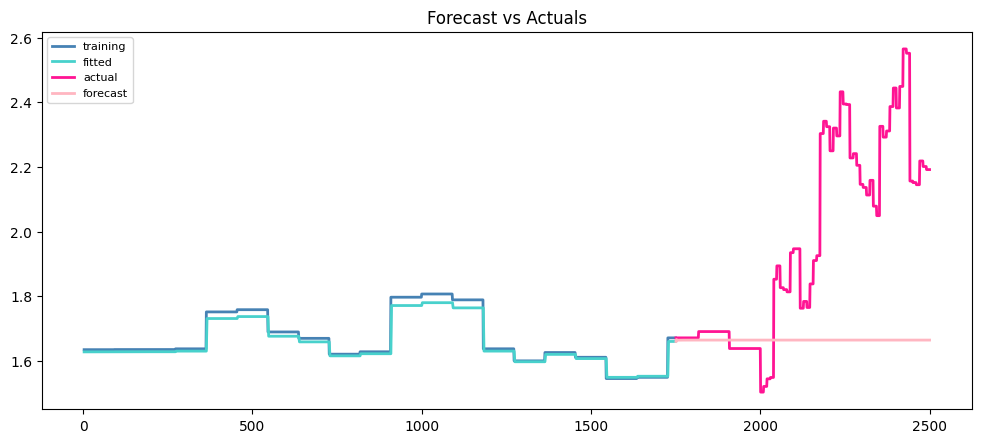

In [ ]:
plotForecastvsActuals(train_y, test_y, fitted_series, forecast_series)

# **Image Classification using Box Plot Analysis**

### **Import Librarires**
Import required libraries for binary classification (which are not previously imported)

In [ ]:
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import math
import seaborn as sns
import statsmodels.api as sm

### **Define Parameters**

In [ ]:
#Define to binary classes
class_name = ['normal', 'anomaly']

### **Visualise using Box Plot**
Function written to visualise the residuals series using a box plot

In [ ]:
def visualisePlot(residuals):
  # Creating dataset
  data = np.array(residuals).astype(np.float)
  fig = plt.figure(figsize =(10, 7))
 
  # Creating plot
  plt.boxplot(data)
  # show plot
  plt.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  This is separate from the ipykernel package so we can avoid doing imports until


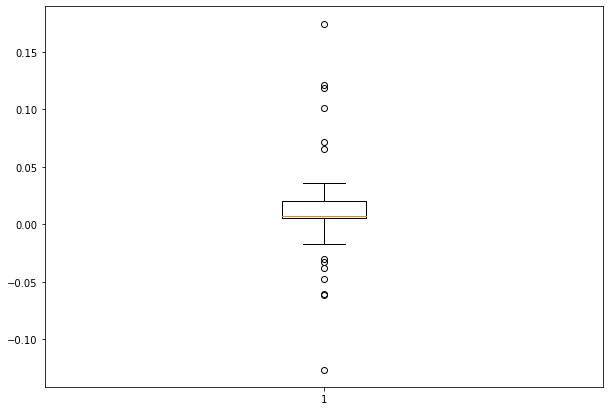

In [ ]:
visualisePlot(residual_series)

### **Create DataFrame from the Residual Series**

In [ ]:
def createResidualsDF(residual_series):
  #Calling DataFrame constructor on list with indices and columns specified
  df = pd.DataFrame(np.array(residual_series).astype(np.float), index = train_seq_len, columns = ['Residual_Error'])
  return df

In [ ]:
residuals_df = createResidualsDF(residual_series)
residuals_df

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  This is separate from the ipykernel package so we can avoid doing imports until


Residual_Error
3           0.006824
4           0.006824
5           0.006824
6           0.006824
7           0.006824
...              ...
1746        0.011108
1747        0.011108
1748        0.011108
1749        0.011108
1750        0.011108

[1748 rows x 1 columns]

### **Residual Analysis**

A good forecasting method will yield residuals with the following properties:

1.  The residuals are uncorrelated. If there are correlations between residuals, then there is information left in the residuals which should be used in computing forecasts.
2.   The residuals have zero mean. If the residuals have a mean other than zero, then the forecasts are biased.

In [ ]:
#Plot the residuals series
def plotResiduals(residuals):
  plt.figure(figsize=(12,5), dpi=100)
  #Residual Error
  plt.plot(train_seq_len, residuals, label='residuals', color='steelblue', linewidth=2)

  plt.title('Residuals Plot')
  plt.legend(loc='upper left', fontsize=8)
  plt.show()

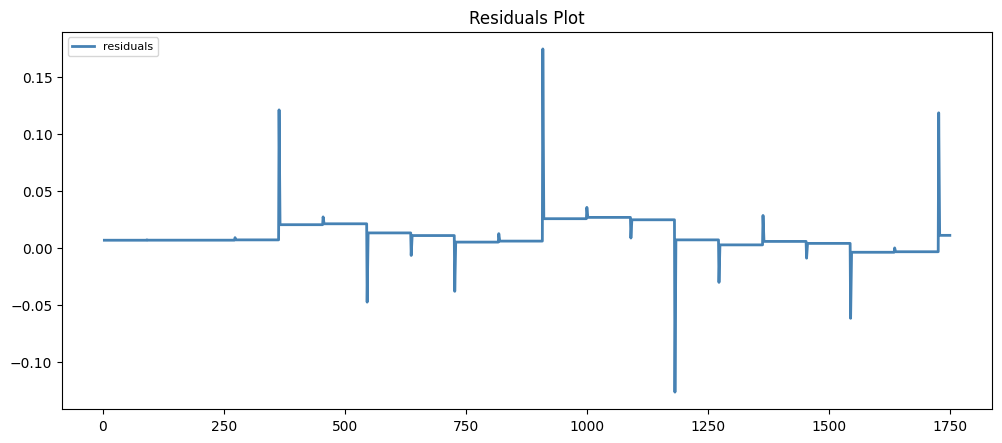

In [ ]:
for i in range(0, len(residual_series)):
    residual_series[i] = float(residual_series[i])
plotResiduals(residual_series)

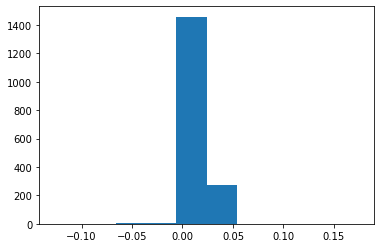

In [ ]:
plt.hist(residual_series)
plt.show()

In [ ]:
from statsmodels.graphics.gofplots import qqplot
from statsmodels.graphics.tsaplots import plot_acf
from matplotlib import pyplot

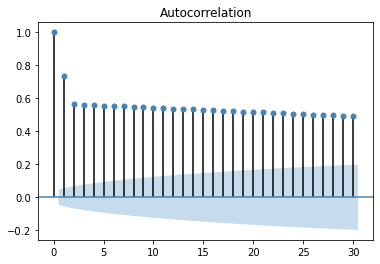

In [ ]:
#ACF Plot of residuals
dta = pd.DataFrame(residual_series)

dta.index = pd.Index(sm.tsa.datetools.dates_from_range('3', '1750'))
sm.graphics.tsa.plot_acf(dta.values, color='steelblue', lags=30)
plt.show()

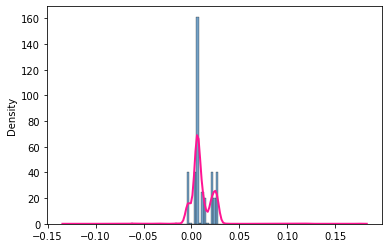

In [ ]:
#Plot histogram of residuals
sns.histplot(residual_series, color='steelblue', stat='density', bins='auto')
sns.kdeplot(residual_series, color='deeppink', linewidth=2)

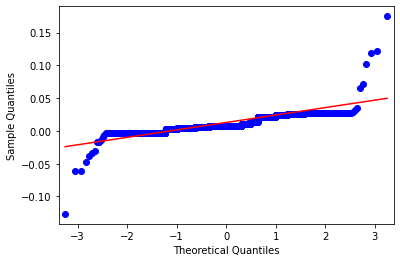

In [ ]:
from statsmodels.graphics.gofplots import qqplot
from matplotlib import pyplot
qqplot(np.array(residual_series), line='q')
pyplot.show()

[]

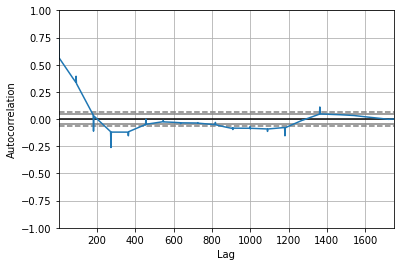

In [ ]:
from pandas.plotting import autocorrelation_plot
ax = autocorrelation_plot(residual_series)
ax.plot(figsize=(5000,4000))

### **Calculate Statistical Data**
Function to calculate statistical data such as percentiles, mean, median, etc. for the residual series. 

In [ ]:
def calculateStatistical(df):
  return df.describe(percentiles=[.25, .5, .75], include=None, exclude=None)

In [ ]:
stat_data = calculateStatistical(residuals_df)
print(stat_data)

       Residual_Error
count     1748.000000
mean         0.010306
std          0.011917
min         -0.126575
25%          0.005179
50%          0.006873
75%          0.020469
max          0.174827


In [ ]:
#Calculate q1 and q3 percentiles
residuals_arr = np.array(residual_series).astype(float)
q1 = np.percentile(residuals_arr, 25)
q3 = np.percentile(residuals_arr, 75)
print(q1, q3)

0.005179 0.020469


### **Create DataFrame from Forecasted Series**

In [ ]:
def createForecastedDF(forecasted_series):
  df = pd.DataFrame(np.array(forecasted_series).astype(np.float), index = range(1751, 2500), columns = ['Forecasted_Error'])
  return df

In [ ]:
forecastedError_df = createForecastedDF(forecastError_series)
forecastedError_df

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  


Forecasted_Error
1751          0.011108
1752          0.005624
1753          0.008225
1754          0.006894
1755          0.007484
...                ...
2495          0.527320
2496          0.527320
2497          0.527320
2498          0.527320
2499          0.527320

[749 rows x 1 columns]

### **Classify Forecasted Data**
Function to classify forecasted data as normal/anomalous based on the box plot boundary values. Here, if the forecasted value is greated that` Q3 + 1.5(Q3-Q1)` or `lesser than Q1 - 1.5(Q3-Q1)` are classified as an anomalous behavior.

In [ ]:
def classifyData(q1, q3, df):
  index = df.index
  upper_boundary = q3 + 1.5 * (q3 - q1)
  lower_boundary = q1 - 1.5 * (q3 - q1)
  for i in index:
    error = df["Forecasted_Error"].loc[i]
    #Classify residuals as normal/anomaly
    if (error>upper_boundary):
      df.loc[i, 'Predicted_Class'] = "Anomaly"
    else:
      df.loc[i, 'Predicted_Class'] = "Normal"

    #Set the actual class
    if(i>=2001):
      df.loc[i, 'Actual_Class'] = "Anomaly"
    else:
      df.loc[i, 'Actual_Class'] = "Normal"

In [ ]:
classifyData(q1, q3, forecastedError_df)
forecastedError_df

Forecasted_Error Predicted_Class Actual_Class
1751          0.011108          Normal       Normal
1752          0.005624          Normal       Normal
1753          0.008225          Normal       Normal
1754          0.006894          Normal       Normal
1755          0.007484          Normal       Normal
...                ...             ...          ...
2495          0.527320         Anomaly      Anomaly
2496          0.527320         Anomaly      Anomaly
2497          0.527320         Anomaly      Anomaly
2498          0.527320         Anomaly      Anomaly
2499          0.527320         Anomaly      Anomaly

[749 rows x 3 columns]

### **Create Confusion Matrix**
Here the `pandas crosstab `function is used to calculate the matrix of FN, FP, TP and TN values.

In [ ]:
def createConfusionMatrix(df):
  contingency_matrix = pd.crosstab(df['Actual_Class'], df['Predicted_Class'])
  print(contingency_matrix)
  return contingency_matrix

In [ ]:
confusion_mat = createConfusionMatrix(forecastedError_df)

Predicted_Class  Anomaly  Normal
Actual_Class                    
Anomaly              460      39
Normal                 0     250


### **Plot Confusion Table**

In [ ]:
def plotConfusionTable(matrix):
  plt.clf()
  ax = fig.add_subplot(111)
  ax.set_aspect(1)
  res = sn.heatmap(matrix.T, annot=True, fmt='.2f', cmap="crest", cbar=False)
  plt.show()

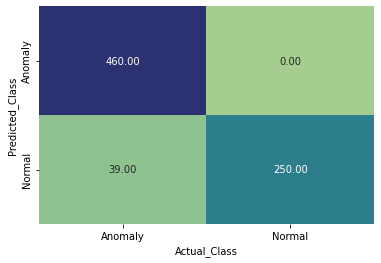

In [ ]:
plotConfusionTable(confusion_mat) 

### **Calculate Accuracy Score**
Accuracy is calculated using the following equation: 

 `Accuracy = (TP + TN)/(TP + TN + FN + FP)`

In [ ]:
def calculateAccuracyScore(df):
  print ('Accuracy Score :',accuracy_score(df['Actual_Class'], df['Predicted_Class']))

In [ ]:
calculateAccuracyScore(forecastedError_df)

Accuracy Score : 0.9479305740987984


### **Print Classification Report**

In [ ]:
def printClassificationReport(df):
  y_test, y_predict = df['Actual_Class'], df['Predicted_Class']
  print(classification_report(y_test, y_predict))

In [ ]:
printClassificationReport(forecastedError_df)

              precision    recall  f1-score   support

     Anomaly       1.00      0.92      0.96       499
      Normal       0.87      1.00      0.93       250

    accuracy                           0.95       749
   macro avg       0.93      0.96      0.94       749
weighted avg       0.95      0.95      0.95       749



### **Plot Residuals and Forecast Errors with the Threshold**

Calculate the threshold which describes the limit value for the anomaly score. Here whiskers of the box plot is used as the threshold values. \
`max_threshold = q3 + 1.5 * (q3 - q1)`

In [ ]:
#Calculate threshold
threshold = q3 + 1.5 * (q3 - q1)
print(threshold)

0.043404000000000005


In [ ]:
def plotErrorvsThreshold(residuals, forecastErrors, thresholdValue):
  plt.figure(figsize=(12,5), dpi=100)
  #Residual Error
  plt.plot(train_seq_len, residuals, label='residuals', color='#2c3172', linewidth=2)
  #Forecasted Error
  plt.plot(range(1751,2500), forecastErrors, label='forecasted errors', color='#a5cd90', linewidth=2 )
  #Threshold
  fx=np.full((2500,1), thresholdValue)
  plt.plot(fx, label="threshold", animated=True, color='deeppink', linewidth=2)

  plt.title('Residuals and Forecast Errors with the Threshold Plot')
  plt.legend(loc='upper left', fontsize=8)
  plt.show()

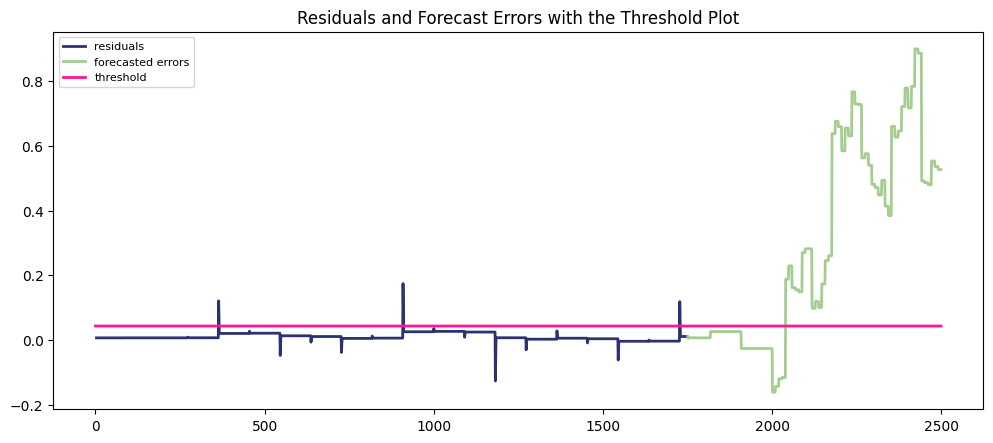

In [ ]:
for i in range(0, len(forecastError_series)):
    forecastError_series[i] = float(forecastError_series[i])
plotErrorvsThreshold(residual_series, forecastError_series, threshold)

### **Standard Evaluation Metrics Calculation**
Standard evaluation metrics are calculated in this section for perfromance evaluation. Metrics that calculated are as follows:\
  `Sensitivity (Sn) = TP/(TP+FN)`\
 ` Specificity (Sp) = TN/(TN+FP)`\
  `Positive Predictive Value (PPV) = TP/(TP+FP)`\
  `Negative Predictive Value (NPV) = TN/(FN+TN)`\
  `G Mean = sqrt(Sensitivity * Specificity)`\
  `F1 = 2 * (PPV*Sn)/(PPV+Sn)`

In [ ]:
def calculatePositivesandNegatives(y_true, y_pred):
  TP, FN, FP, TN = confusion_matrix(list(y_true), list(y_pred)).ravel()
  return FP, FN, TP, TN

In [ ]:
FP, FN, TP, TN = calculatePositivesandNegatives(forecastedError_df['Actual_Class'], forecastedError_df['Predicted_Class'])
print(TP, FN, FP, TN)

460 39 0 250


In [ ]:
def calculateStandardEvaluationMetrics(TP, TN, FP, FN):
  #Sensitivity (Sn): measures the proportion of positive patterns being correctly recognized as being positive.
  Sn = TP/(TP+FN)
  #Specificity (Sp): measures the proportion of negative patterns being correctly recognized as being negative.
  Sp = TN/(TN+FP)
  #Positive Predictive Value (PPV): probability of a positively predicted pattern actually being positive.
  PPV = TP/(TP+FP)
  #Negative Predictive Value (NPV): probability of a negatively predicted pattern actually being negative.
  NPV = TN/(FN+TN)
  #F1-Score
  F1_Score = 2 * (PPV*Sn)/(PPV+Sn)
  #G-Mean
  G_Mean = math.sqrt(Sn * Sp)

  return Sn, Sp, PPV, NPV, F1_Score, G_Mean

In [ ]:
Sn, Sp, PPV, NPV, F1_Score, G_Mean = calculateStandardEvaluationMetrics(TP, TN, FP, FN)
print("Sensitivity: ", Sn)
print("Specificity: ", Sp)
print("Positive Predictive Value (PPV): ", PPV)
print("Negative Predictive Value (NPV): ", NPV)
print("F1-Score: ", F1_Score)
print("G-Mean: ", G_Mean)

Sensitivity:  0.9218436873747495
Specificity:  1.0
Positive Predictive Value (PPV):  1.0
Negative Predictive Value (NPV):  0.8650519031141869
F1-Score:  0.959332638164755
G-Mean:  0.9601269121187831


# **Image Classification using EVT**

### **Import Librarires**
Import required libraries for binary classification (which are not previously imported)

In [ ]:
!pip install fitter

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for fitter: filename=fitter-1.5.1-py3-none-any.whl size=25596 sha256=979a2d2b50e76aaf0654d95d721b18fa0f6ef2cbab9b0fcc13fd189101cfcfba
  Stored in directory: /root/.cache/pip/wheels/40/65/62/57b872ba7af36e70111b1f67cffe76f97c747804aff7665ccb
Successfully built fitter


In [ ]:
from fitter import Fitter
from scipy.stats import gumbel_l

### **Threshold Calculation using EVT**

In [ ]:
def anomaly_threshold_evt(residuals, confidence):
  #transforming the residuals
  extrem_prob_residuals = np.exp(-np.exp(-residuals)) 
  f1 = Fitter(extrem_prob_residuals, distributions=['gumbel_l'], bins=45)
  #fitting to the curve
  f1.fit()
  params = f1.get_best()
  confidence = 1-confidence
  t = gumbel_l.ppf(confidence, loc=params.get("gumbel_l").get("loc"), scale=params.get("gumbel_l").get("scale"))
  
  #retransform
  threshold_val = np.log(-np.log(t))   
  return threshold_val

In [ ]:
evt_threshold = anomaly_threshold_evt(np.array(residual_series), 0.95)

Fitting 1 distributions: 100%|██████████| 1/1 [00:00<00:00,  9.71it/s]


Fitting 106 distributions:  92%|█████████▏| 97/106 [01:47<00:19,  2.15s/it]/usr/local/lib/python3.7/dist-packages/scipy/integrate/quadpack.py:880: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  **opt)
Fitting 106 distributions:  94%|█████████▍| 100/106 [02:04<00:24,  4.04s/it]/usr/local/lib/python3.7/dist-packages/scipy/integrate/quadpack.py:880: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  **opt)
Fitting 106 distributions: 100%|██████████| 106/106 [02:20<00:00,  1.32s/it]


sumsquare_error         aic         bic  kl_div  ks_statistic  \
t                 1483.263451  107.114120 -264.671132     inf      0.185332   
cauchy            1550.762725  107.938586 -194.347520     inf      0.185916   
norminvgauss      1671.238013  332.534305  -48.633575     inf      0.155037   
johnsonsu         1704.074960  130.753989  -14.621444     inf      0.143299   
skewcauchy        1819.675163  112.855142   92.643332     inf      0.171422   

                 ks_pvalue  
t             4.983133e-53  
cauchy        2.308993e-53  
norminvgauss  3.705502e-37  
johnsonsu     8.747861e-32  
skewcauchy    2.212809e-45

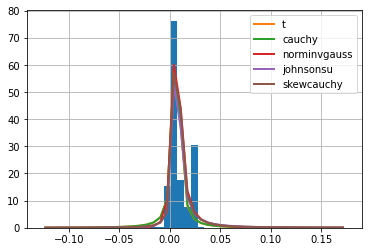

In [ ]:
f = Fitter(residual_series, bins=45)
f.fit()

f.summary()

### **Classify Forecasted Data**
Function to classify forecasted data as normal/anomalous based on the EVT threshold.

In [ ]:
def classifyData(threshold, df):
  index = df.index
  for i in index:
    error = df["Forecasted_Error"].loc[i]
    #Classify residuals as normal/anomaly
    if (error>threshold):
      df.loc[i, 'Predicted_Class'] = "Anomaly"
    else:
      df.loc[i, 'Predicted_Class'] = "Normal"

    #Set the actual class
    if(i>=2001):
      df.loc[i, 'Actual_Class'] = "Anomaly"
    else:
      df.loc[i, 'Actual_Class'] = "Normal"

In [ ]:
evt_forecastedError_df = forecastedError_df
classifyData(evt_threshold, evt_forecastedError_df)
evt_forecastedError_df

Forecasted_Error Predicted_Class Actual_Class
1751          0.011108          Normal       Normal
1752          0.005624          Normal       Normal
1753          0.008225          Normal       Normal
1754          0.006894          Normal       Normal
1755          0.007484          Normal       Normal
...                ...             ...          ...
2495          0.527320         Anomaly      Anomaly
2496          0.527320         Anomaly      Anomaly
2497          0.527320         Anomaly      Anomaly
2498          0.527320         Anomaly      Anomaly
2499          0.527320         Anomaly      Anomaly

[749 rows x 3 columns]

### **Create Confusion Matrix**
Here the `pandas crosstab `function is used to calculate the matrix of FN, FP, TP and TN values.

In [ ]:
evt_confusion_mat = createConfusionMatrix(evt_forecastedError_df)

Predicted_Class  Anomaly  Normal
Actual_Class                    
Anomaly              460      39
Normal                 0     250


### **Plot Confusion Table**

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  This is separate from the ipykernel package so we can avoid doing imports until


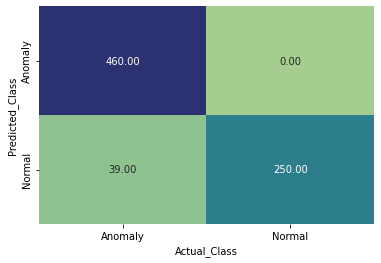

In [ ]:
plotConfusionTable(evt_confusion_mat)

### **Calculate Accuracy Score**
Accuracy is calculated using the following equation: 

 `Accuracy = (TP + TN)/(TP + TN + FN + FP)`

In [ ]:
calculateAccuracyScore(evt_forecastedError_df)

Accuracy Score : 0.9479305740987984


### **Print Classification Report**

In [ ]:
printClassificationReport(evt_forecastedError_df)

              precision    recall  f1-score   support

     Anomaly       1.00      0.92      0.96       499
      Normal       0.87      1.00      0.93       250

    accuracy                           0.95       749
   macro avg       0.93      0.96      0.94       749
weighted avg       0.95      0.95      0.95       749



### **Plot Residuals and Forecast Errors with the Threshold**

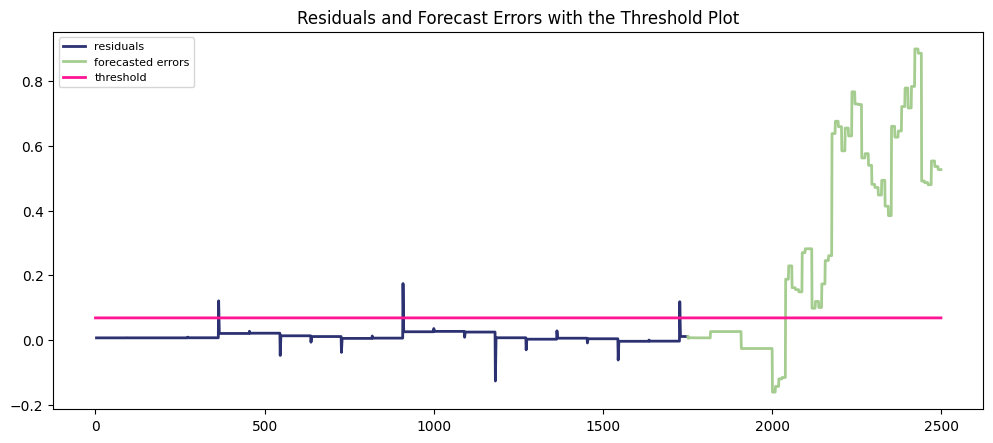

In [ ]:
for i in range(0, len(forecastError_series)):
    forecastError_series[i] = float(forecastError_series[i])
plotErrorvsThreshold(residual_series, forecastError_series, evt_threshold)

### **Standard Evaluation Metrics Calculation**
Standard evaluation metrics are calculated in this section for perfromance evaluation. Metrics that calculated are as follows:\
  `Sensitivity (Sn) = TP/(TP+FN)`\
 ` Specificity (Sp) = TN/(TN+FP)`\
  `Positive Predictive Value (PPV) = TP/(TP+FP)`\
  `Negative Predictive Value (NPV) = TN/(FN+TN)`\
  `Precision (P) = (TP+TN)/(TP+TN+FP+FN)`\
  `Correlation Coefficient (CC) = (TP*TN-FP*FN)/math.sqrt((Np)*(TP+FP)*(Nn)*(TN+FN))`

In [ ]:
def calculatePositivesandNegatives(y_true, y_pred):
  TP, FN, FP, TN = confusion_matrix(list(y_true), list(y_pred)).ravel()
  return FP, FN, TP, TN

In [ ]:
evt_FP, evt_FN, evt_TP, evt_TN = calculatePositivesandNegatives(evt_forecastedError_df['Actual_Class'], evt_forecastedError_df['Predicted_Class'])
print(evt_FP, evt_FN, evt_TP, evt_TN)

0 39 460 250


In [ ]:
def calculateStandardEvaluationMetrics(TP, TN, FP, FN):
  #Sensitivity (Sn): measures the proportion of positive patterns being correctly recognized as being positive.
  Sn = TP/(TP+FN)
  #Specificity (Sp): measures the proportion of negative patterns being correctly recognized as being negative.
  Sp = TN/(TN+FP)
  #Positive Predictive Value (PPV): probability of a positively predicted pattern actually being positive.
  PPV = TP/(TP+FP)
  #Negative Predictive Value (NPV): probability of a negatively predicted pattern actually being negative.
  NPV = TN/(FN+TN)
  #F1-Score
  F1_Score = 2 * (PPV*Sn)/(PPV+Sn)
  #G-Mean
  G_Mean = math.sqrt(Sn * Sp)

  return Sn, Sp, PPV, NPV, F1_Score, G_Mean

In [ ]:
evt_Sn, evt_Sp, evt_PPV, evt_NPV, evt_F1_Score, evt_G_Mean = calculateStandardEvaluationMetrics(evt_TP, evt_TN, evt_FP, evt_FN)
print("Sensitivity: ", evt_Sn)
print("Specificity: ", evt_Sp)
print("Positive Predictive Value (PPV): ", evt_PPV)
print("Negative Predictive Value (NPV): ", evt_NPV)
print("F1-Score: ", evt_F1_Score)
print("G-Mean: ", evt_G_Mean)

Sensitivity:  0.9218436873747495
Specificity:  1.0
Positive Predictive Value (PPV):  1.0
Negative Predictive Value (NPV):  0.8650519031141869
F1-Score:  0.959332638164755
G-Mean:  0.9601269121187831
